In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [2]:
# Load the subject data
subject_num = '01'
subject_df = pd.read_csv(f"../bidmc_data/bidmc_{subject_num}_Signals.csv")
subject_df.head()
subject_df.columns = subject_df.columns.str.strip()

In [3]:
length = subject_df.shape[0]
fs = 125  # Sampling frequency
minutes = length // (fs * 60)
print(f"Total length: {length} samples, which is approximately {minutes} minutes of data.")

Total length: 60001 samples, which is approximately 8 minutes of data.


In [15]:
def apply_bandpass_filter(signal, lowcut, highcut, order=4):
        nyquist = 0.5 * 125 # Assuming fs = 125 Hz
        low = lowcut / nyquist
        high = highcut / nyquist
        # Clip high per sicurezza se vicino alla frequenza di Nyquist
        if high >= 1.0: high = 0.99 
        b, a = butter(order, [low, high], btype='bandpass')
        return filtfilt(b, a, signal)

def plot_per_controllo_filtro_pb(df, strat_idx, end_idx, subject_num):
    plt.figure(figsize=(15, 10))
    time = list(range(strat_idx, end_idx))
    ppg_filtrato = apply_bandpass_filter(df['PPG'][strat_idx:end_idx], lowcut=0.5, highcut=8.0)
    ecg_filtrato = apply_bandpass_filter(df['ECG'][strat_idx:end_idx], lowcut=0.5, highcut=25.0)
    plt.subplot(2, 1, 1)
    plt.plot(time, ppg_filtrato, color='blue')
    plt.title(f'PPG - Subject {subject_num}')
    plt.subplot(2, 1, 2)
    plt.plot(time, ecg_filtrato, color='red')
    plt.title(f'ECG-II - Subject {subject_num}')
    plt.tight_layout()
    plt.show()

def plot_per_controllo(df, strat_idx, end_idx, subject_num):
    plt.figure(figsize=(15, 10))
    time = list(range(strat_idx, end_idx))
    plt.subplot(2, 1, 1)
    plt.plot(time, df['PPG'][strat_idx:end_idx], color='blue')
    plt.title(f'PPG - Subject {subject_num}')
    plt.subplot(2, 1, 2)
    plt.plot(time, df['ECG'][strat_idx:end_idx], color='red')
    plt.title(f'ECG-II - Subject {subject_num}')
    plt.tight_layout()
    plt.show()
    
def plot_per_controllo_inverso(df, strat_idx, end_idx, subject_num):
    plt.figure(figsize=(15, 10))
    time = list(range(strat_idx, end_idx))
    plt.subplot(2, 1, 1)
    plt.plot(time, df['PPG'][strat_idx:end_idx], color='blue')
    plt.title(f'PPG - Subject {subject_num}')
    plt.subplot(2, 1, 2)
    plt.plot(time, -df['ECG'][strat_idx:end_idx], color='red')
    plt.title(f'ECG-II - Subject {subject_num}')
    plt.tight_layout()
    plt.show()



In [8]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew, kurtosis

# 1. FIX DEI PERCORSI PER NOTEBOOK
# Risaliamo alla root del progetto (un livello sopra 'notebooks/')
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Aggiungiamo la root a sys.path per permettere l'importazione dei tuoi moduli 'src'
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Definiamo il percorso corretto per i dati
DATA_PATH = os.path.join(PROJECT_ROOT, 'bidmc_data')

# 2. IMPORTAZIONE DEI TUOI MODULI
try:
    from src.data_loader.bidmc_data_loader import BidmcDataLoader
    print(f"Moduli caricati correttamente. Root del progetto: {PROJECT_ROOT}")
except ImportError as e:
    print(f"Errore: Assicurati che la cartella 'src' sia nella root {PROJECT_ROOT}. Errore: {e}")

Moduli caricati correttamente. Root del progetto: /home/mattio/ECG-Reconstruction


In [9]:
def audit_dataset_quality(base_path):
    loader = BidmcDataLoader()
    # Carichiamo tutti i soggetti disponibili (1-53)
    subject_ids = [str(i).zfill(2) for i in range(1, 54)]
    raw_data = loader.load_subjects(subject_ids, base_path)
    subjects_dict = raw_data['subjects_data']

    # Verifica se S01 è stato caricato
    if 'S01' not in subjects_dict:
        print(f"ERRORE: Soggetto S01 non trovato in {base_path}. Verifica i file CSV.")
        return
    
    ecg_s01 = subjects_dict['S01']['ECG']
    baseline_skew = skew(ecg_s01)
    baseline_kurt = kurtosis(ecg_s01)
    
    print(f"\n--- BASELINE GOLD STANDARD (S01) ---")
    print(f"Skewness: {baseline_skew:.3f} | Kurtosis: {baseline_kurt:.3f}\n")

    report = []

    for s_key in sorted(subjects_dict.keys()):
        ecg = subjects_dict[s_key]['ECG']
        val_skew = skew(ecg)
        val_kurt = kurtosis(ecg)
        
        # Rilevamento saturazione
        max_val, min_val = np.max(ecg), np.min(ecg)
        sat_high = np.sum(ecg >= max_val * 0.999) / len(ecg)
        sat_low = np.sum(ecg <= min_val * 0.999) / len(ecg)
        
        status = "OK"
        notes = []

        if val_skew < 0:
            status = "CRITICO"
            notes.append("Invertito")
        if val_kurt < (baseline_kurt * 0.4):
            status = "WARNING"
            notes.append("Rumoroso")
        if sat_high > 0.02 or sat_low > 0.02:
            status = "WARNING"
            notes.append("Saturato")

        report.append({
            'ID': s_key, 'Status': status, 
            'Skewness': round(val_skew, 3), 'Kurtosis': round(val_kurt, 3), 
            'Notes': ", ".join(notes) if notes else "Nessuno"
        })

    df_report = pd.DataFrame(report)
    return df_report, subjects_dict

# 4. ESECUZIONE
df_report, subjects_dict = audit_dataset_quality(DATA_PATH)

if df_report is not None:
    # Mostra i soggetti problematici
    display(df_report[df_report['Status'] != "OK"])

Caricato correttamente: Soggetto 01 (Campioni: 60001)
Caricato correttamente: Soggetto 02 (Campioni: 60001)
Caricato correttamente: Soggetto 03 (Campioni: 60001)
Caricato correttamente: Soggetto 04 (Campioni: 60001)
Caricato correttamente: Soggetto 05 (Campioni: 60001)
Caricato correttamente: Soggetto 06 (Campioni: 60001)
Caricato correttamente: Soggetto 07 (Campioni: 60001)
Caricato correttamente: Soggetto 08 (Campioni: 60001)
Caricato correttamente: Soggetto 09 (Campioni: 60001)
Caricato correttamente: Soggetto 10 (Campioni: 60001)
Caricato correttamente: Soggetto 11 (Campioni: 60001)
Caricato correttamente: Soggetto 12 (Campioni: 60001)
Caricato correttamente: Soggetto 13 (Campioni: 60001)
Caricato correttamente: Soggetto 14 (Campioni: 60001)
Caricato correttamente: Soggetto 15 (Campioni: 60001)
Caricato correttamente: Soggetto 16 (Campioni: 60001)
Caricato correttamente: Soggetto 17 (Campioni: 60001)
Caricato correttamente: Soggetto 18 (Campioni: 60001)
Caricato correttamente: Sogg

ID   Status  Skewness  Kurtosis                          Notes
0   S01  WARNING     2.886     9.260                       Saturato
3   S04  CRITICO    -1.061    10.326                      Invertito
5   S06  WARNING     1.296     1.666                       Rumoroso
8   S09  WARNING     1.738     2.772                       Rumoroso
12  S13  WARNING     0.243     0.485             Rumoroso, Saturato
14  S15  CRITICO    -2.051     4.495                      Invertito
16  S17  WARNING     2.845    20.301                       Saturato
23  S24  WARNING     1.024     6.489                       Saturato
24  S25  WARNING    -0.071     3.193            Invertito, Rumoroso
26  S27  WARNING    -0.259     2.587  Invertito, Rumoroso, Saturato
27  S28  WARNING     3.195    11.072                       Saturato
30  S31  CRITICO    -0.394     7.199                      Invertito
31  S32  WARNING    -1.813     3.305  Invertito, Rumoroso, Saturato
32  S33  WARNING    -0.265     3.581  Invertito, Rumoroso, Saturato
36  S37  WARNING     2.862    10.248                       Saturato
41  S42  WARNING     3.040    10.696                       Saturato
42  S43  WARNING     3.599    15.008                       Saturato
43  S44  CRITICO    -3.125    11.622                      Invertito
44  S45  WARNING     2.158    16.919                       Saturato
45  S46  WARNING     2.089     5.041                       Saturato
48  S49  WARNING    -0.424     3.149            Invertito, Rumoroso
51  S52  WARNING     1.248     3.400                       Rumoroso
52  S53  WARNING     1.108     0.774                       Rumoroso

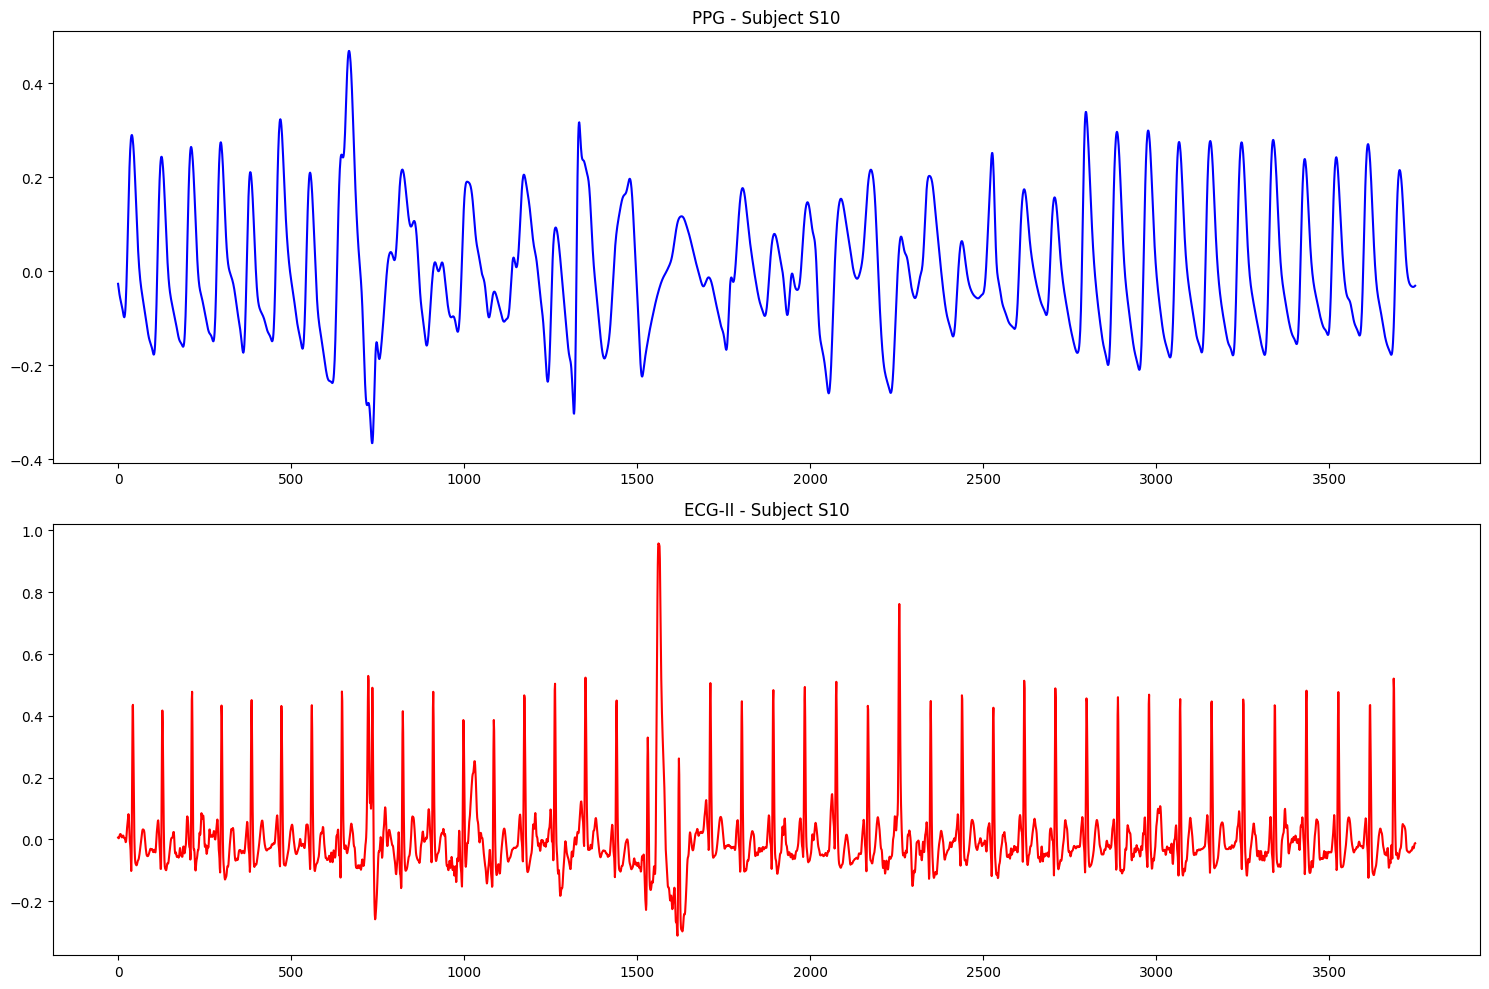

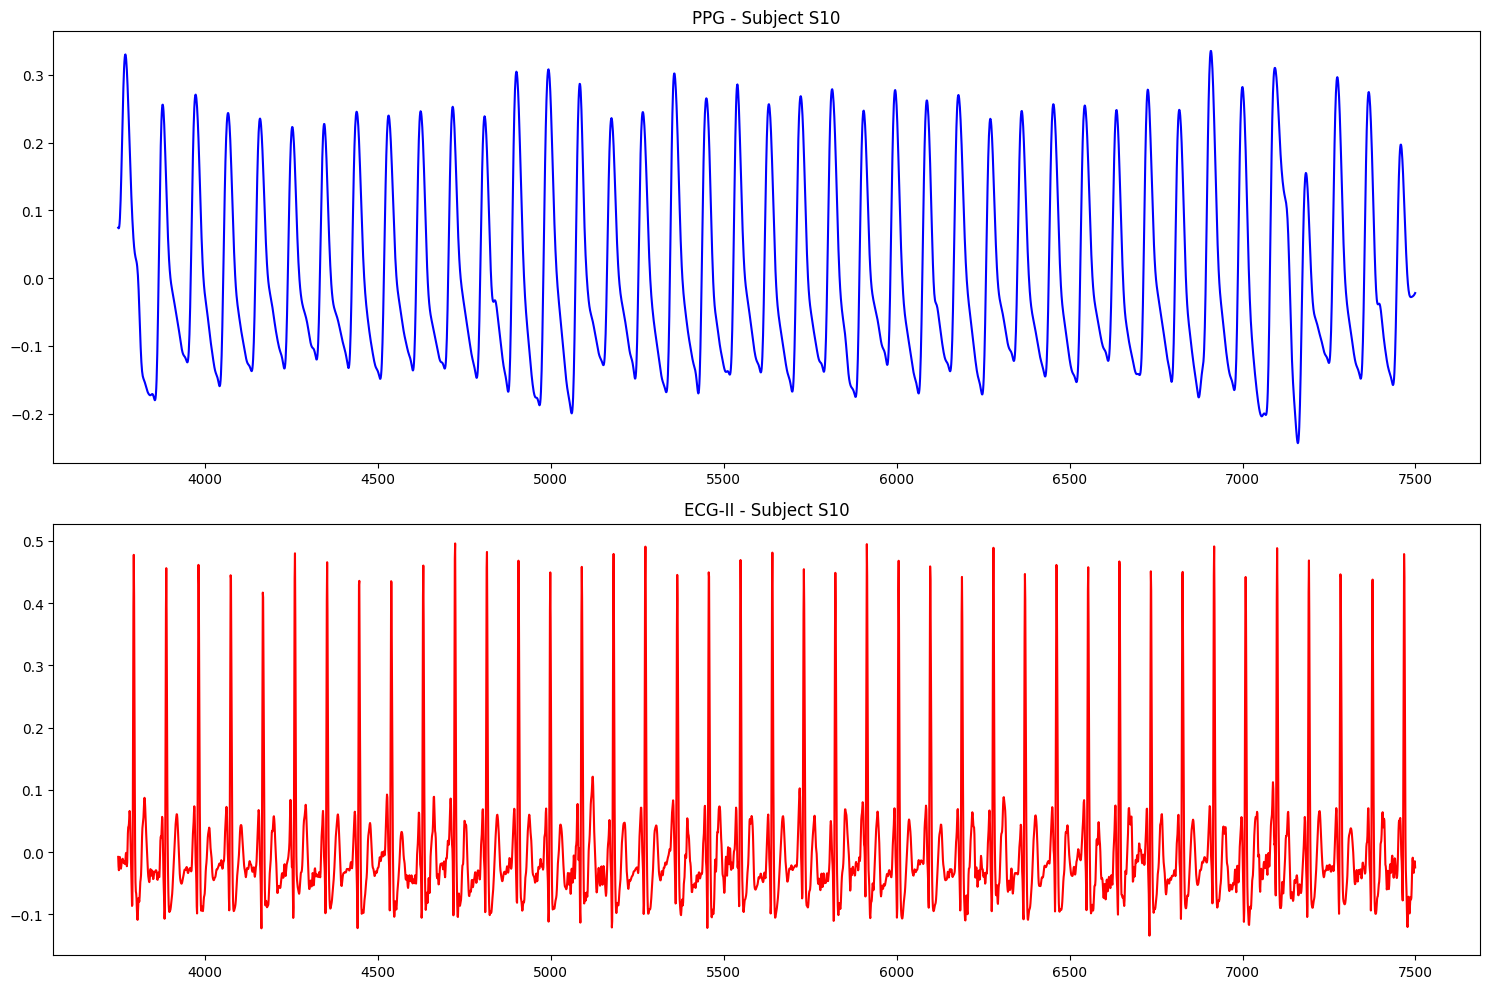

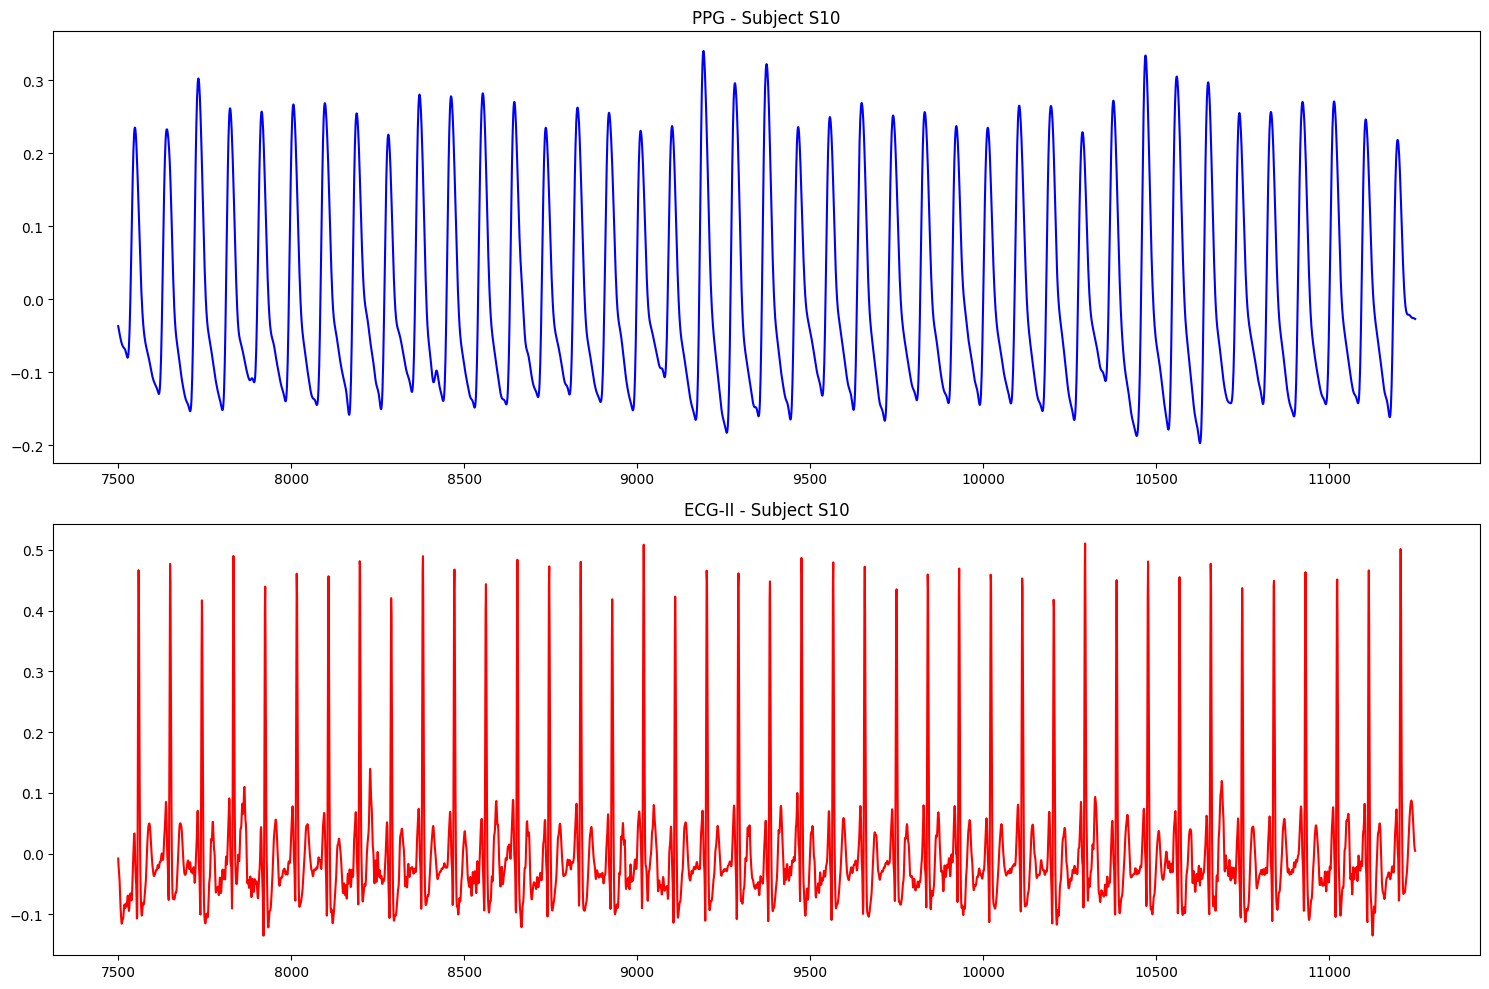

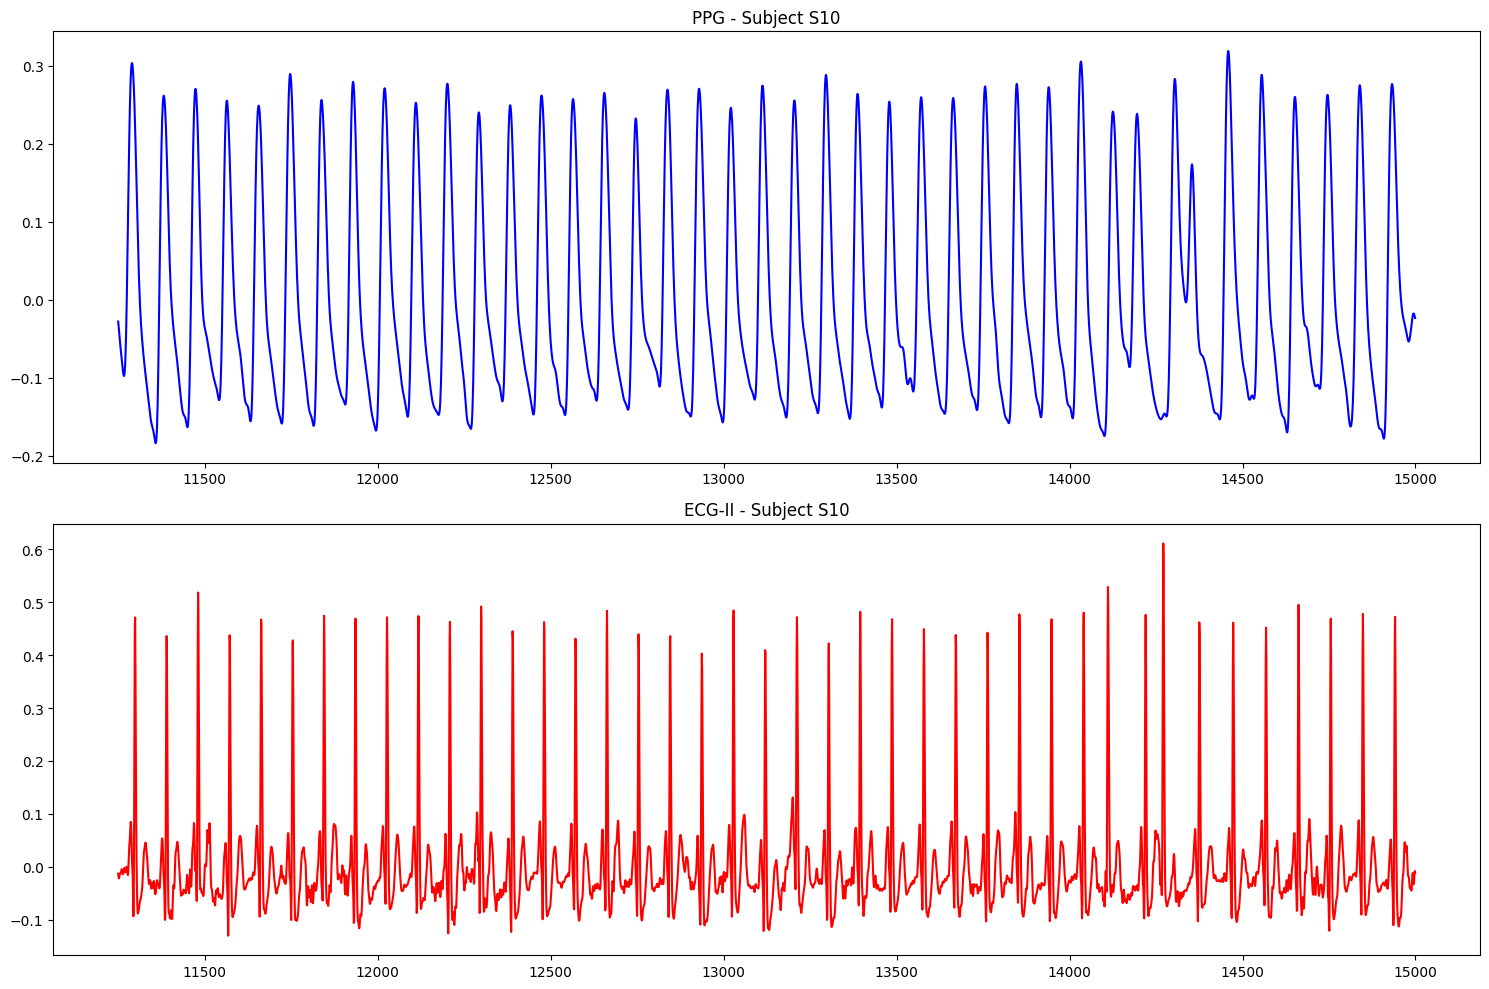

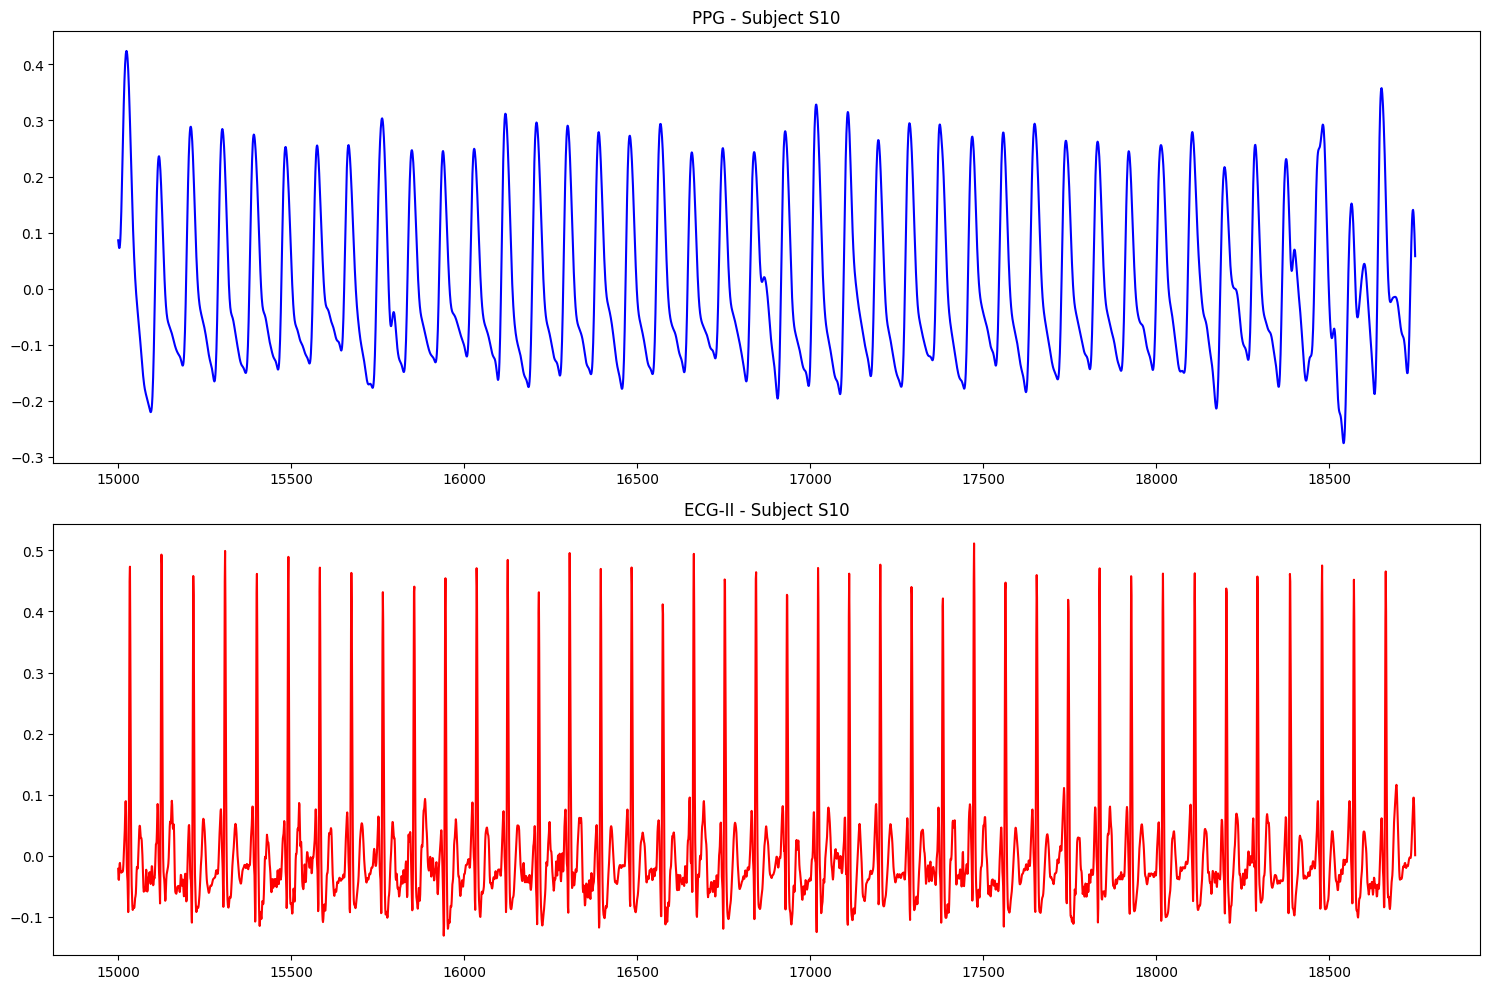

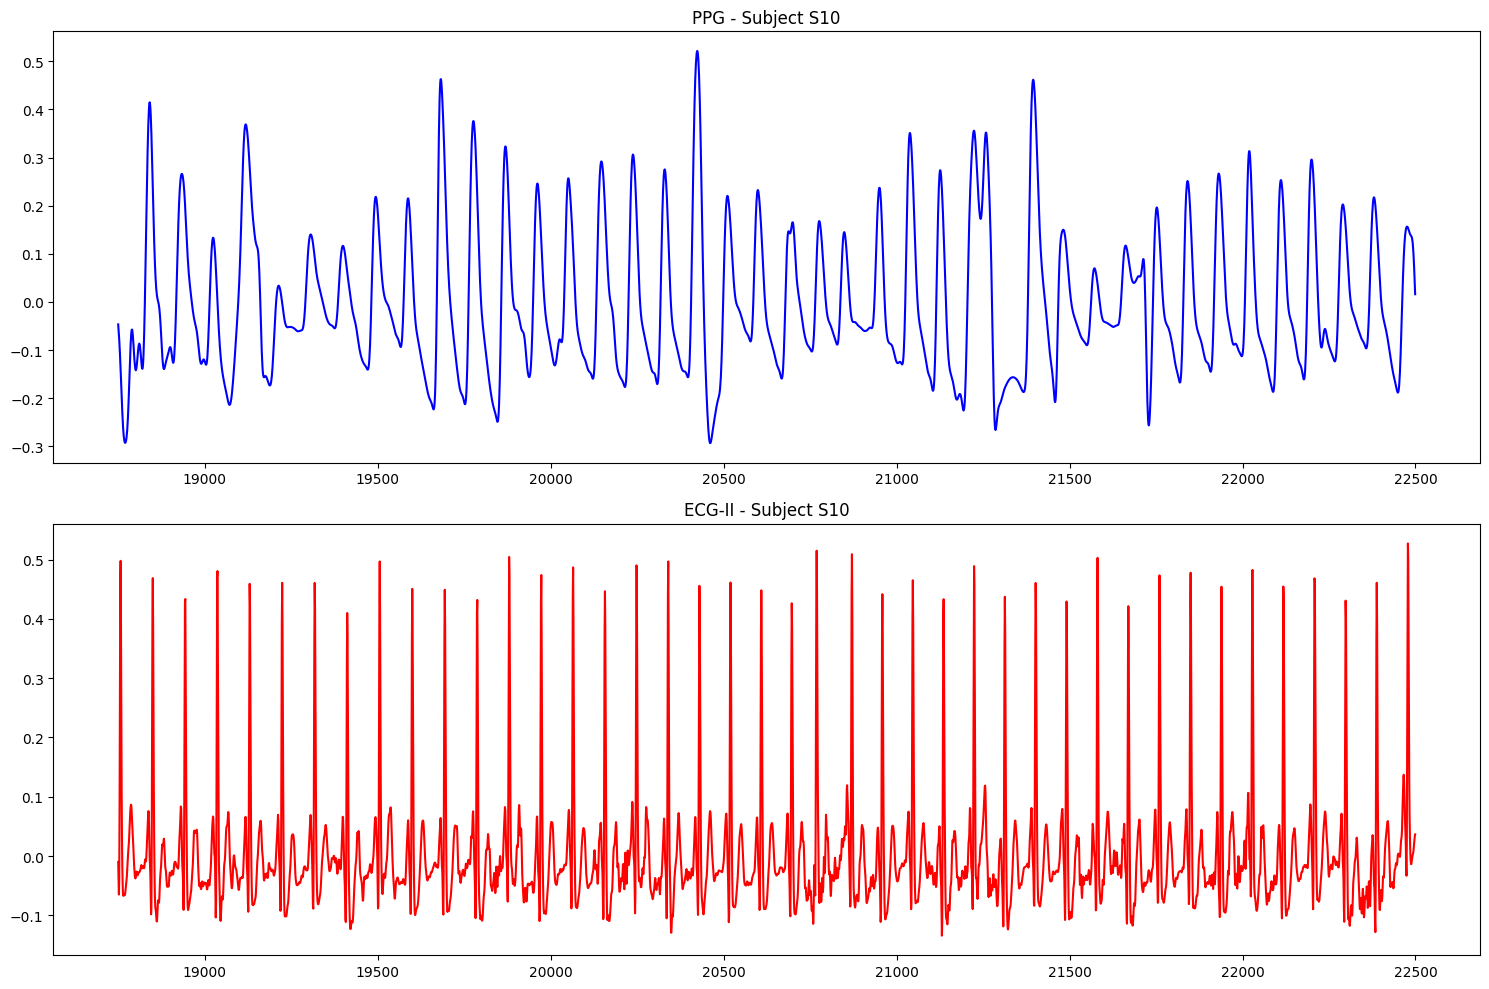

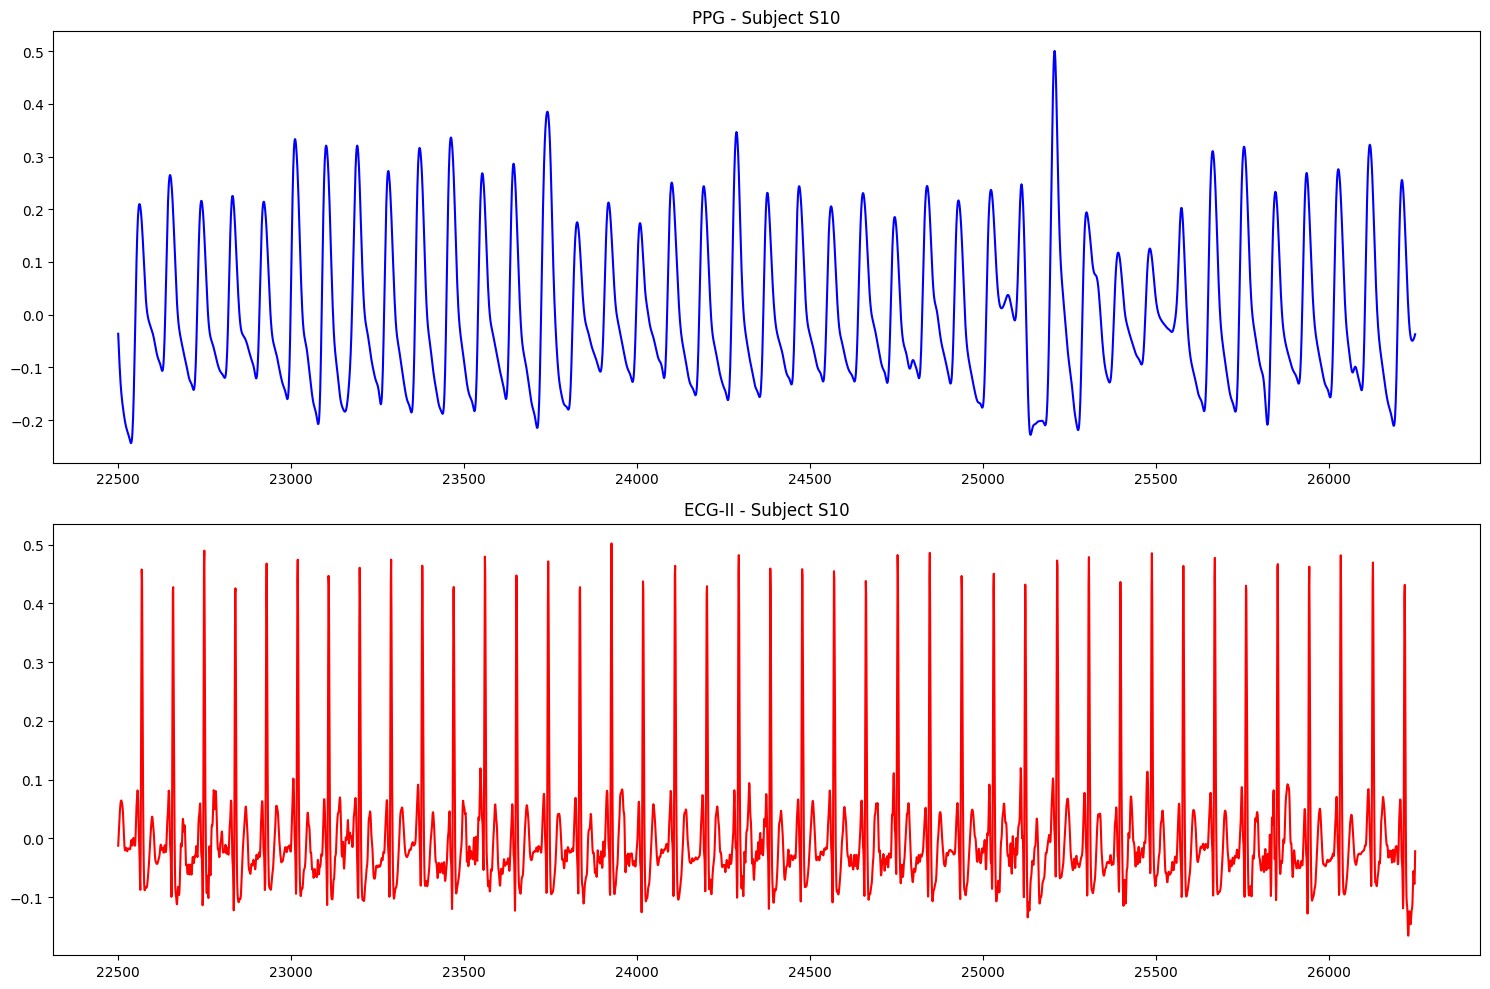

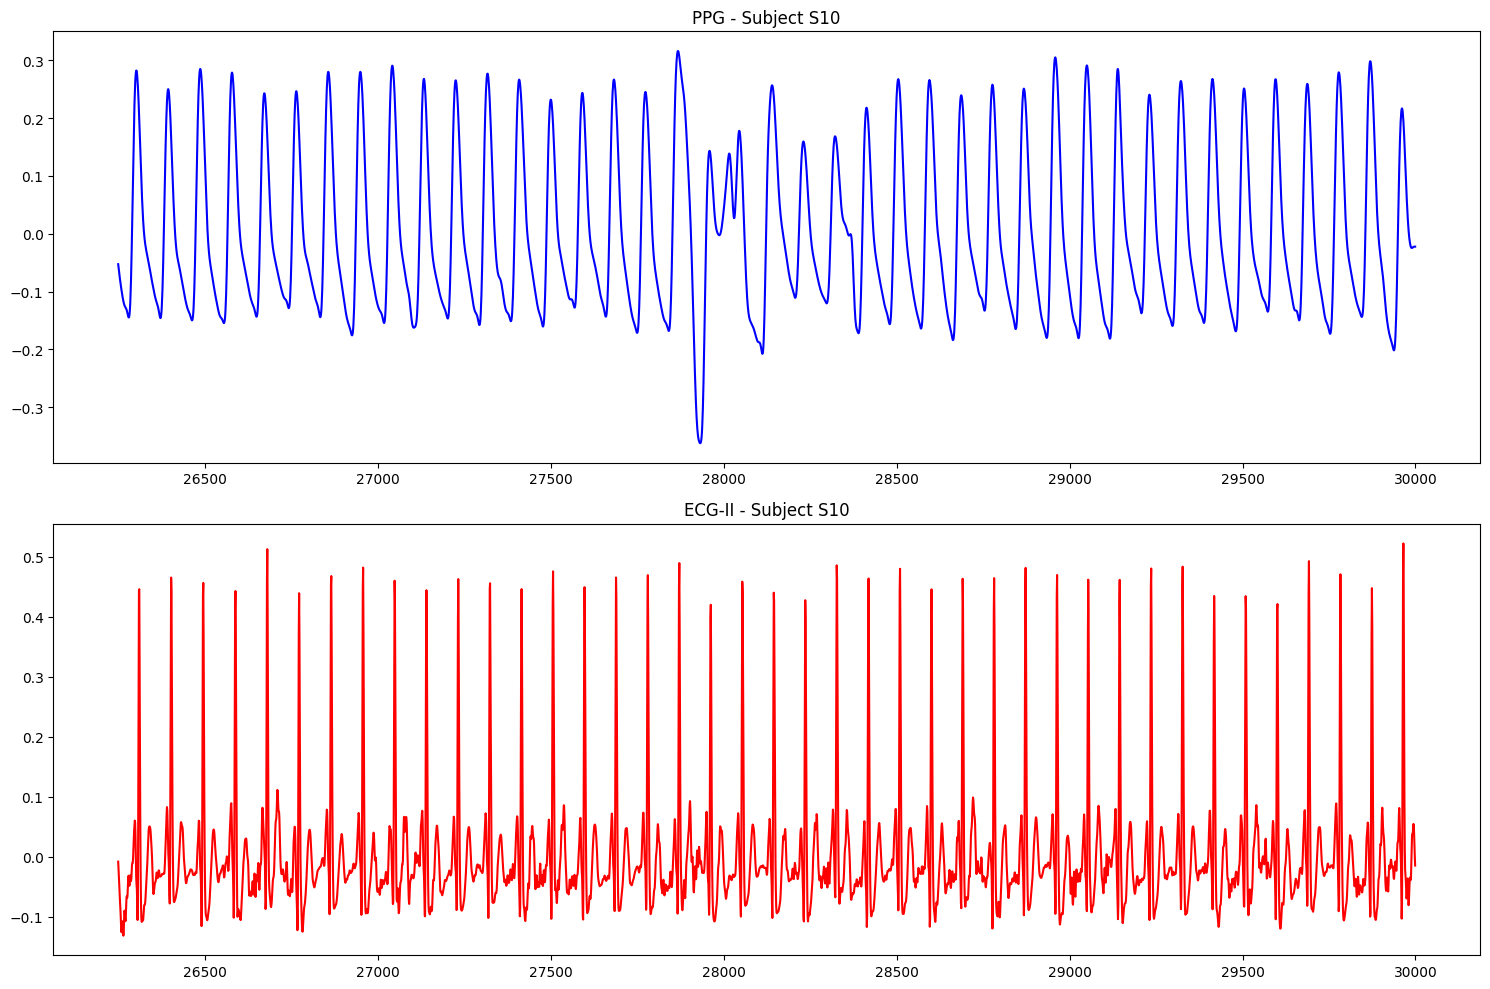

In [22]:
sub_num='S10'
sub = subjects_dict[sub_num]
for i in range(8):
    start_idx = i * 30 * 125
    end_idx = (i + 1) * 30 * 125
    plot_per_controllo_filtro_pb(sub, start_idx, end_idx, sub_num)

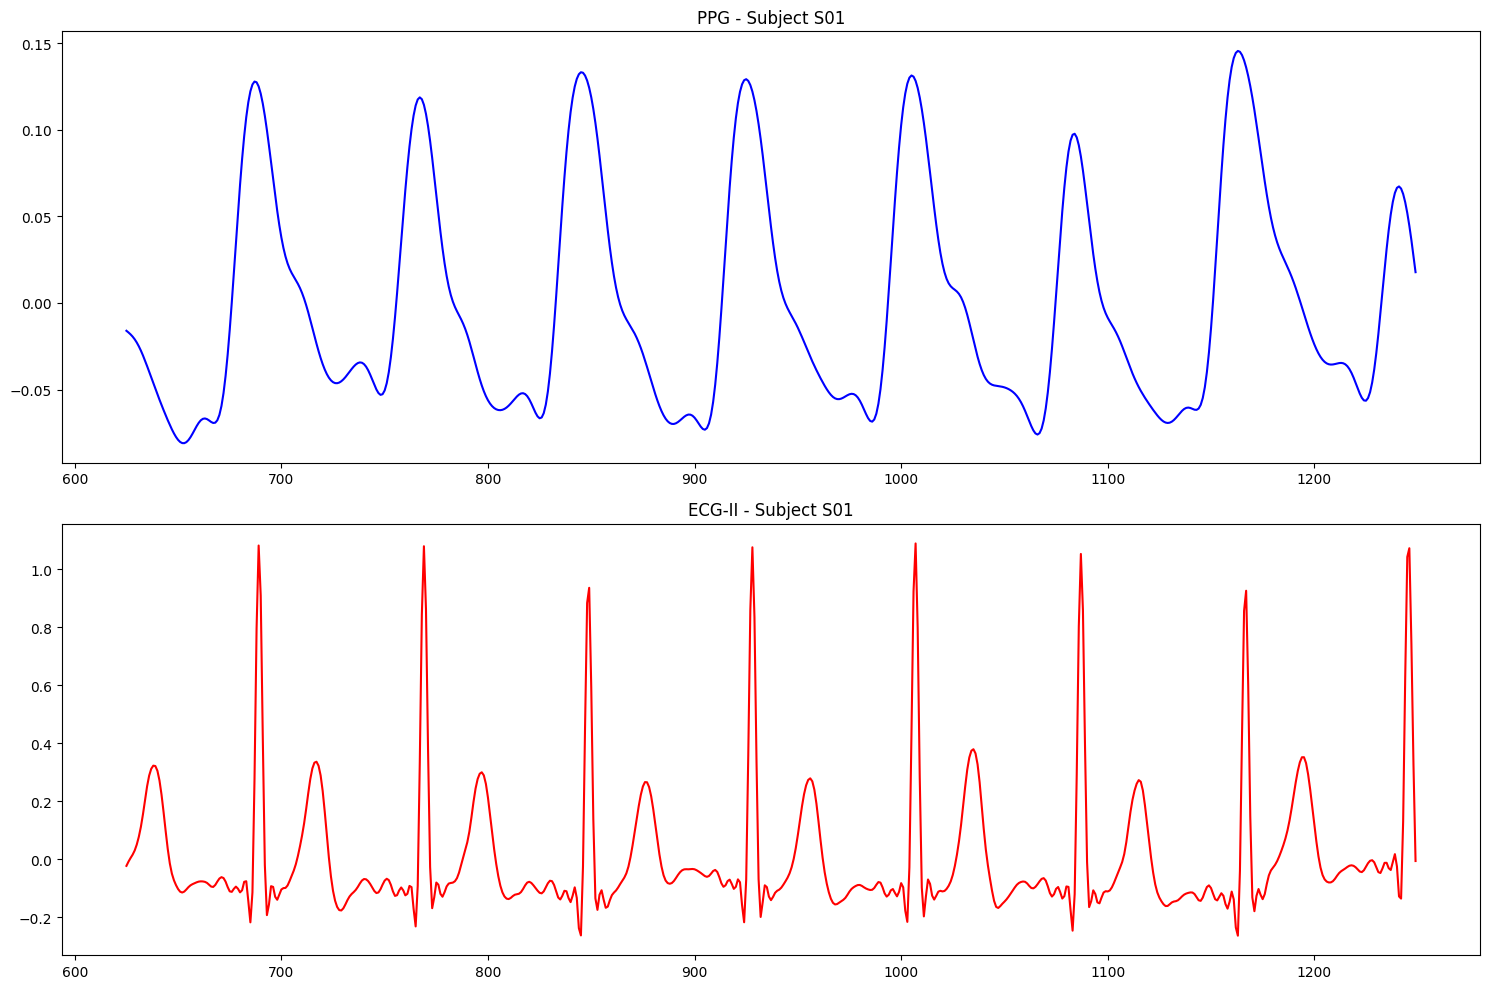

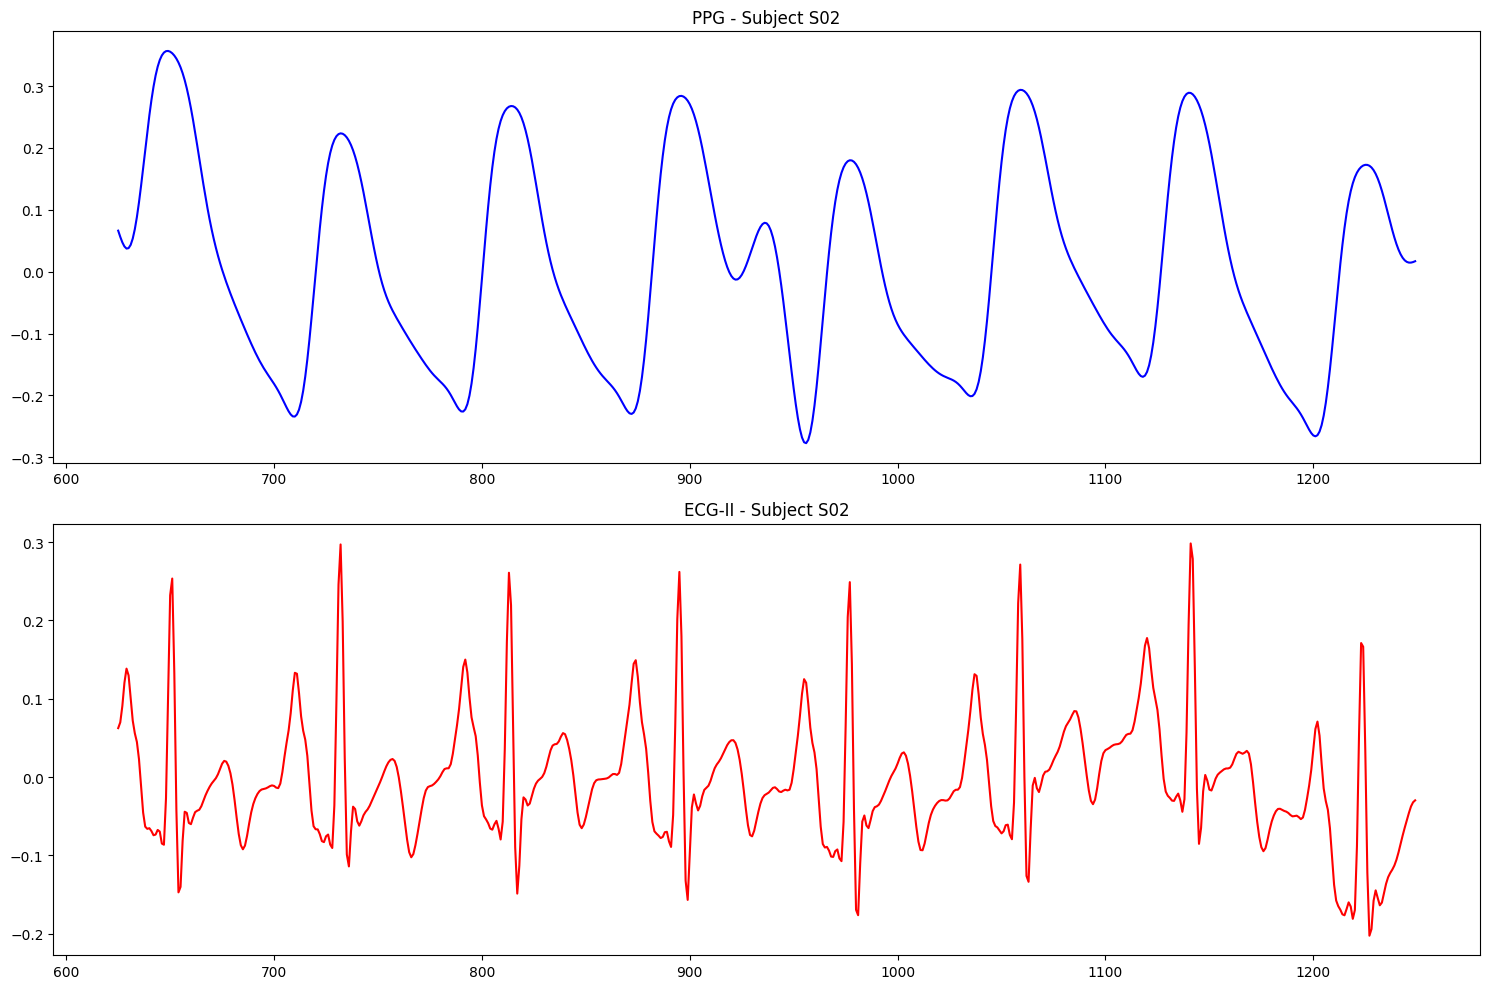

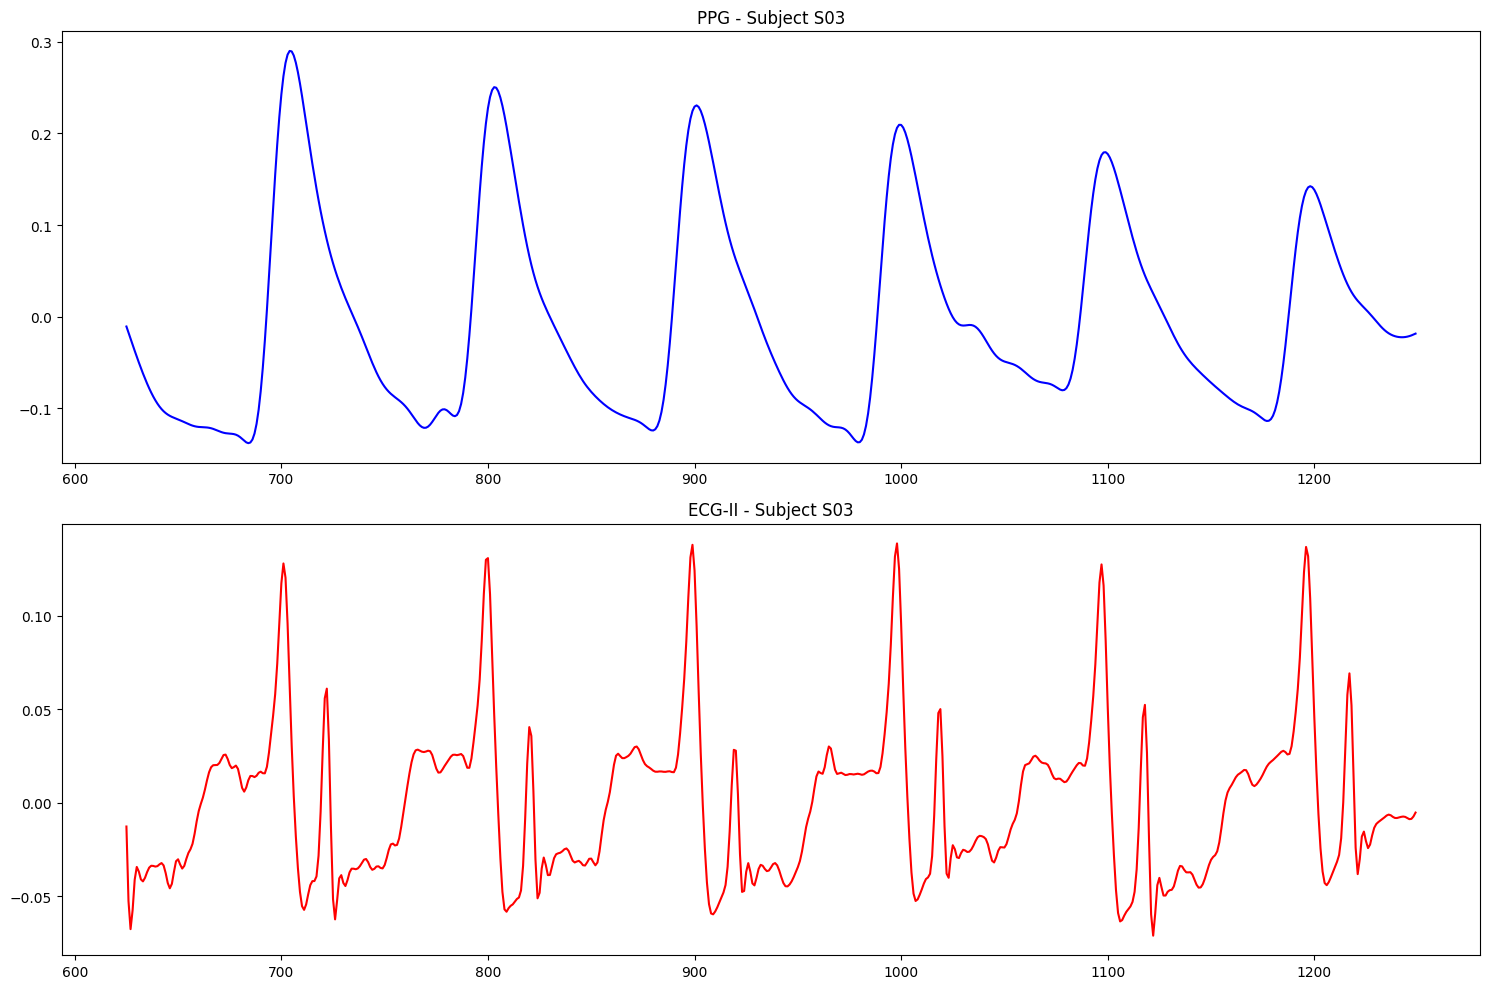

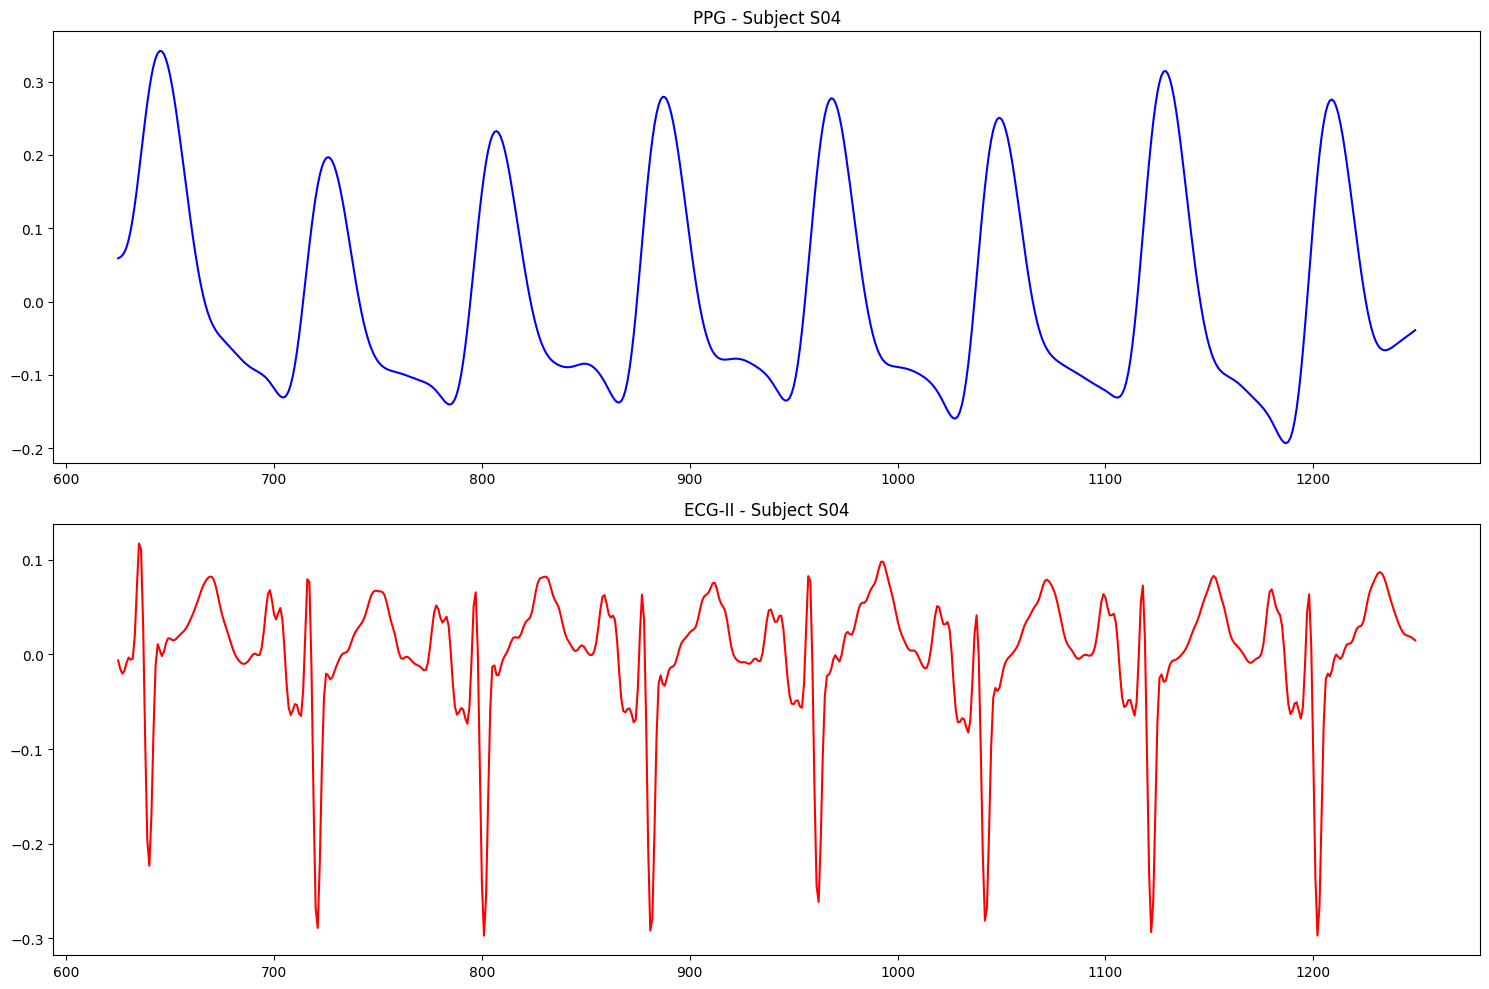

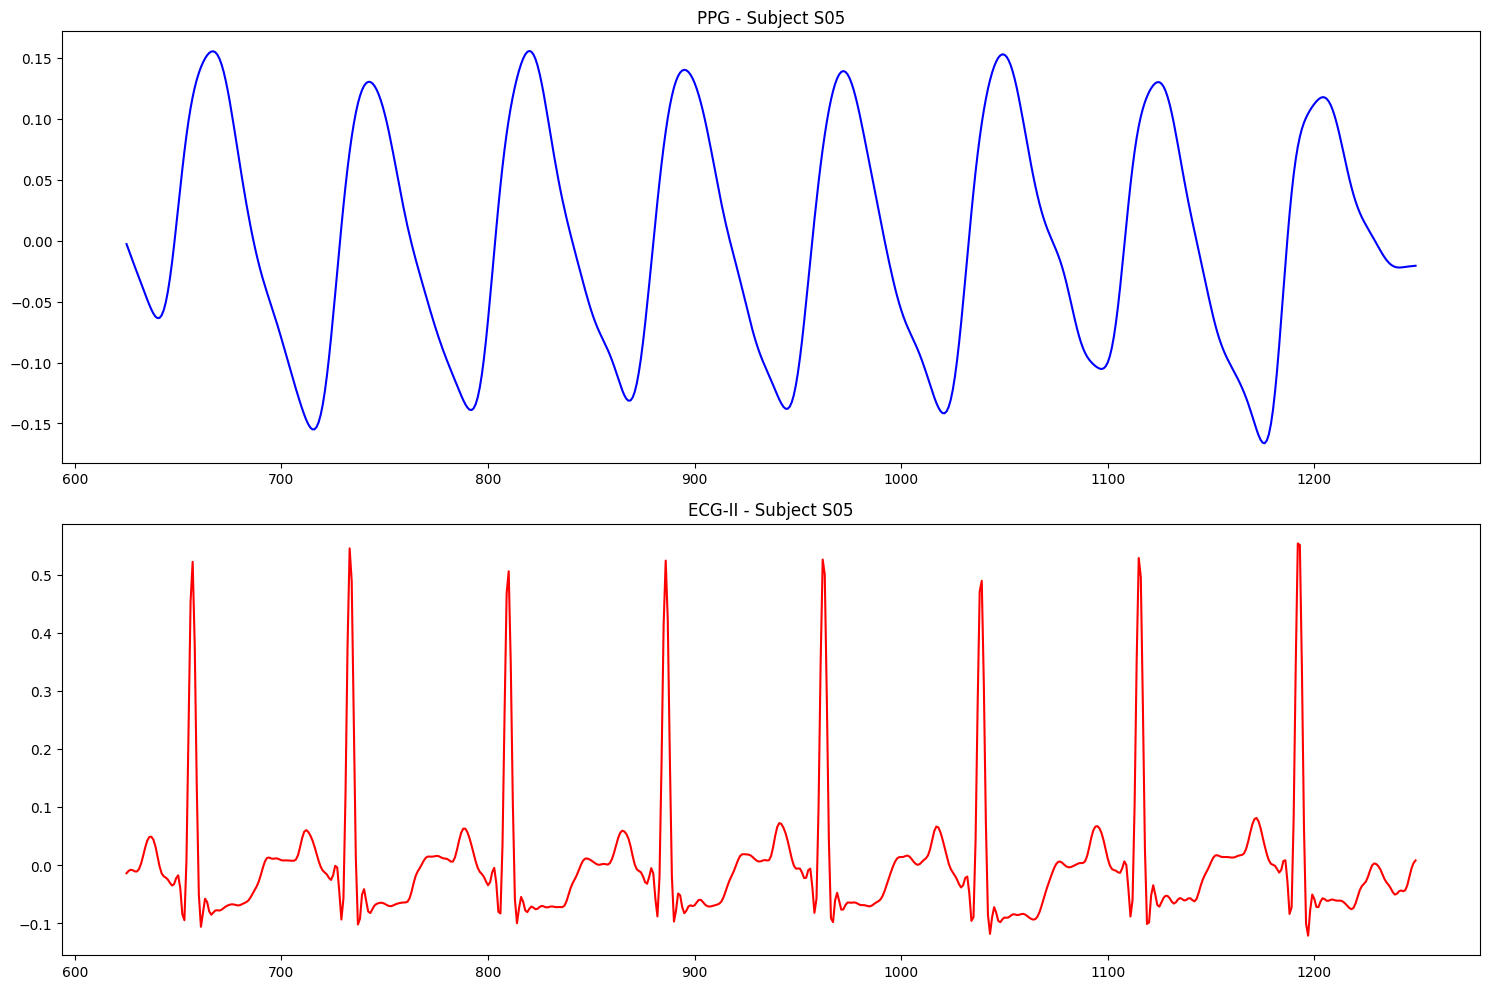

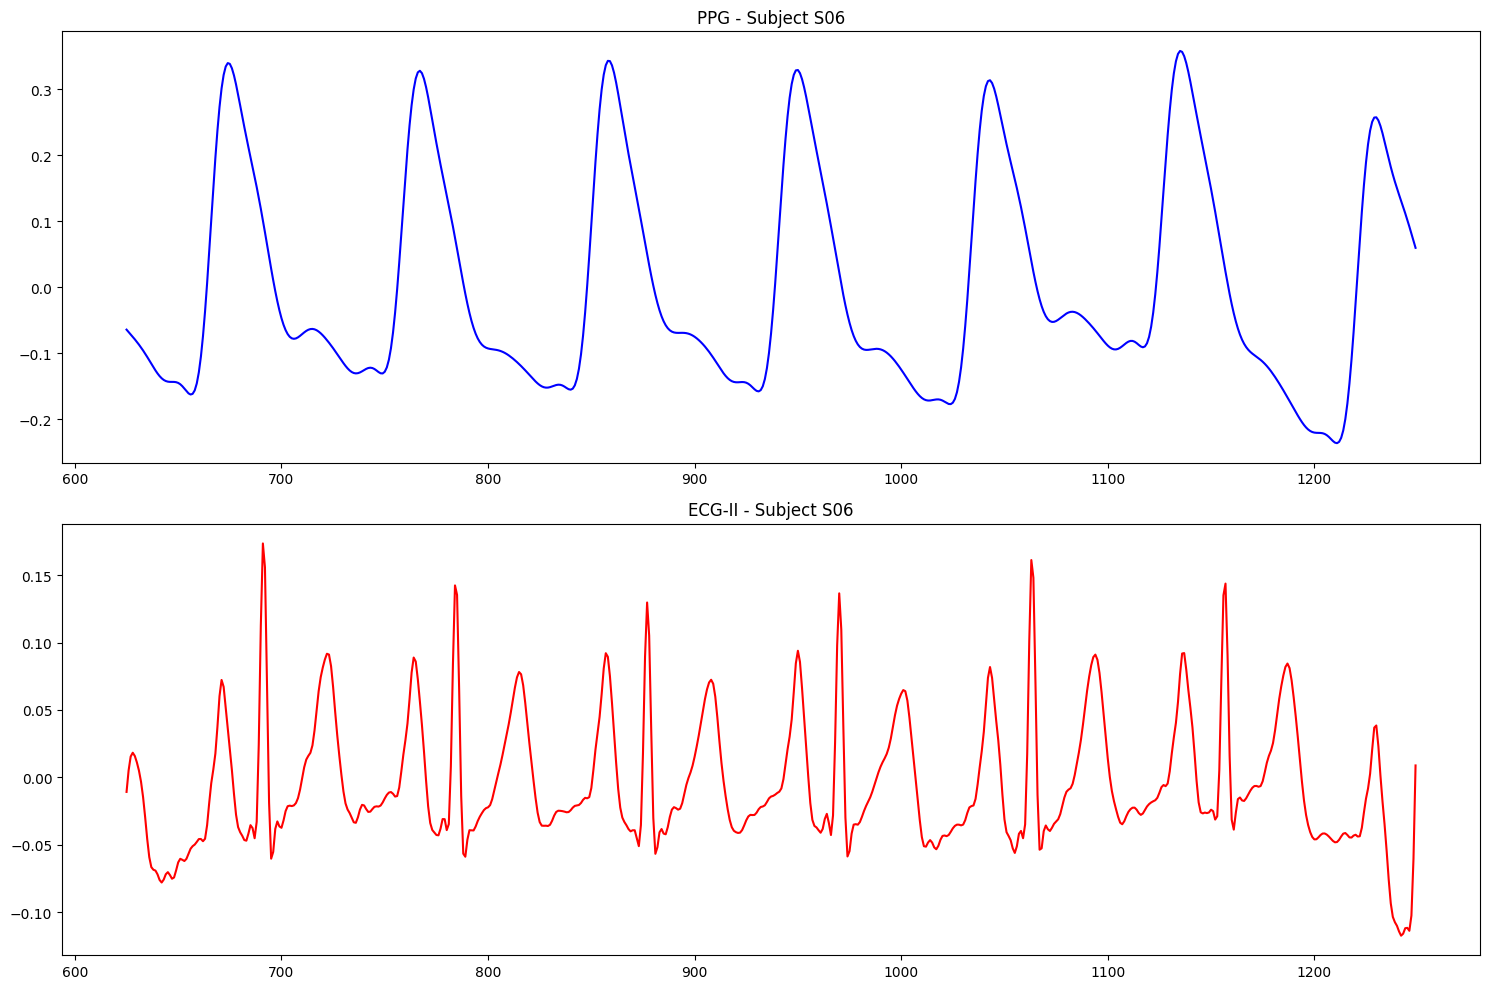

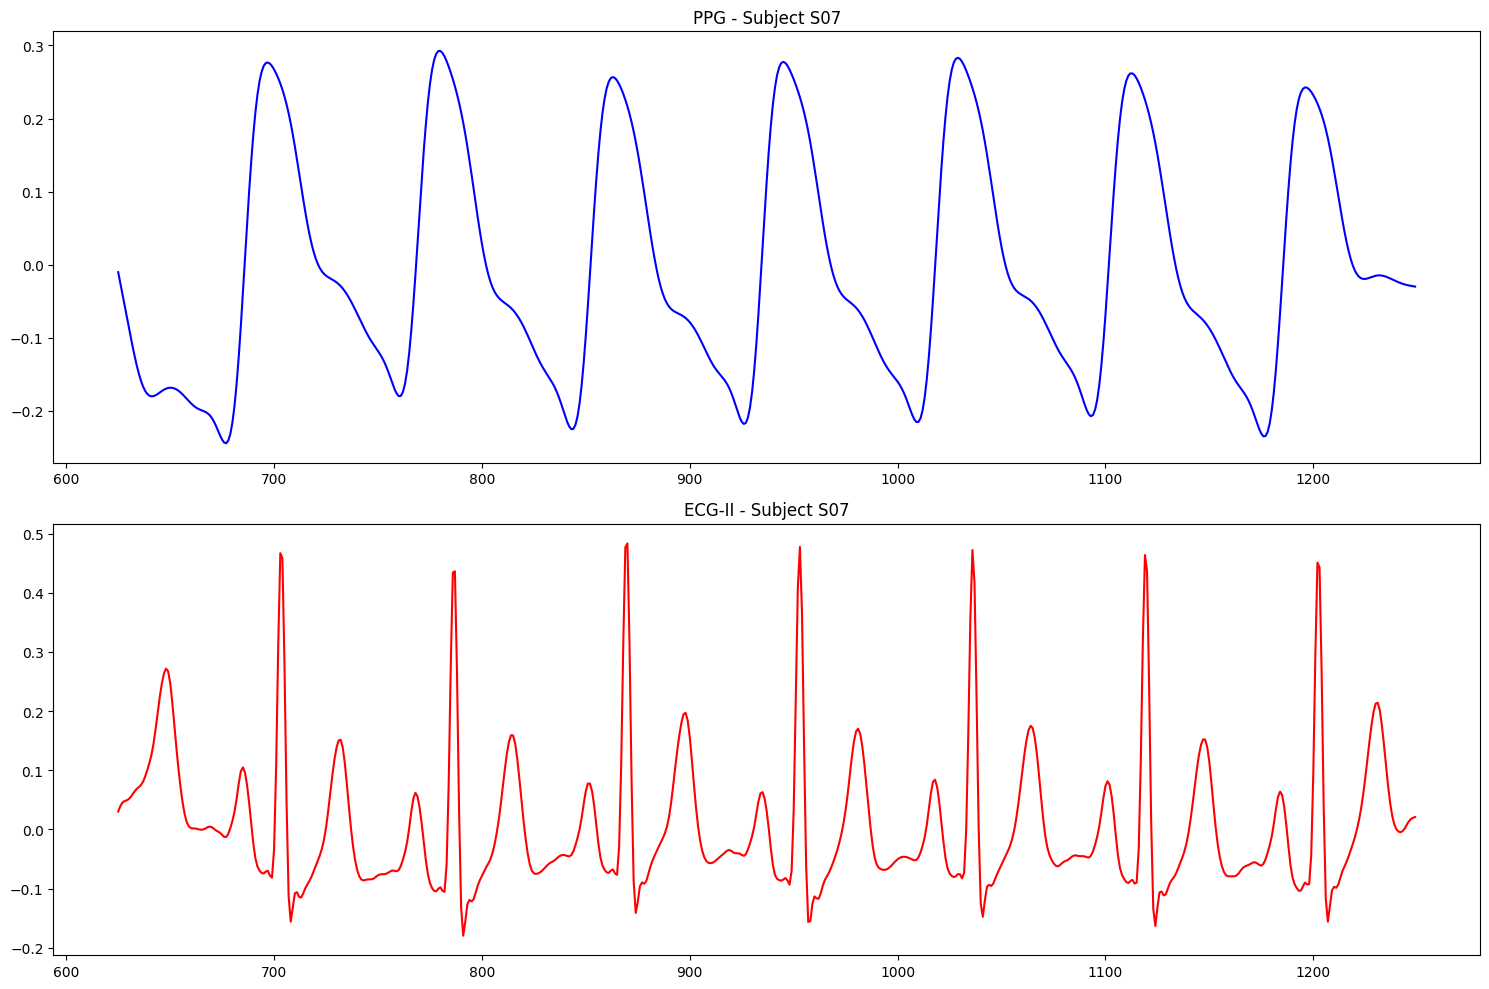

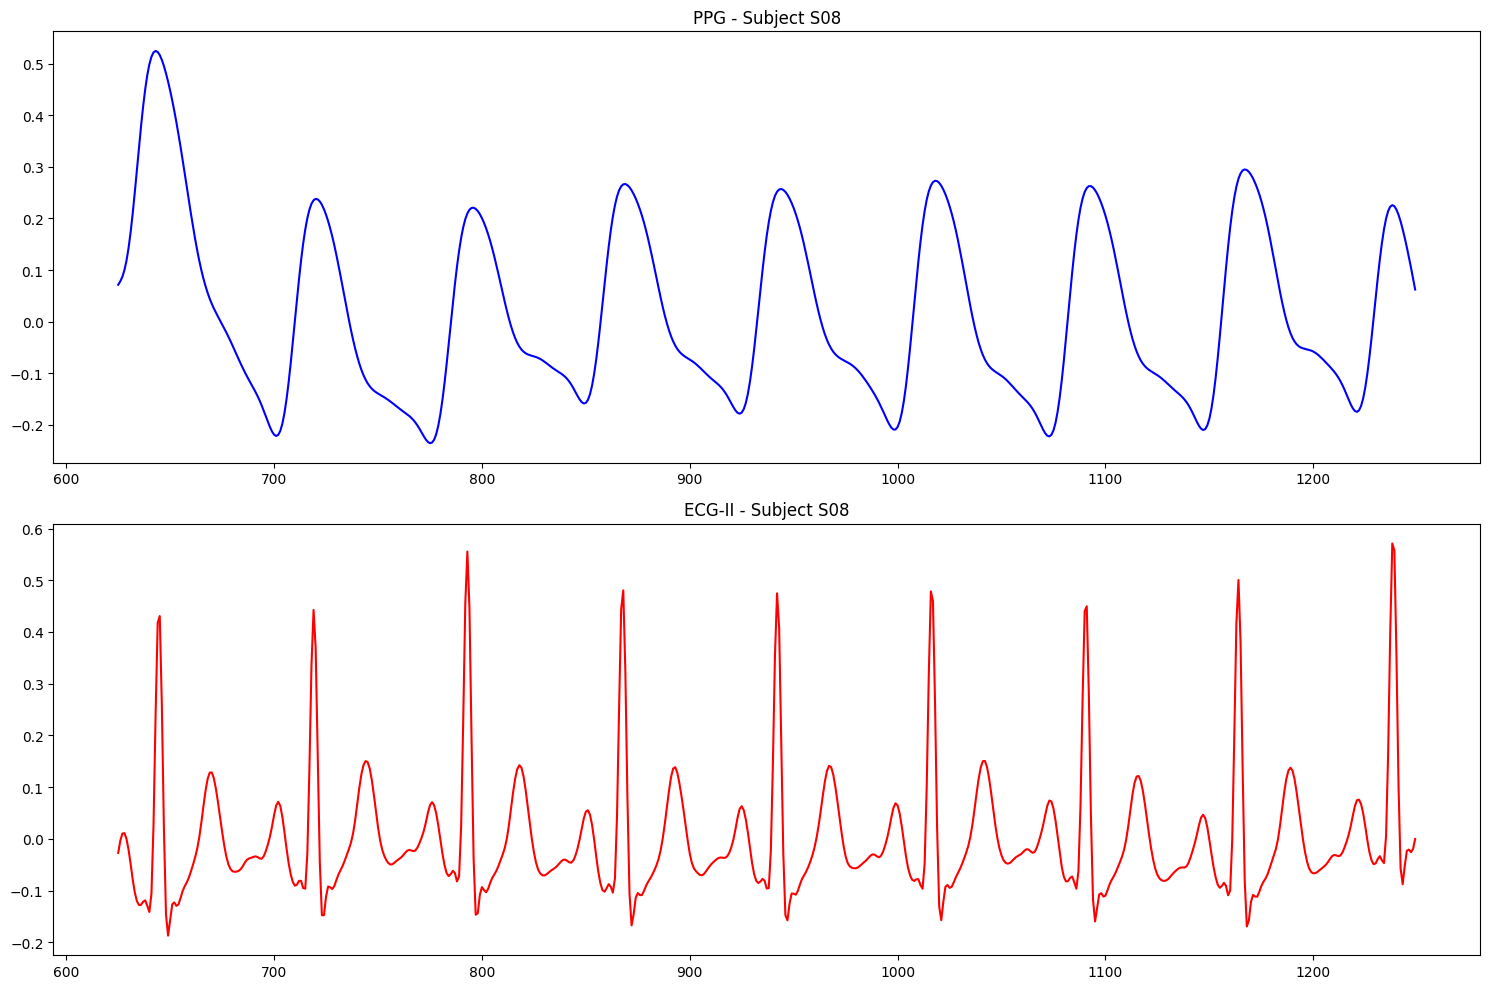

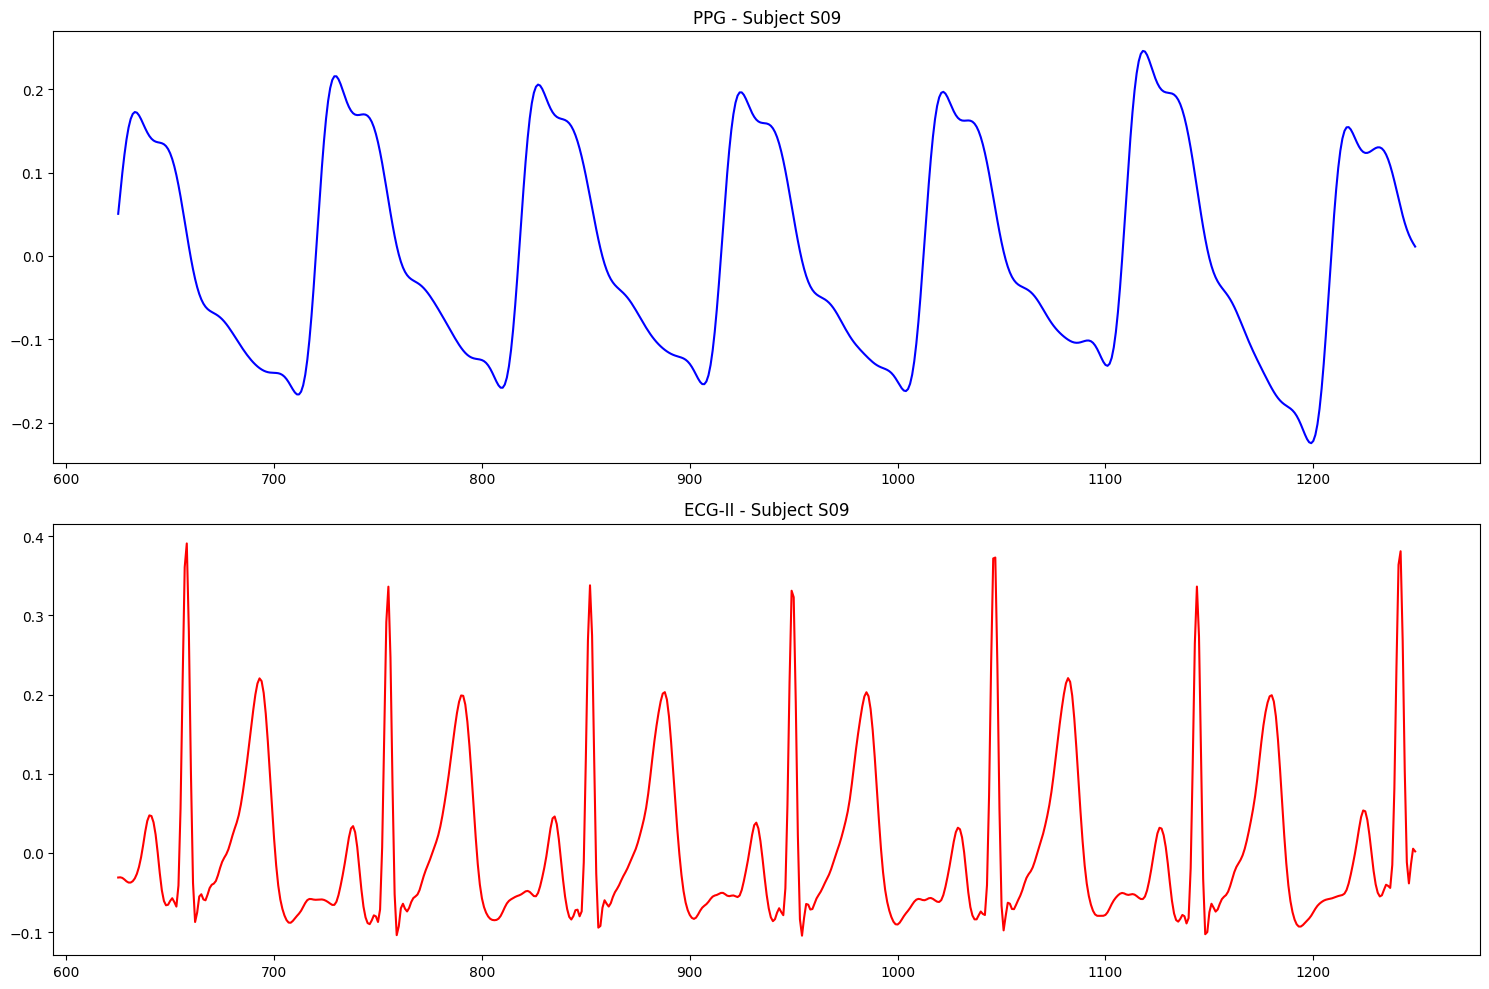

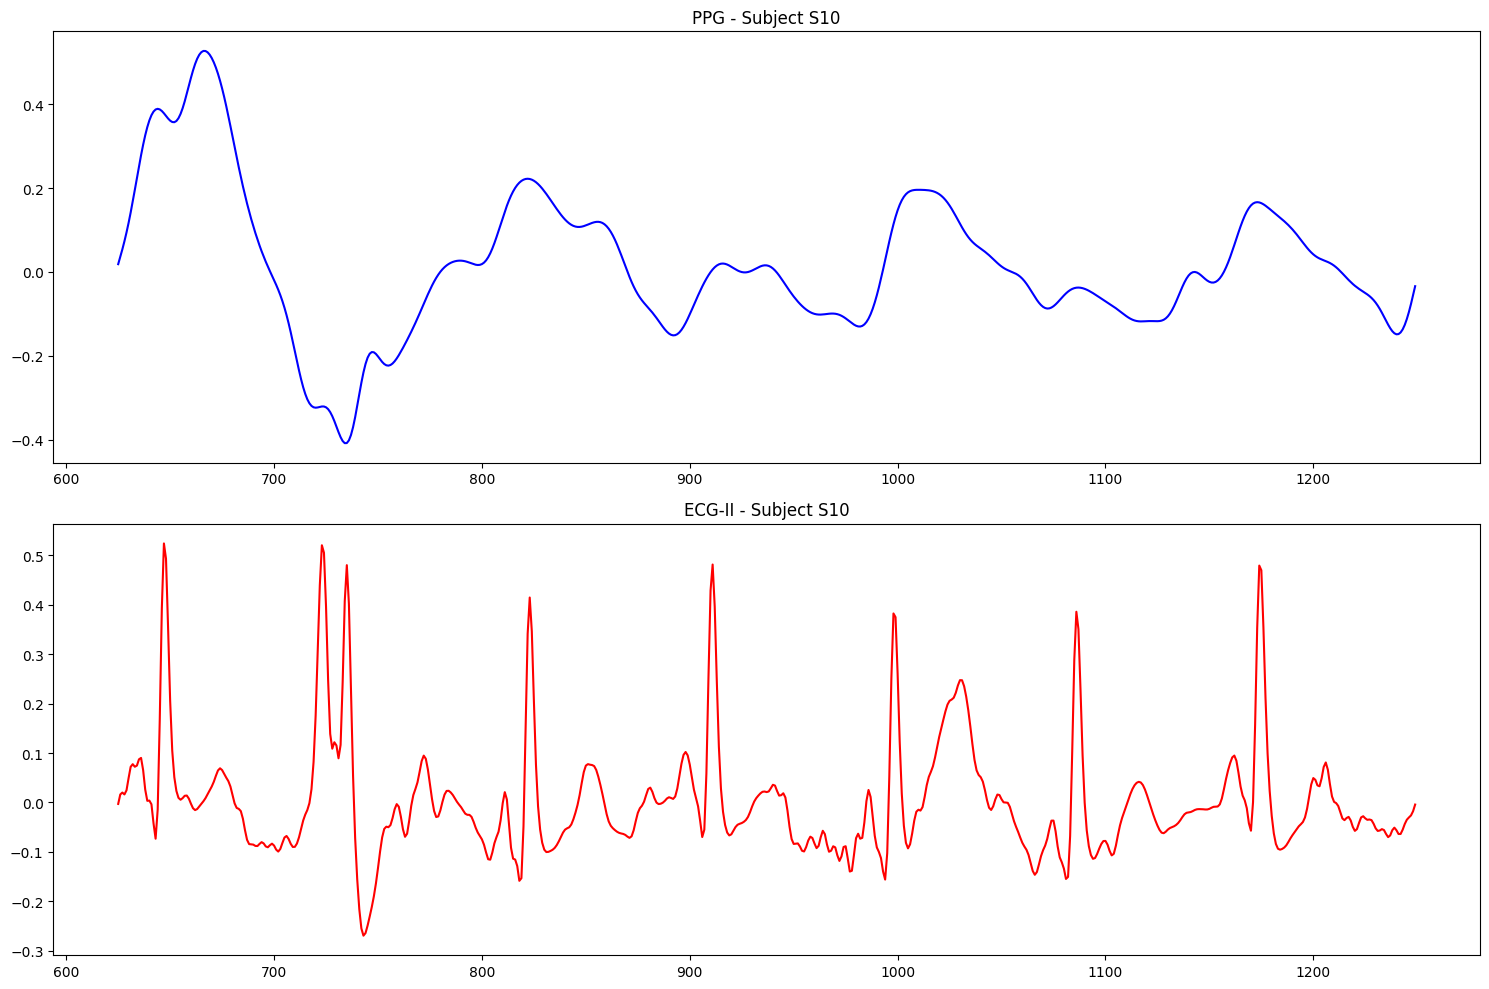

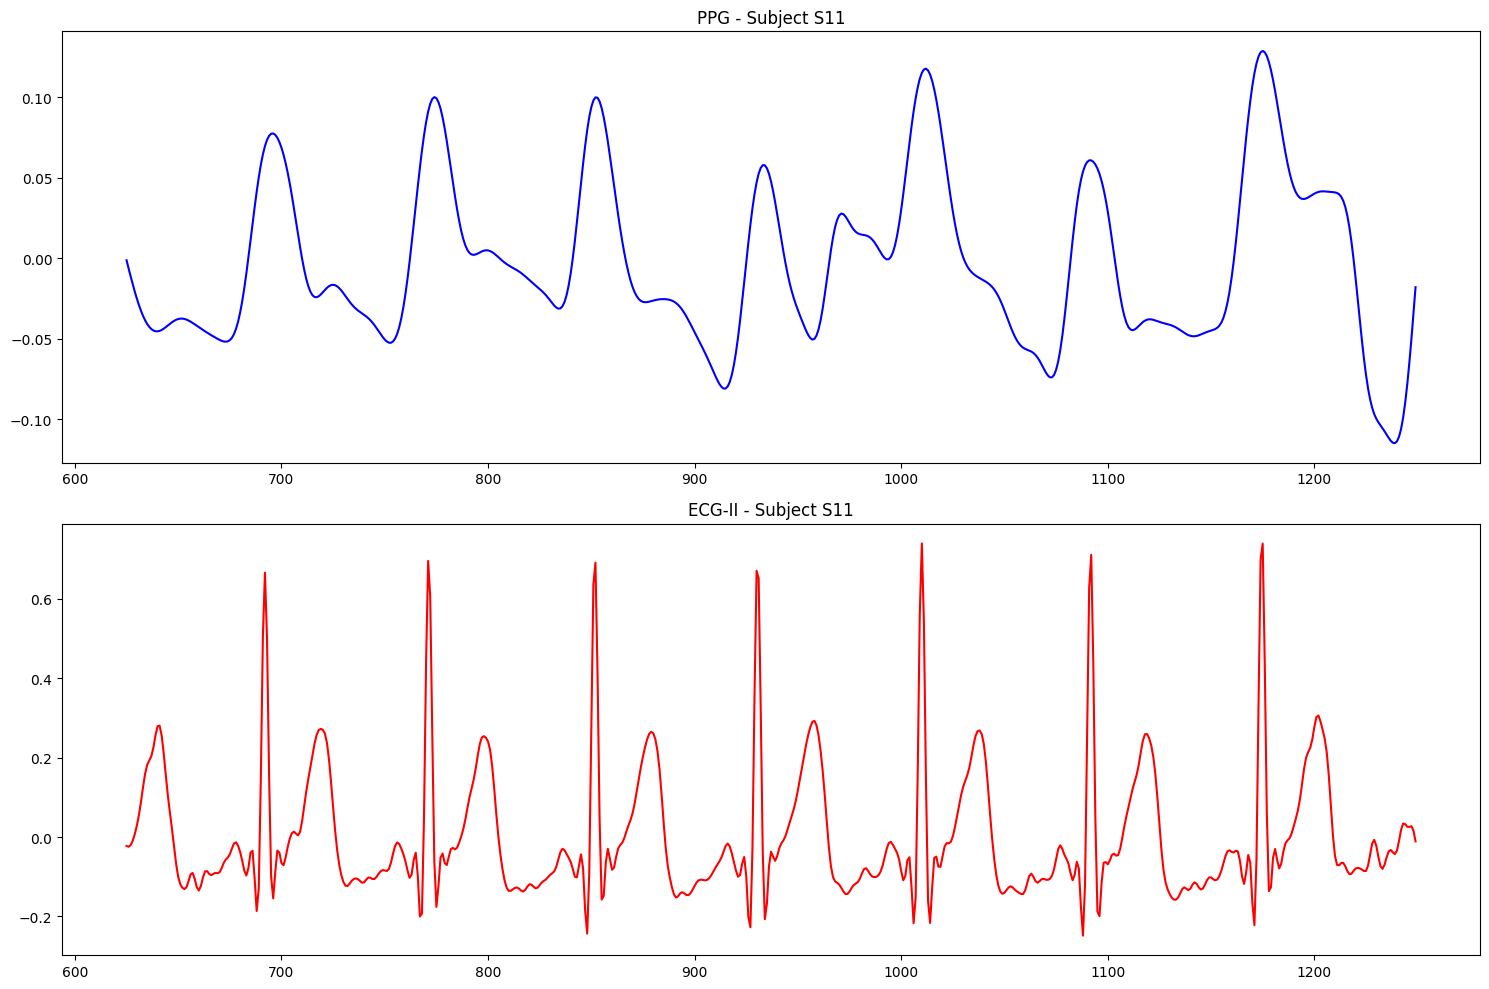

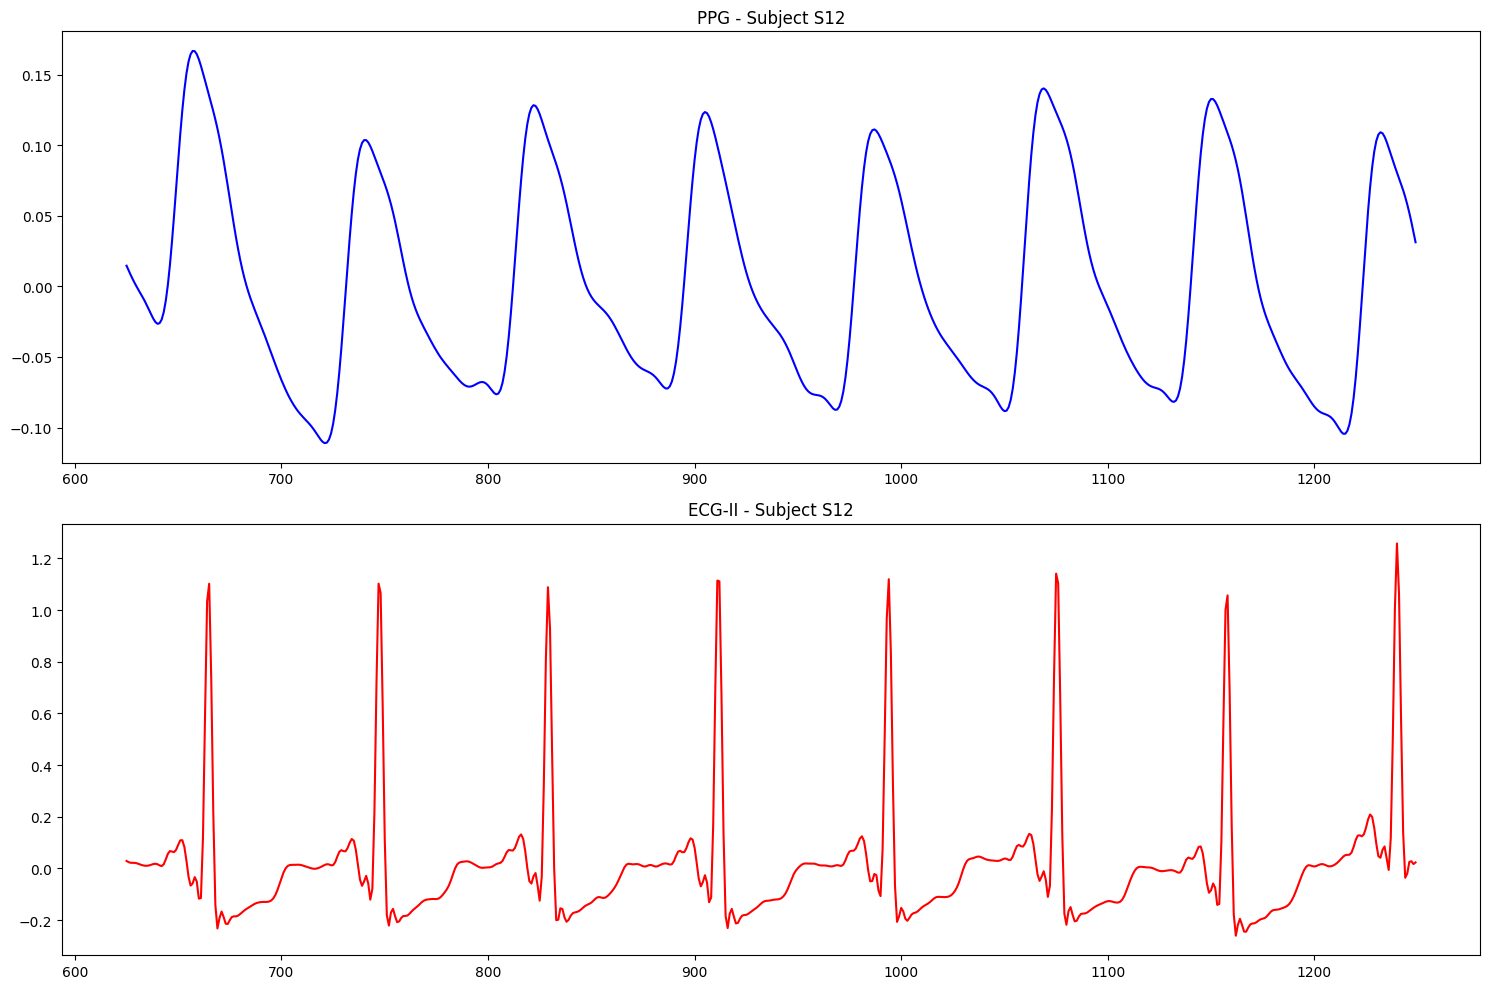

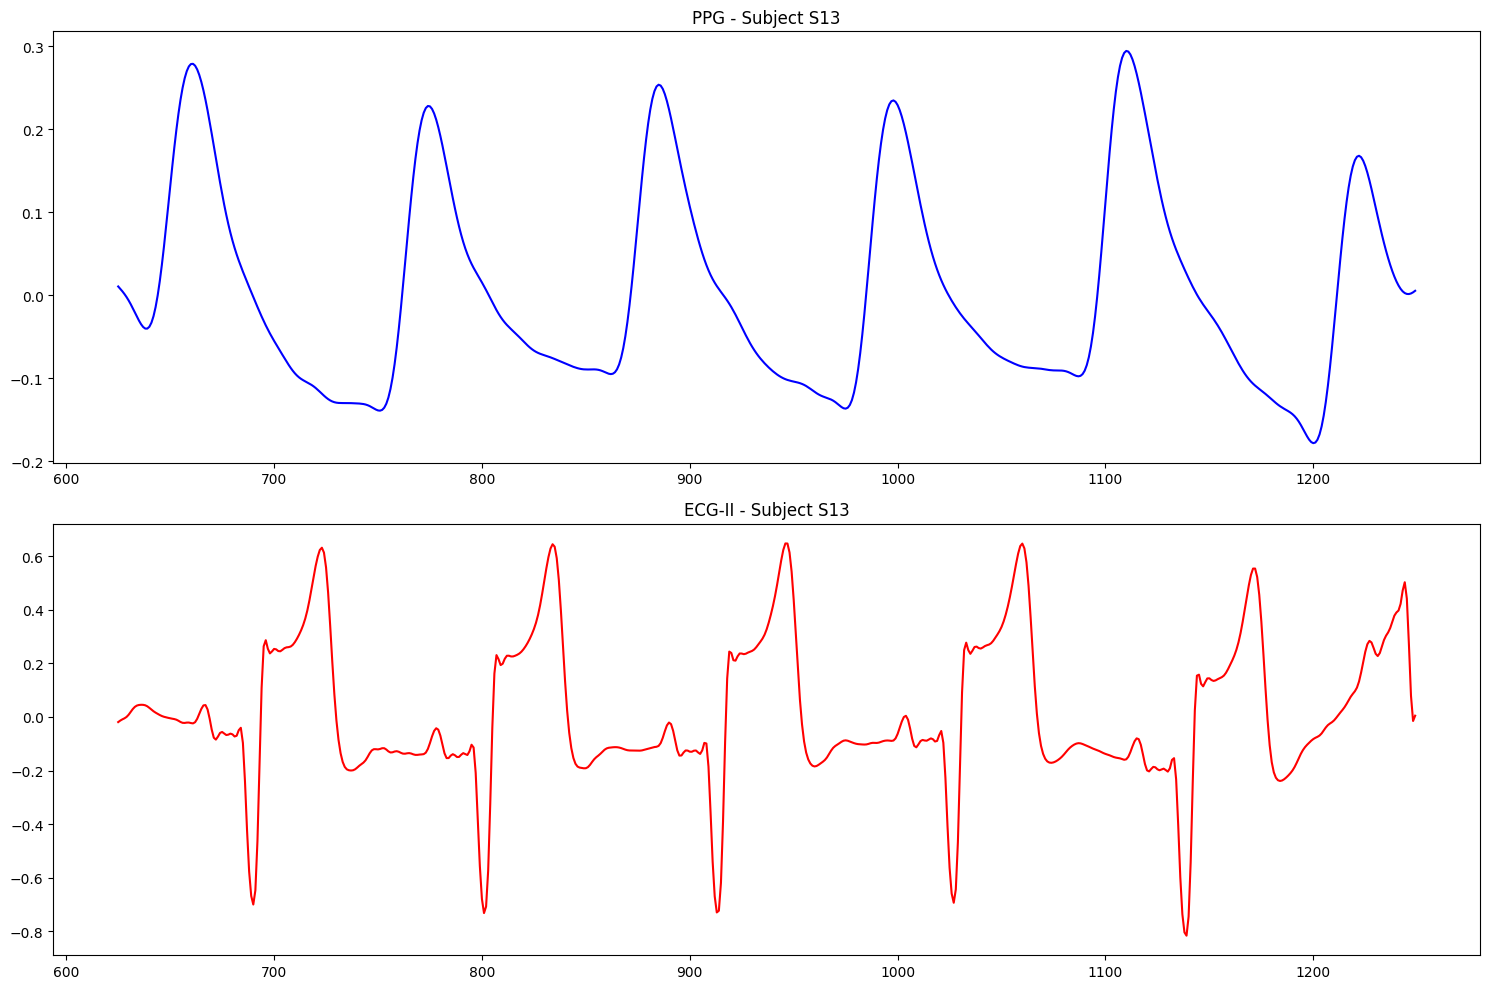

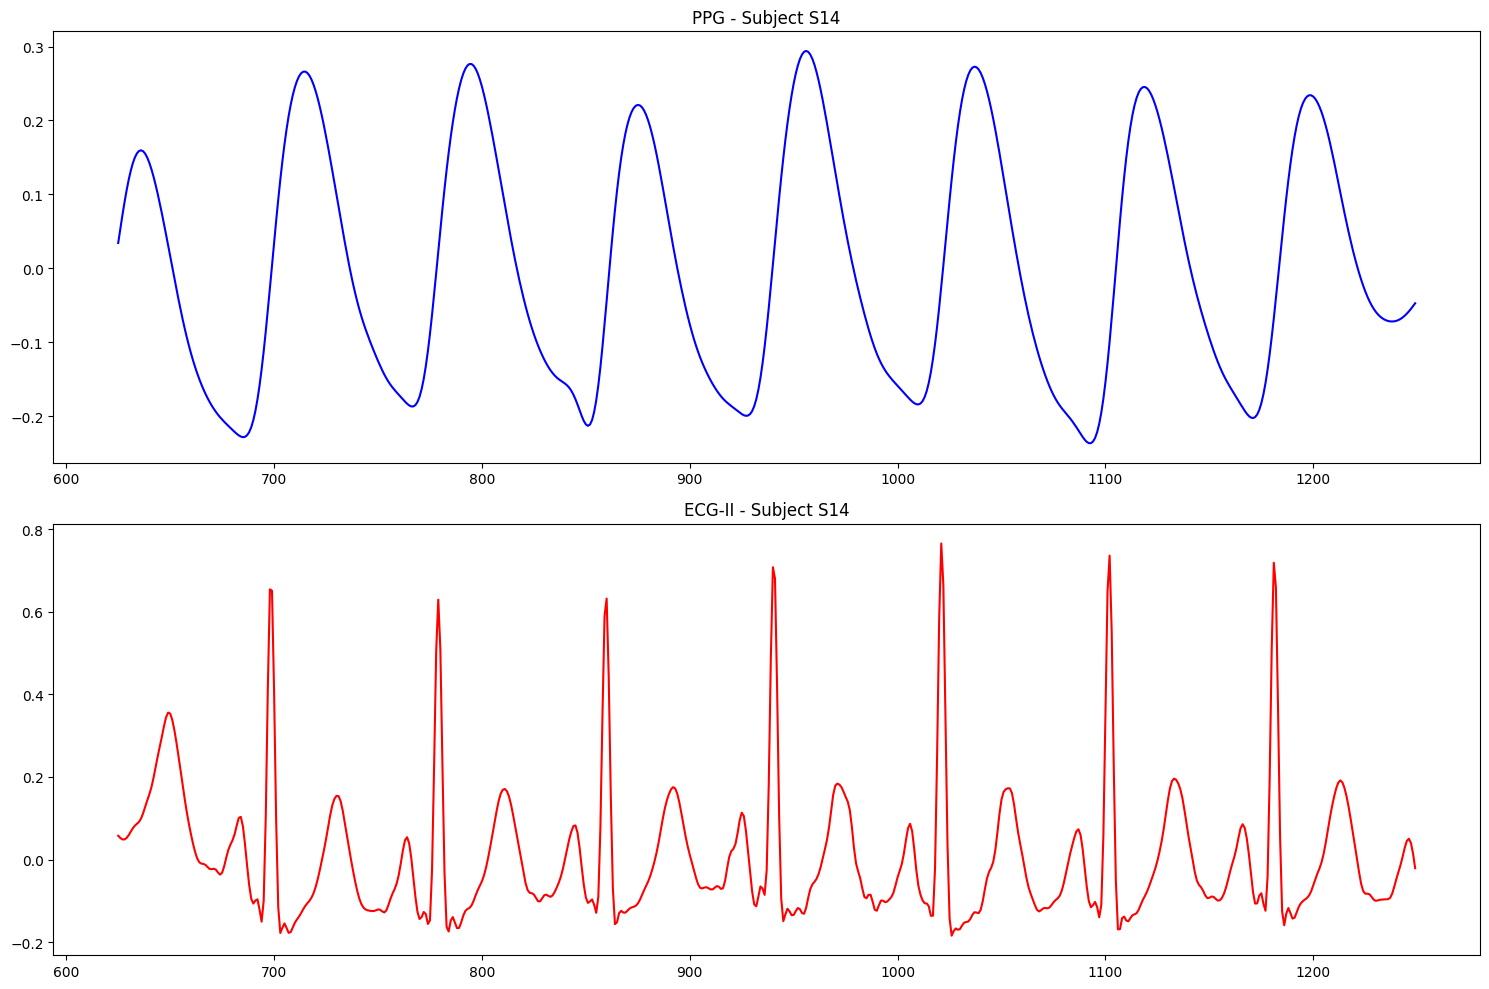

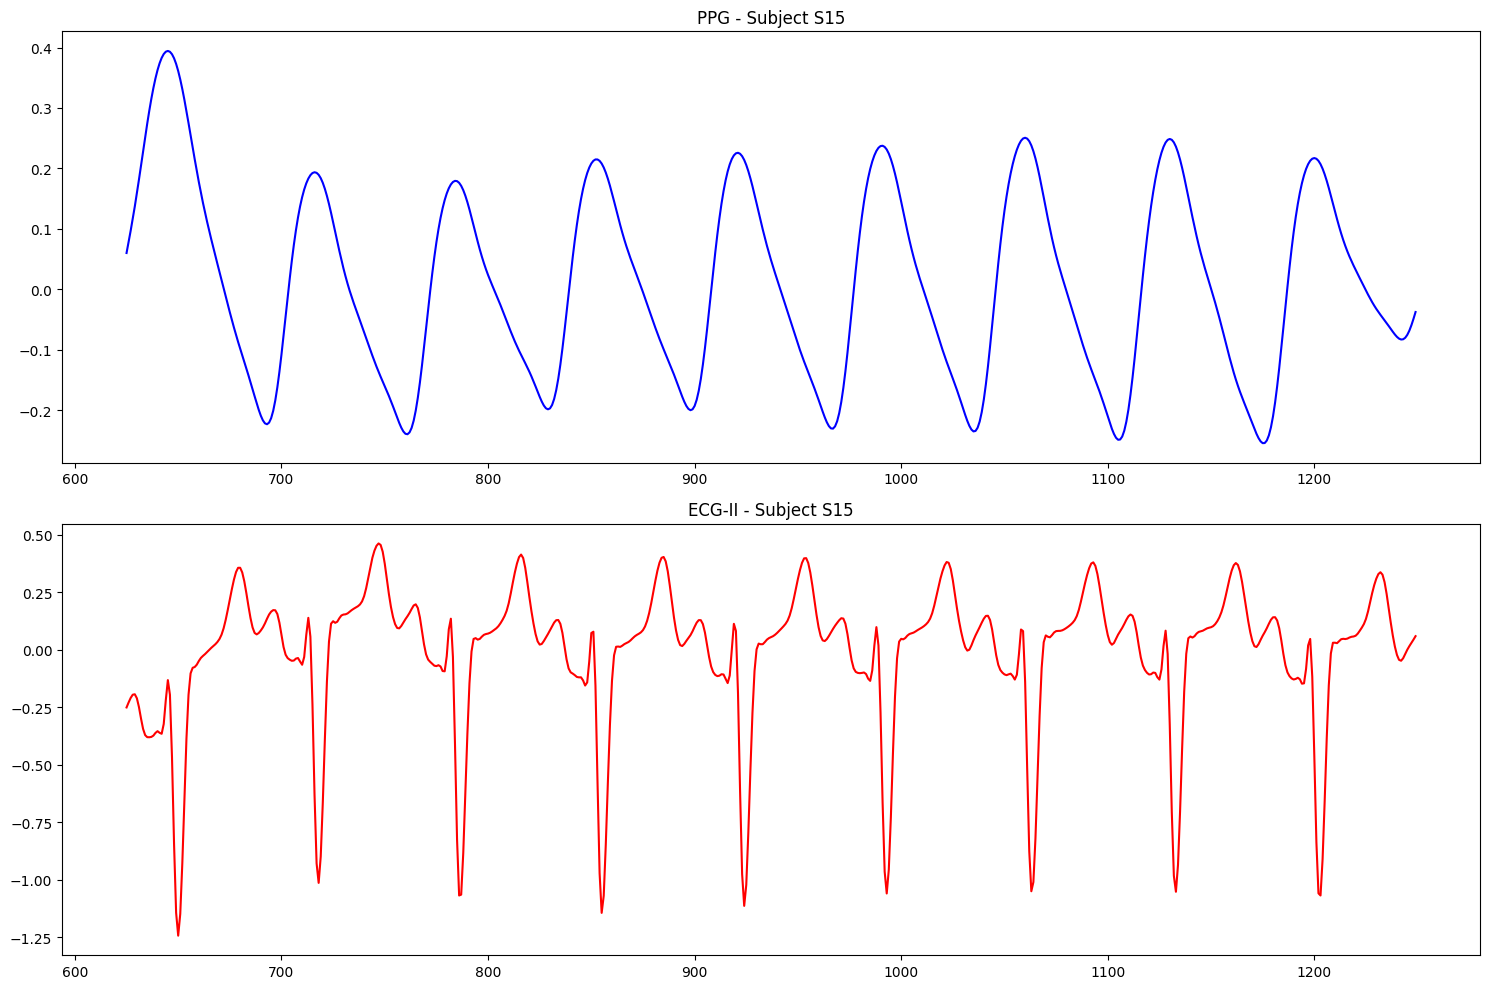

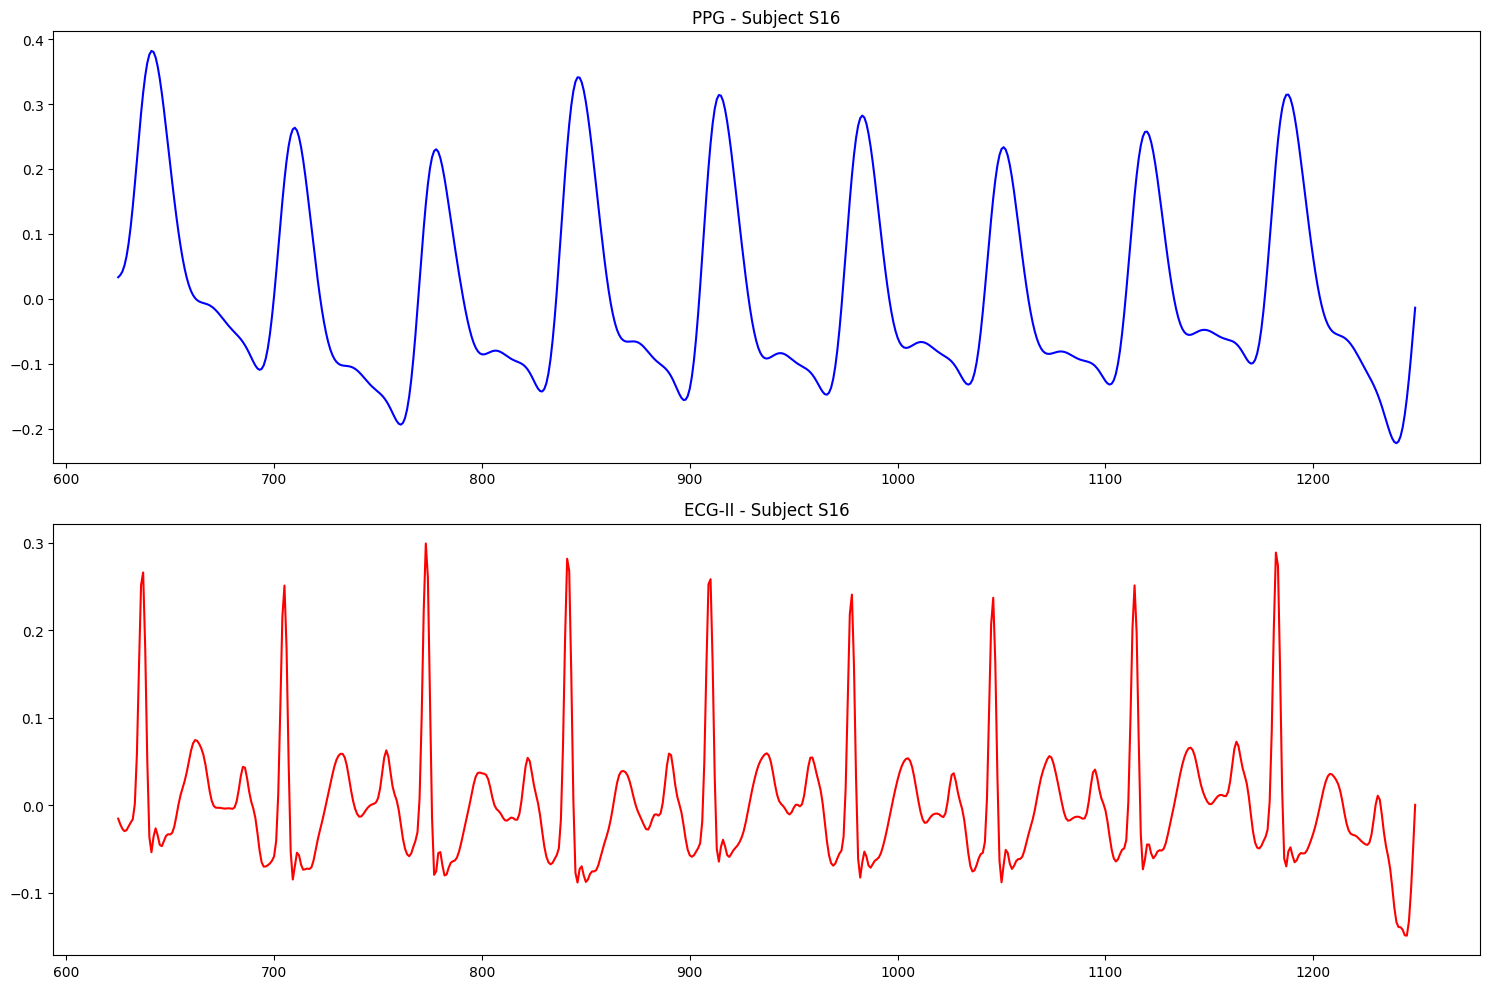

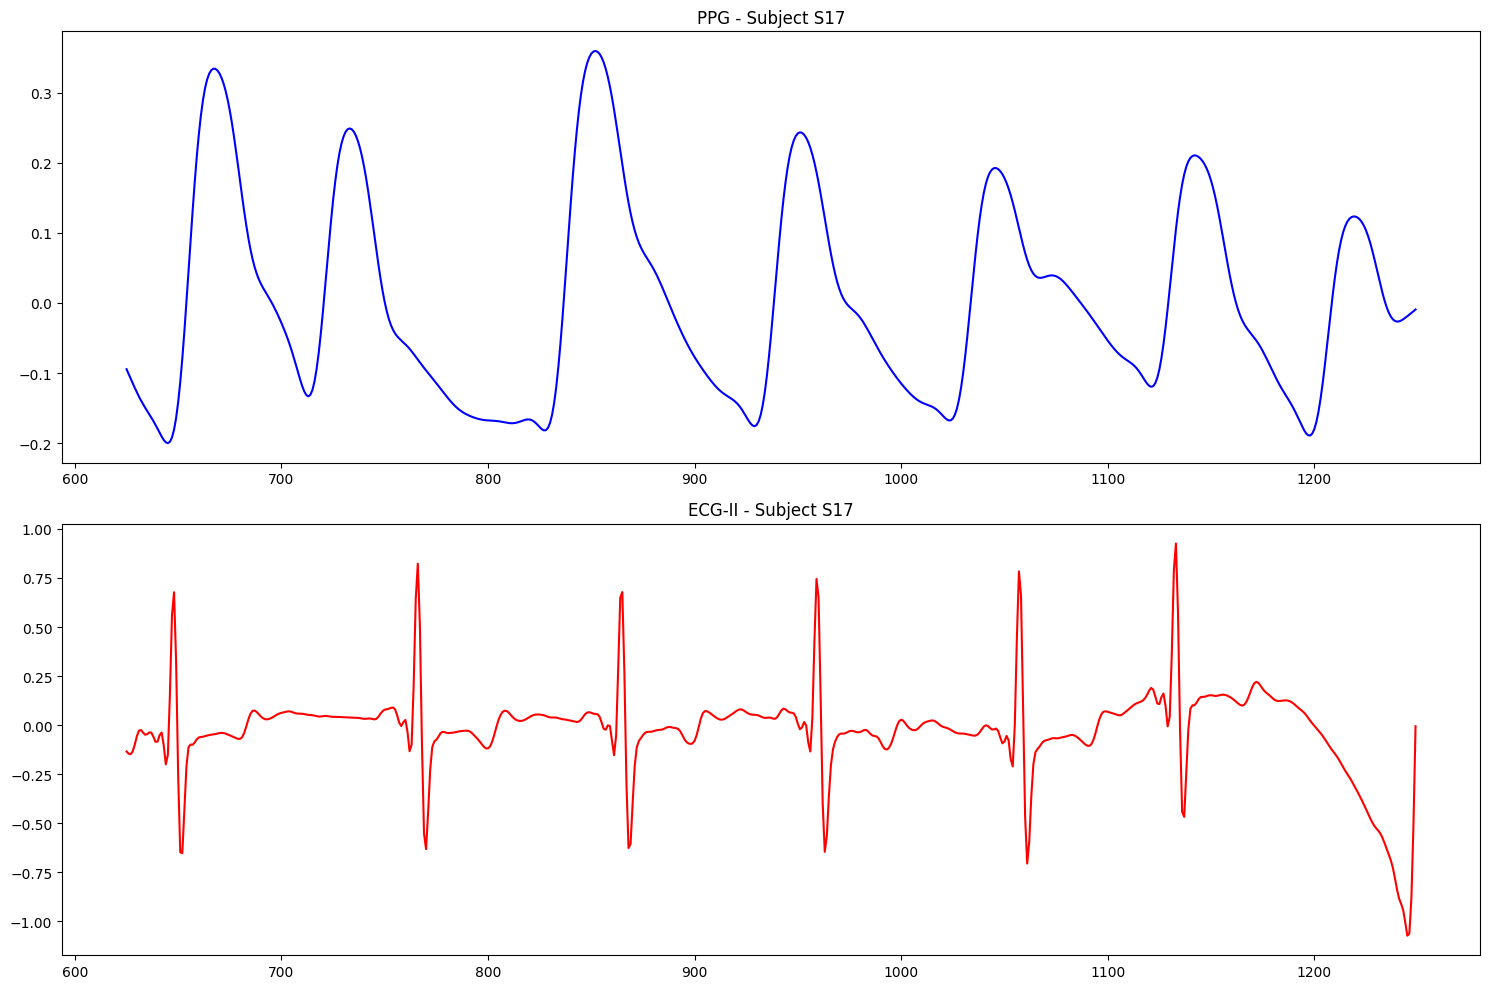

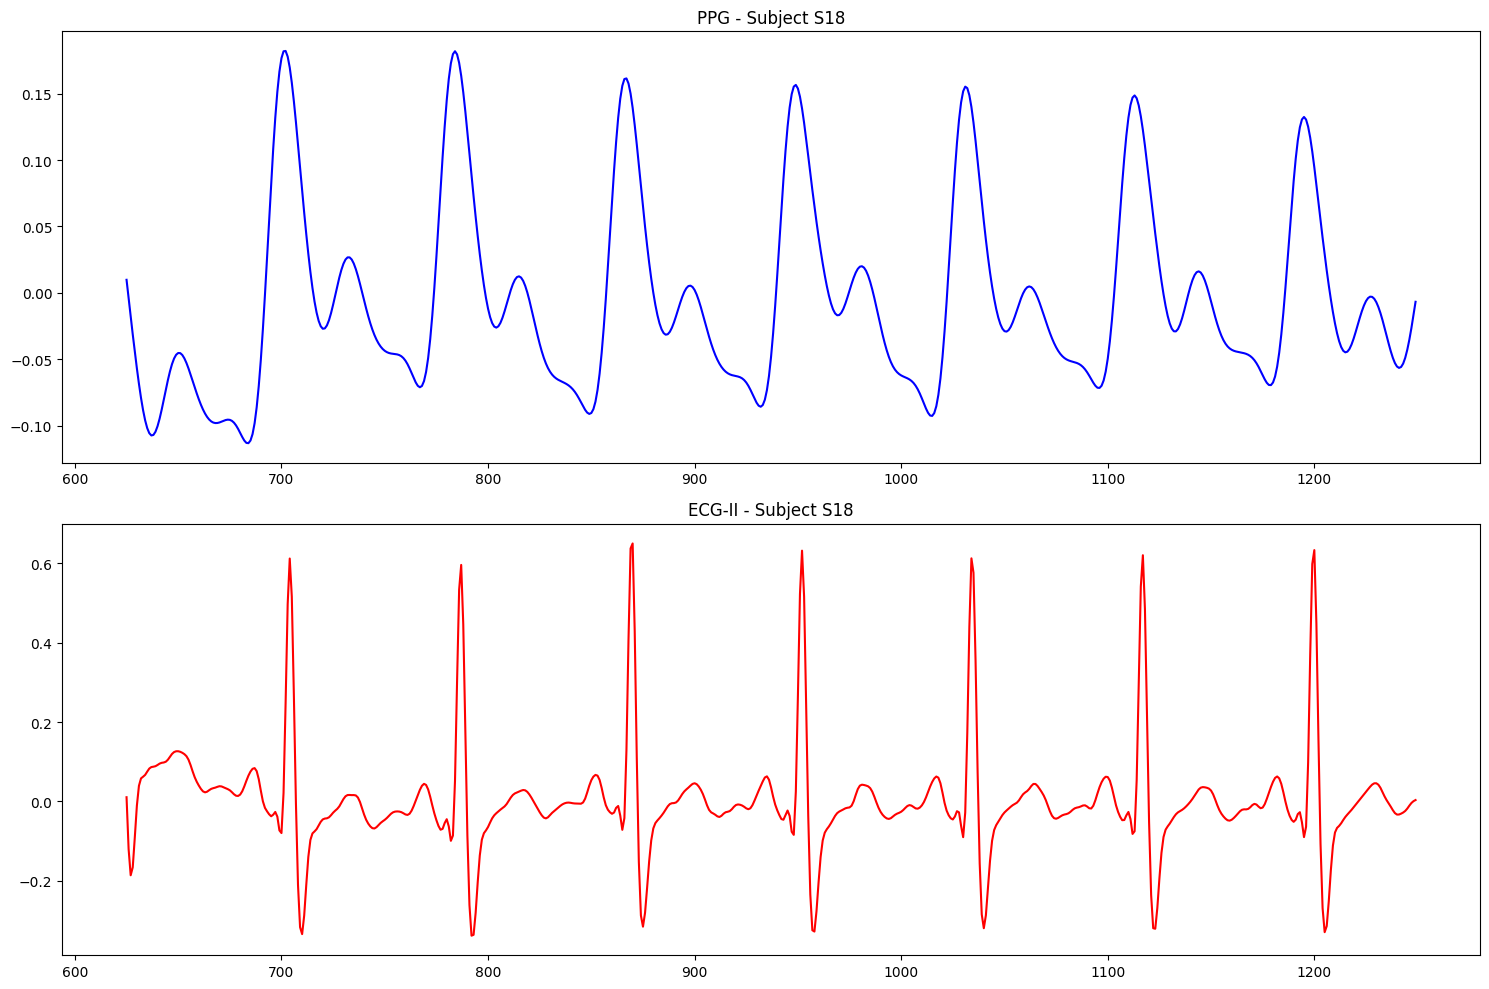

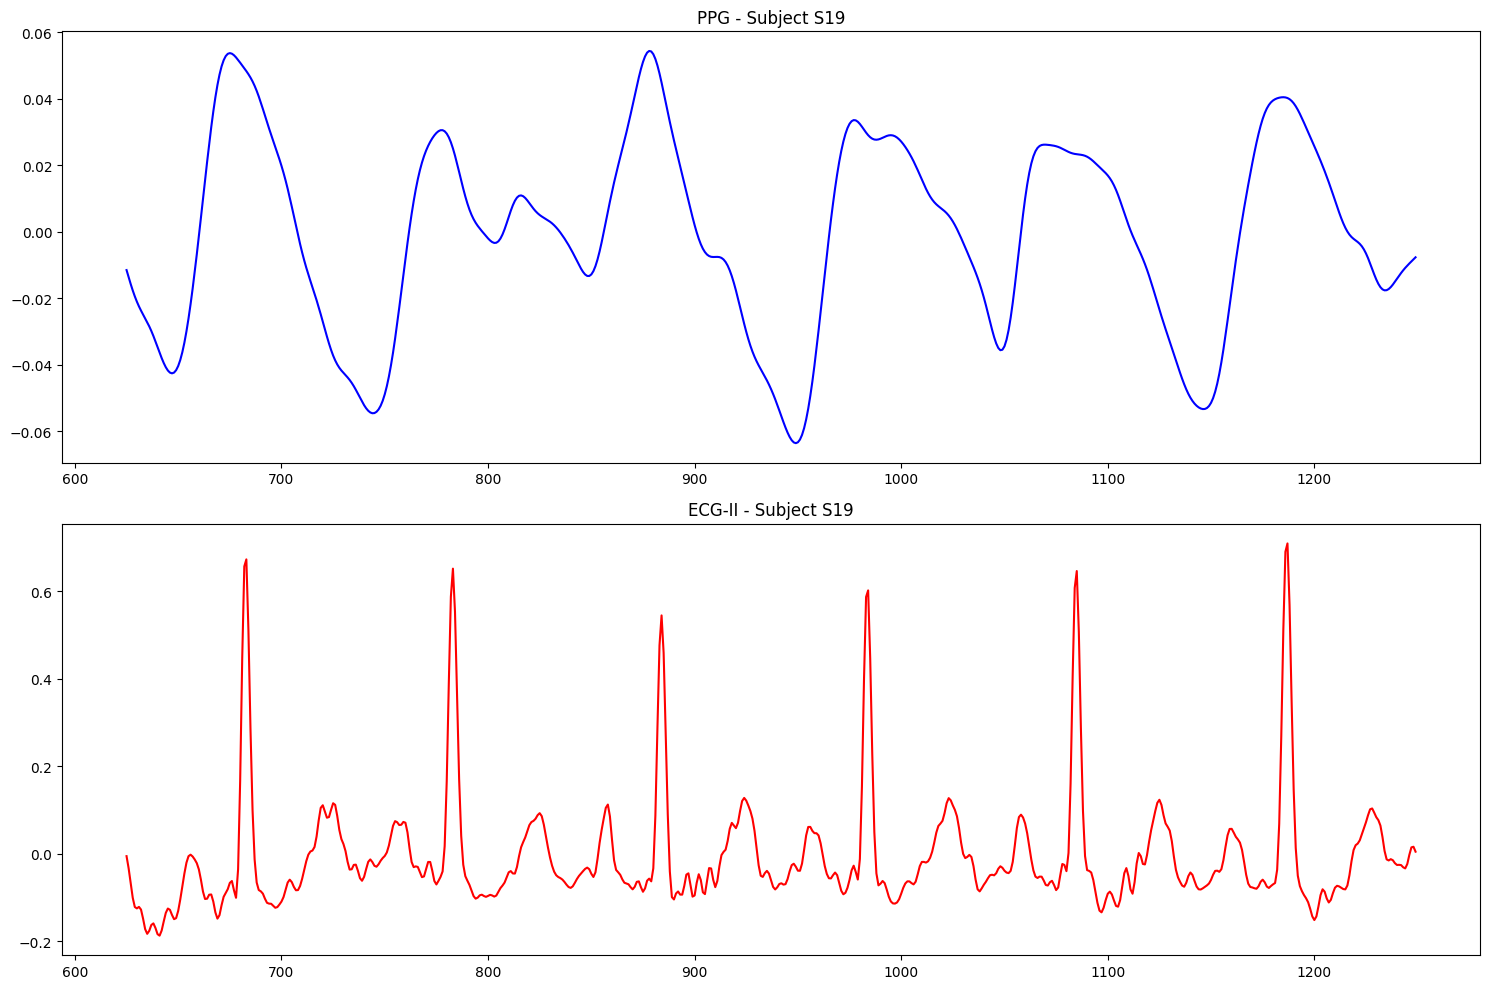

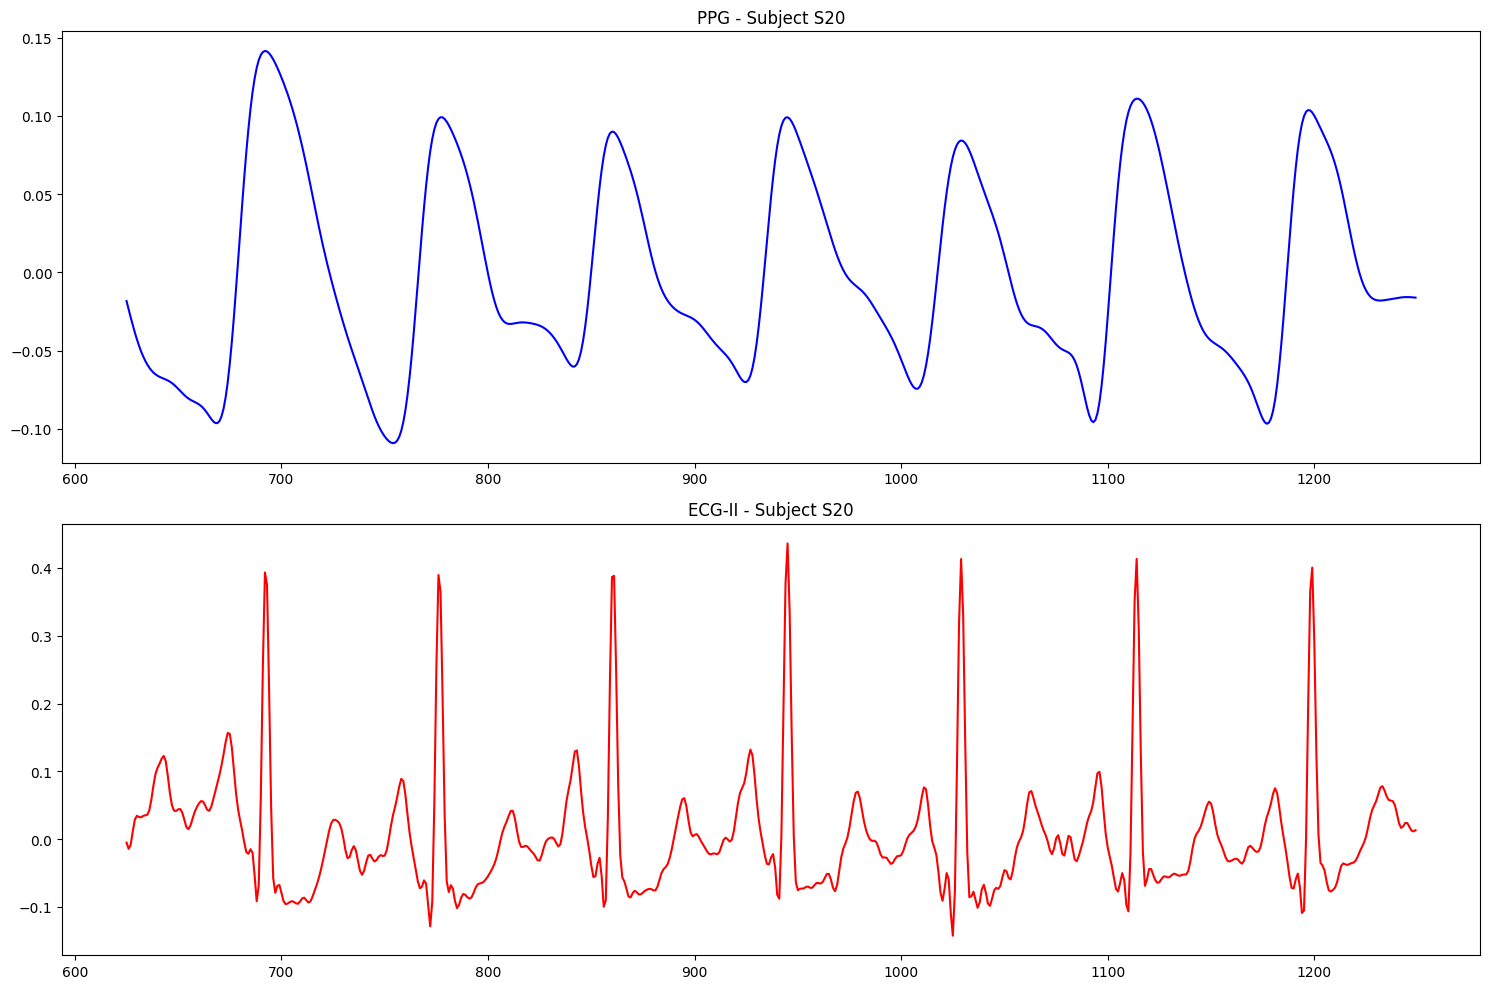

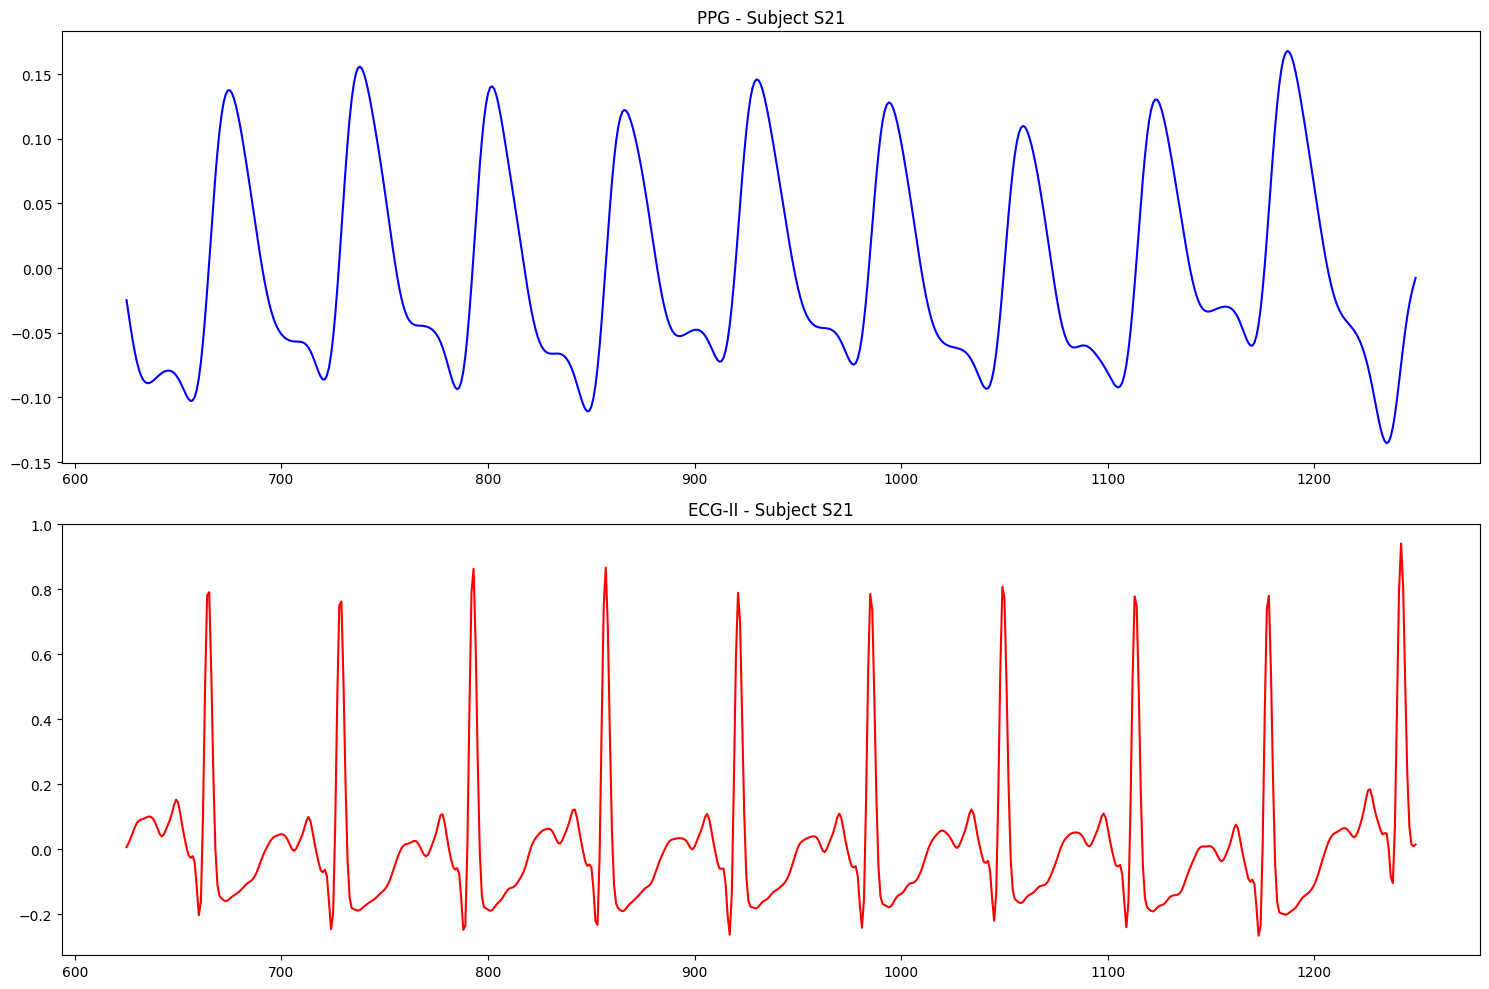

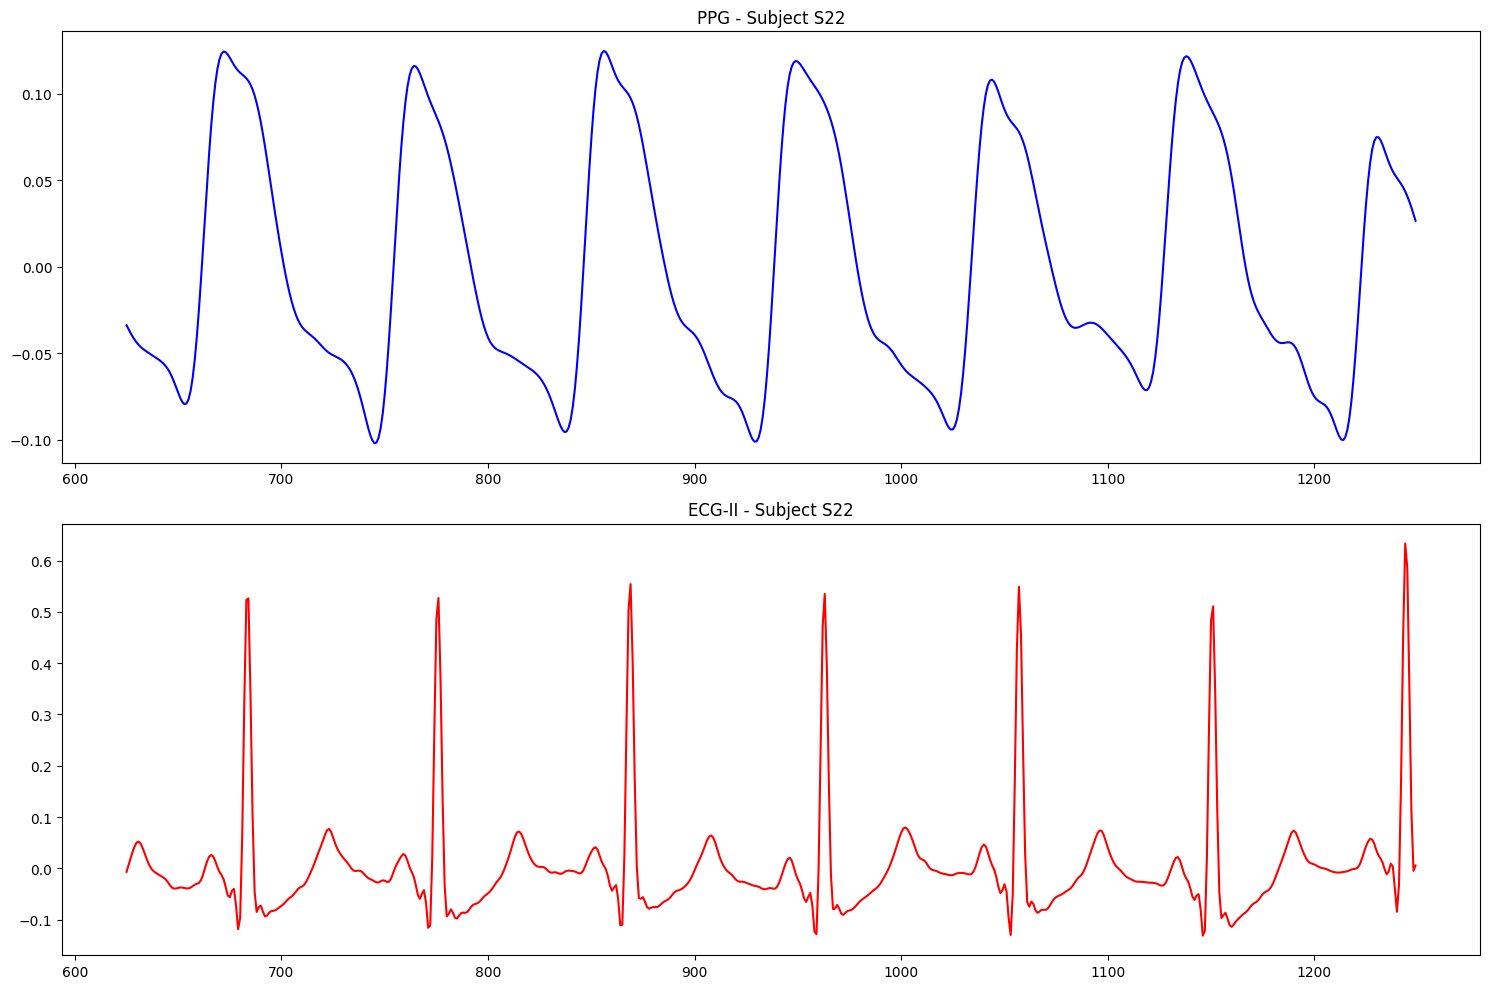

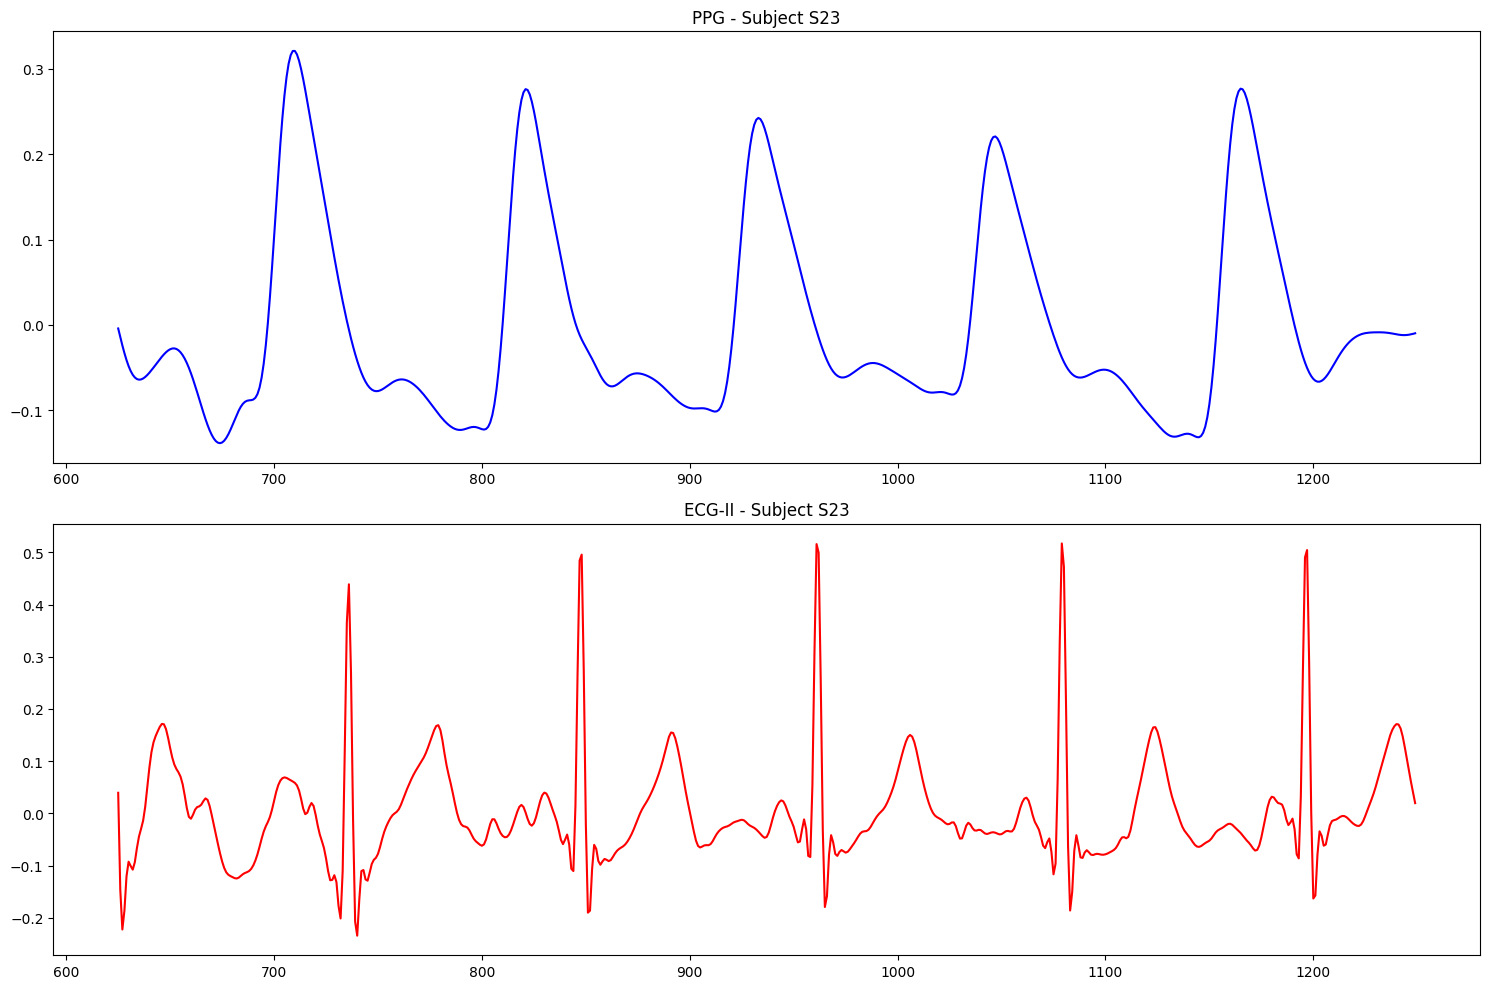

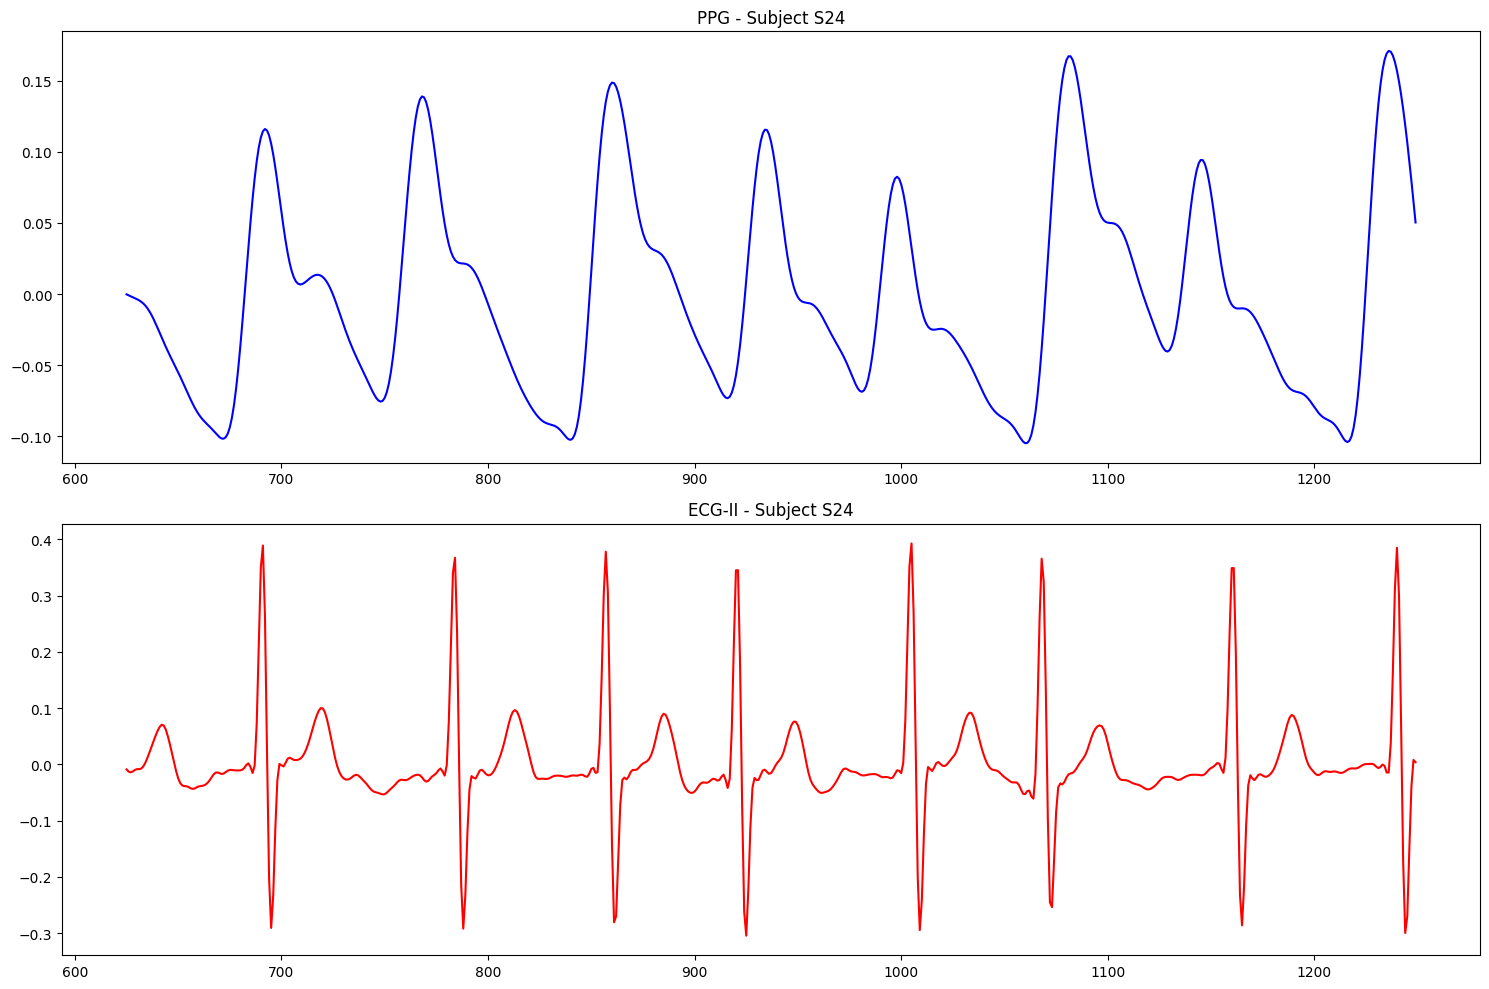

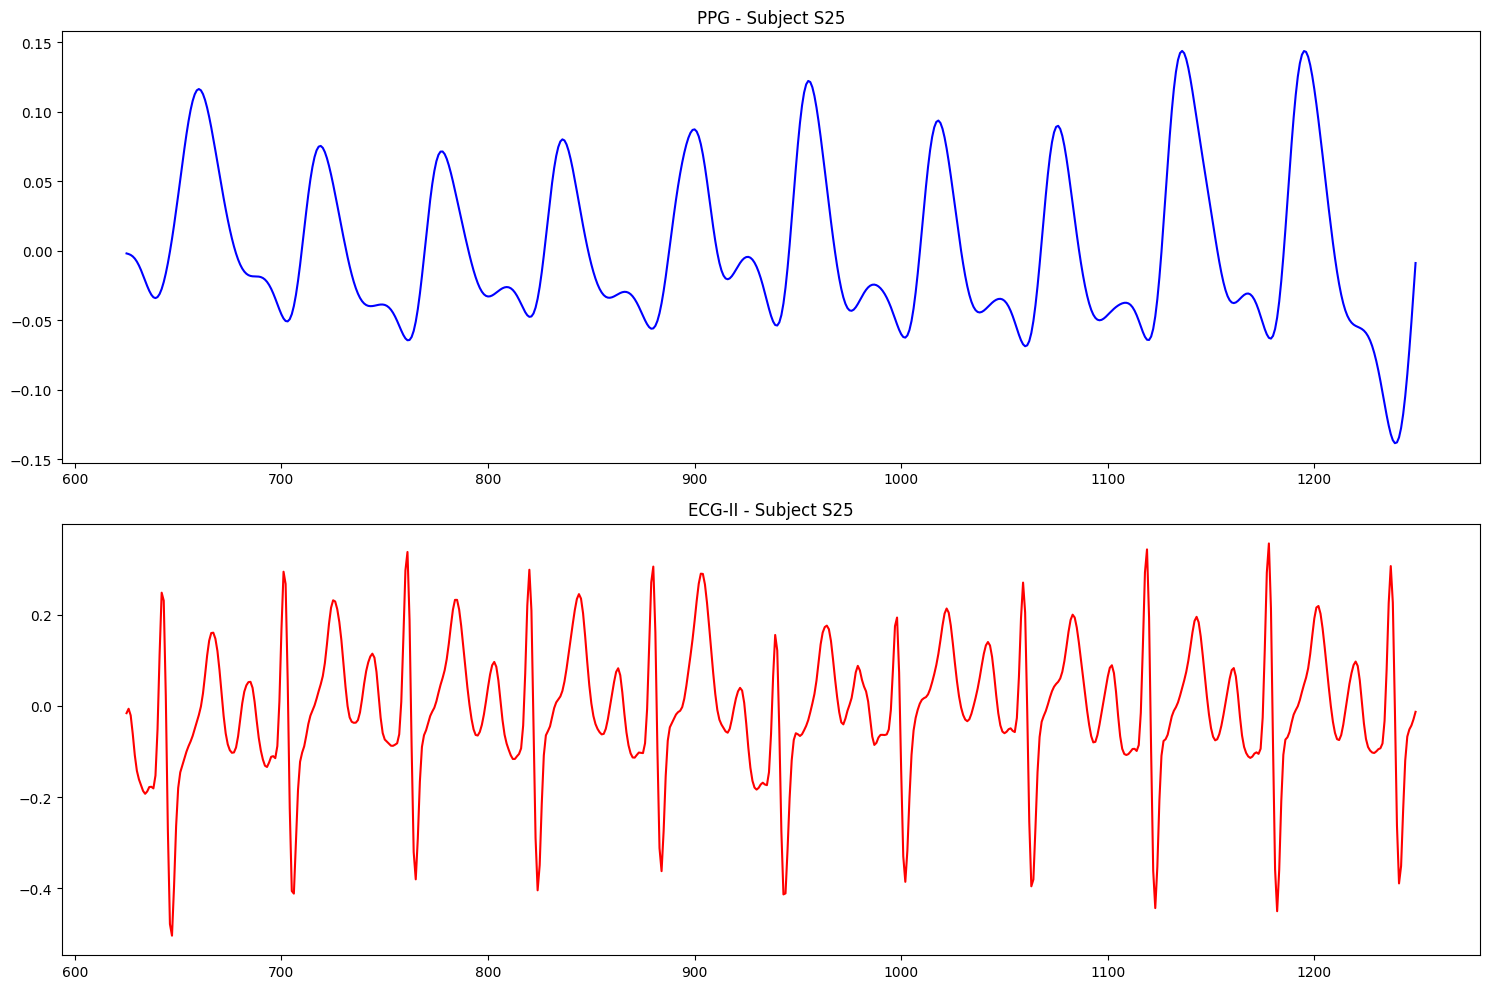

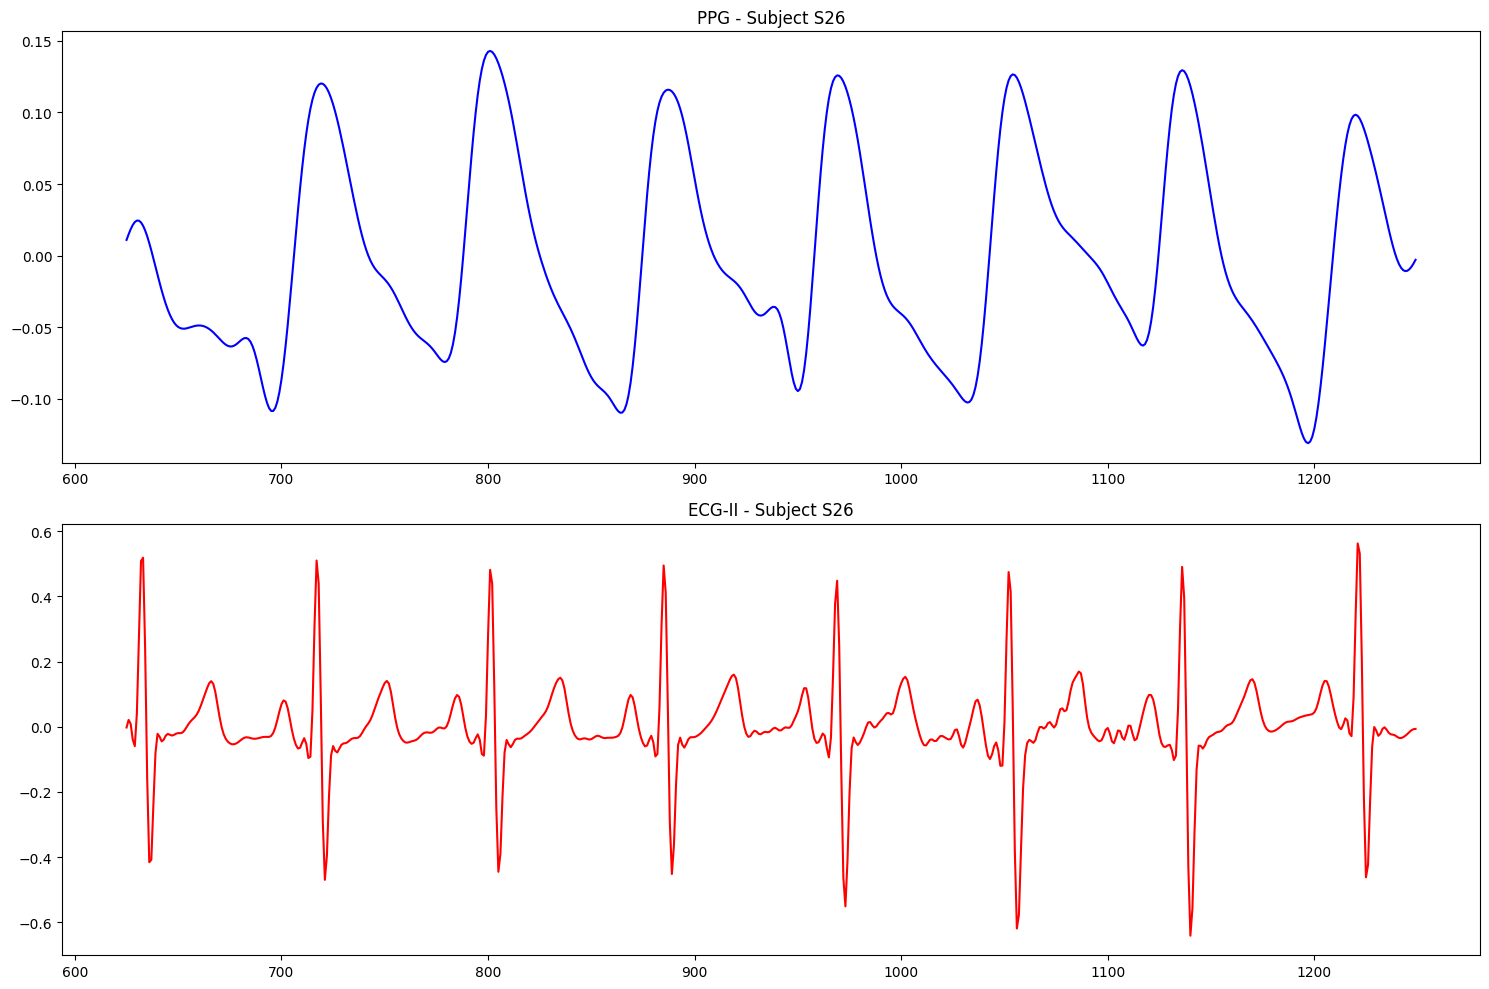

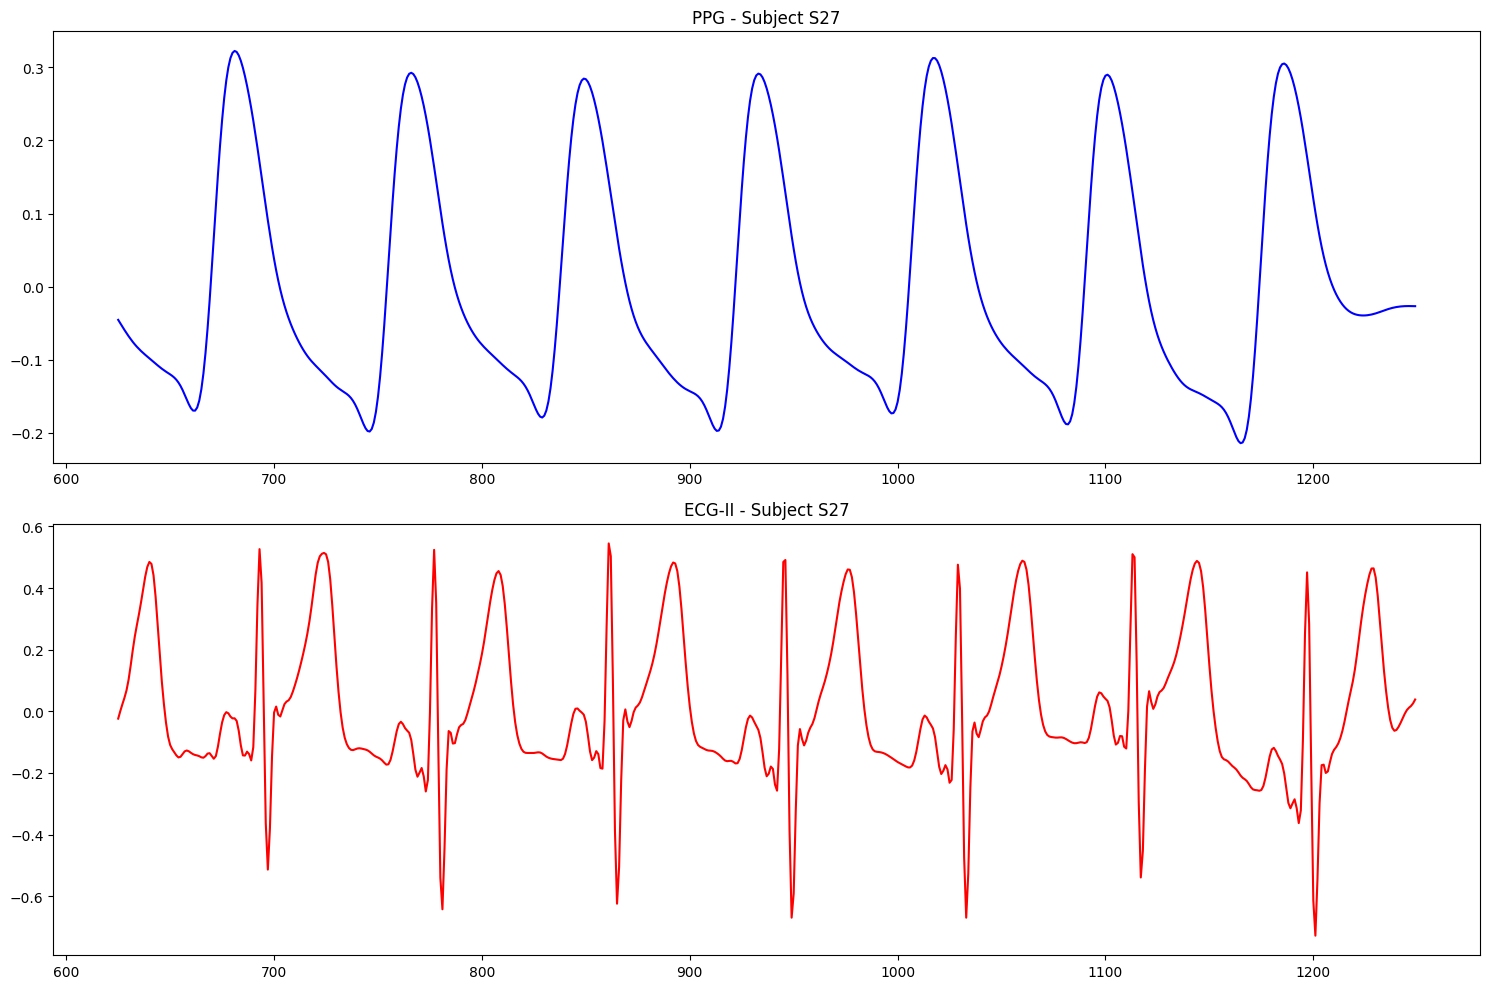

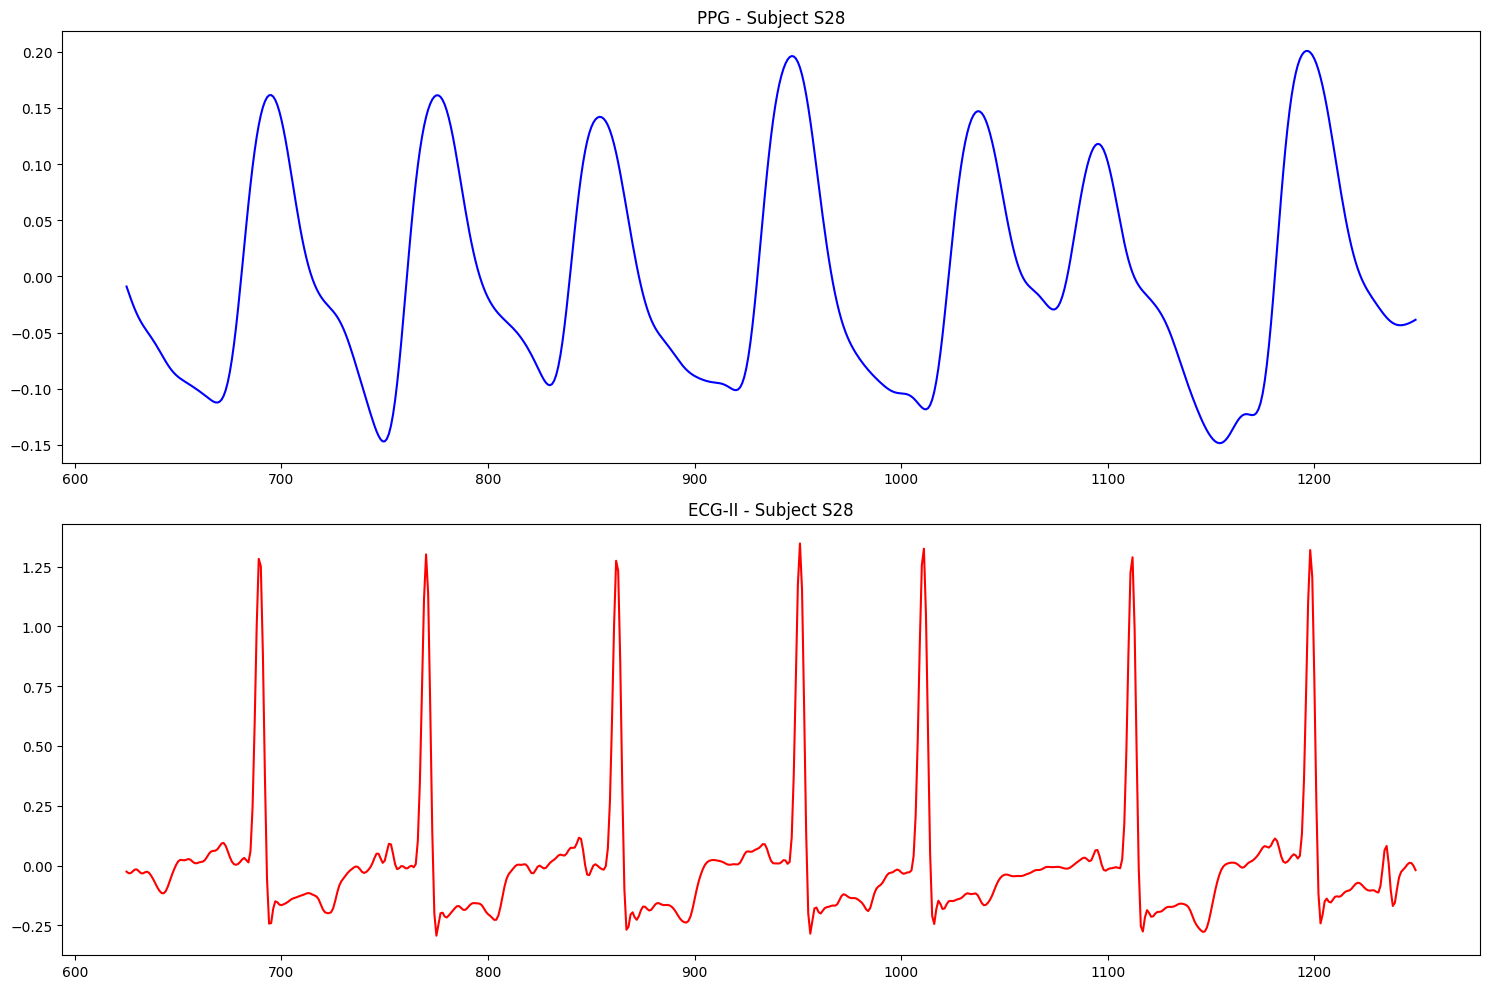

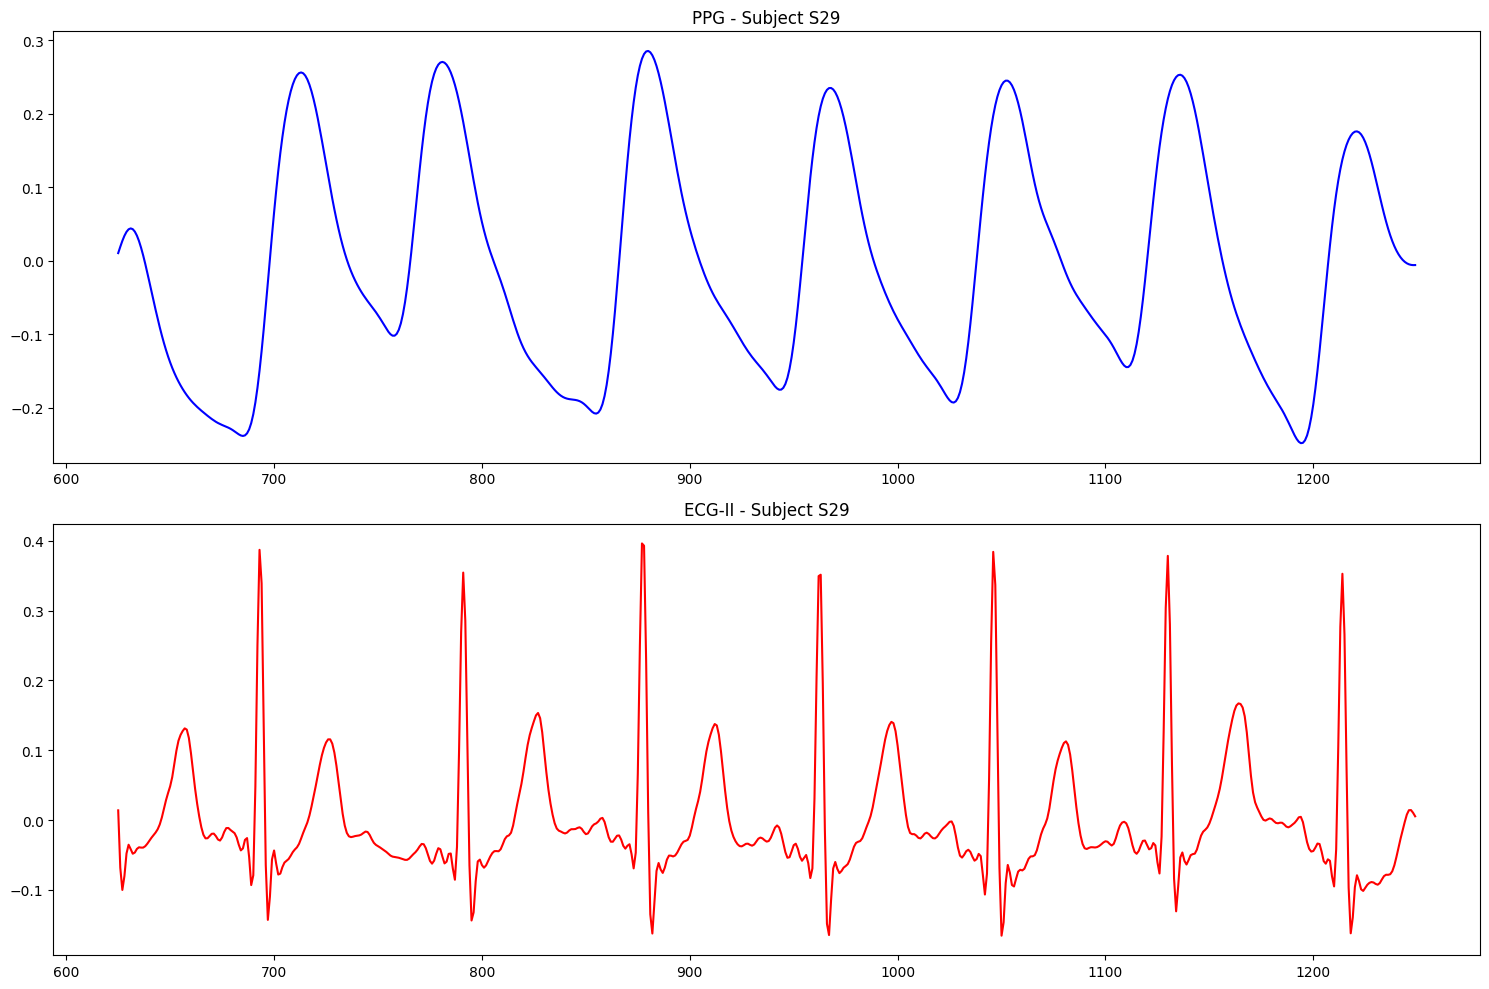

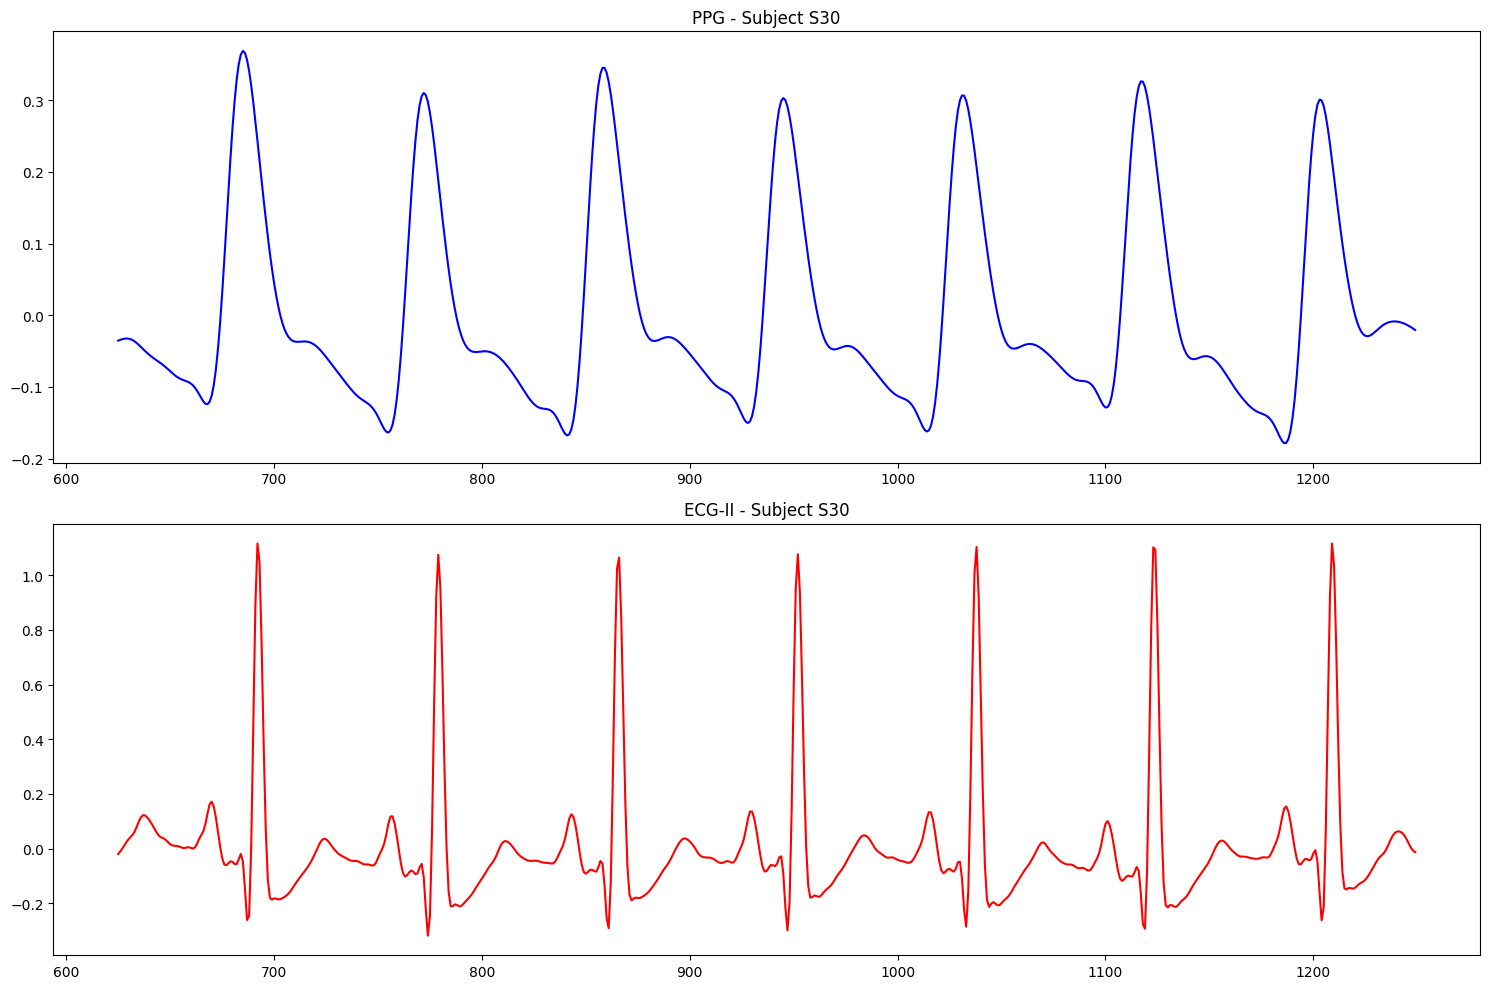

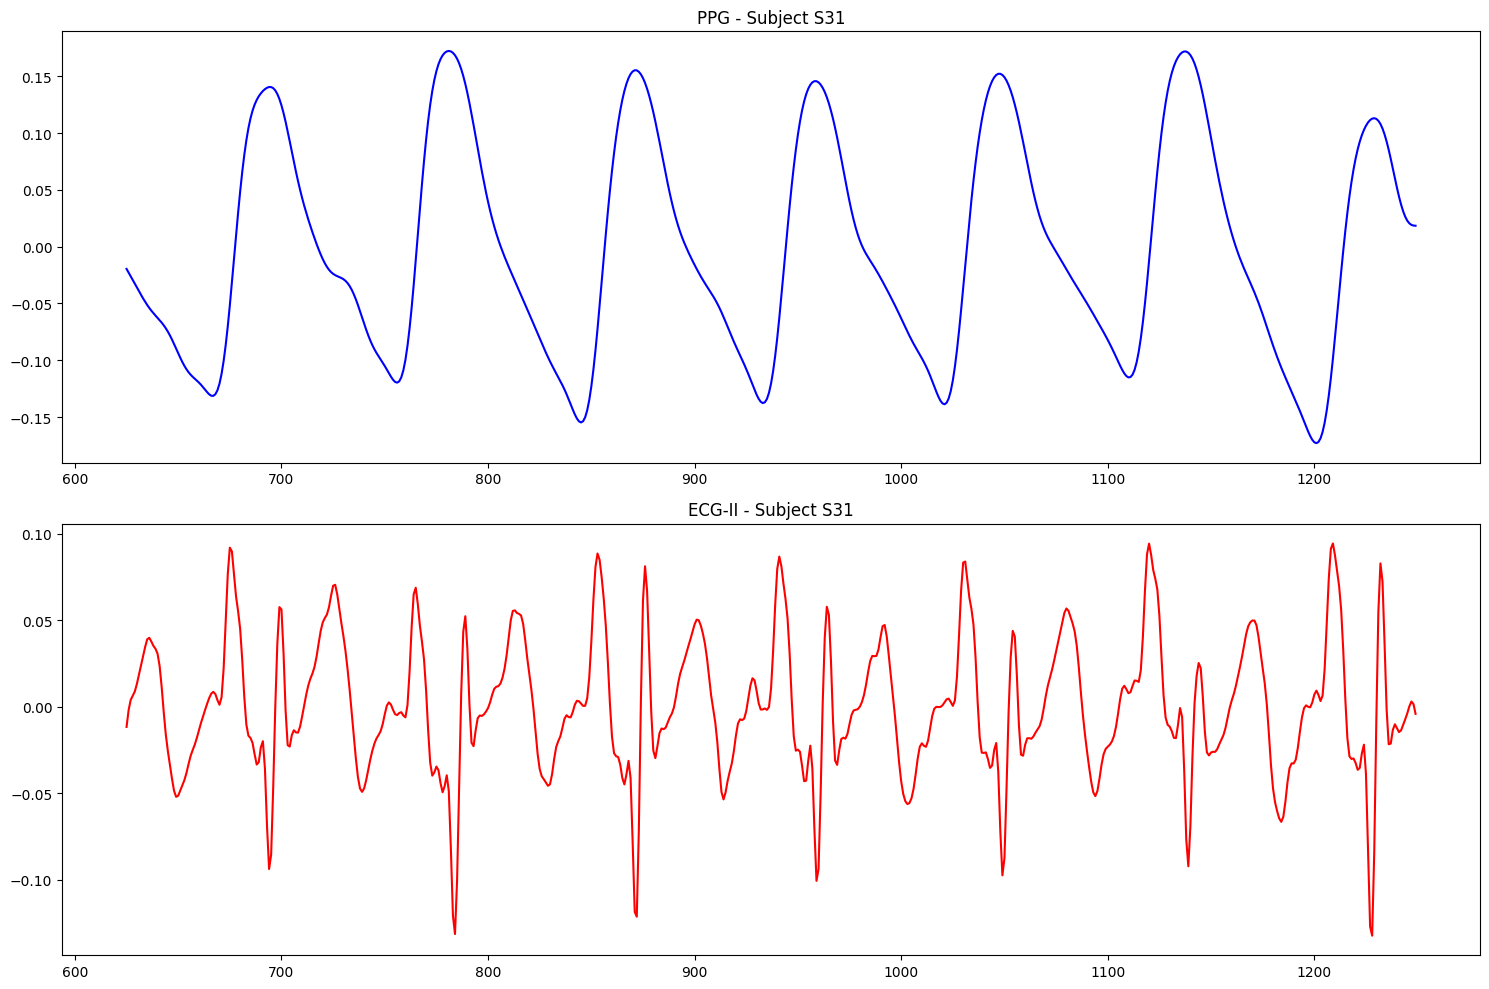

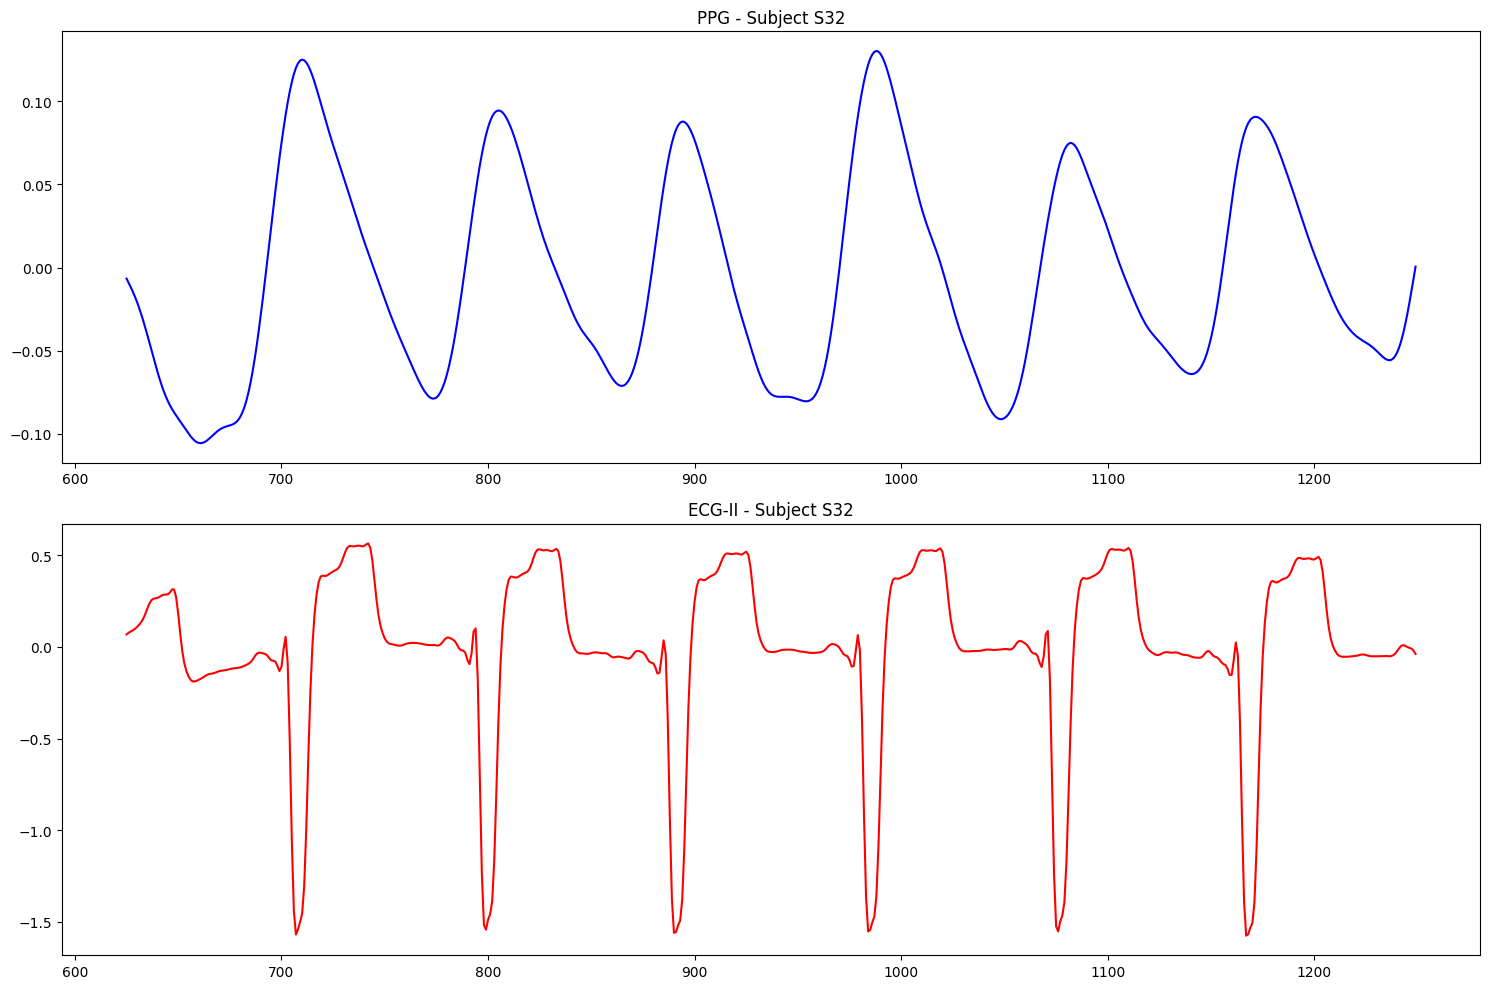

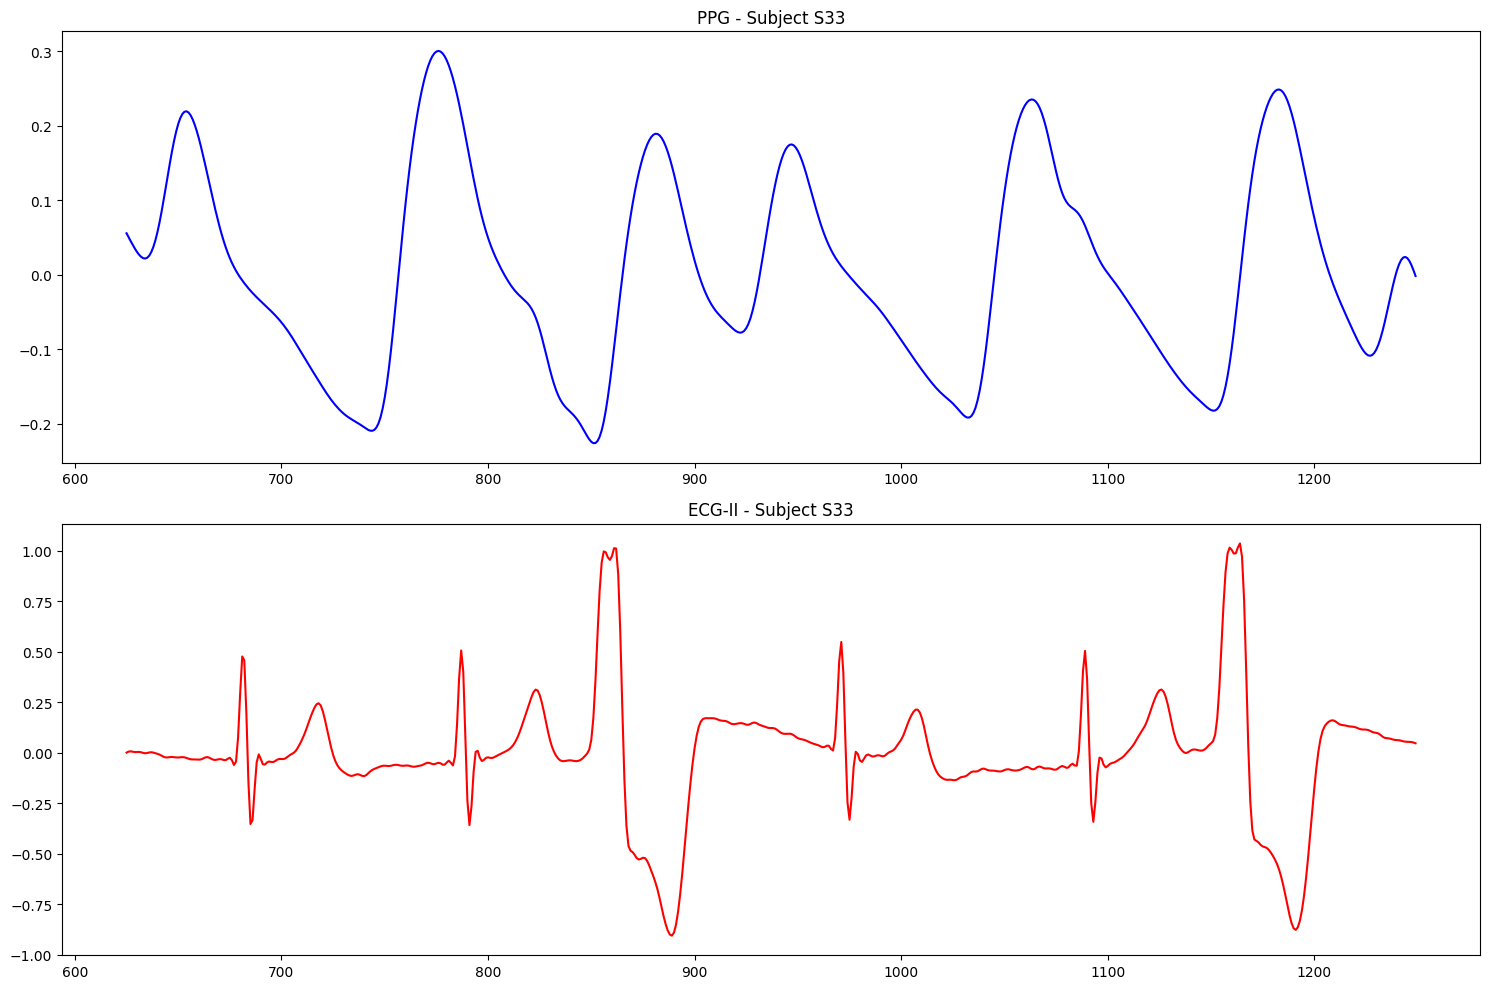

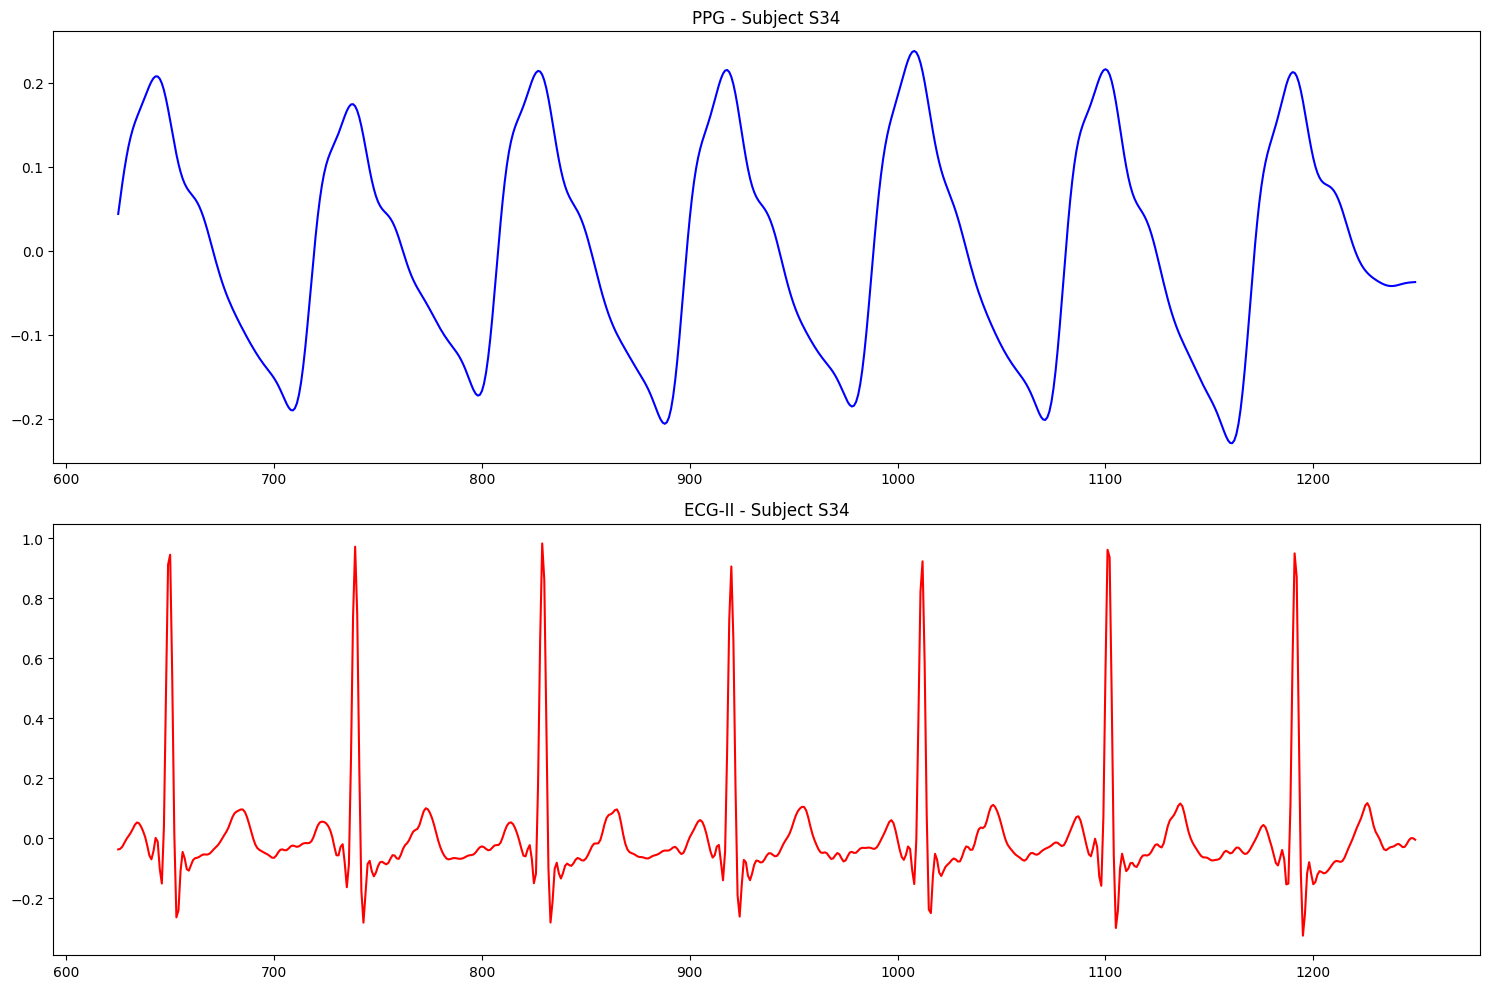

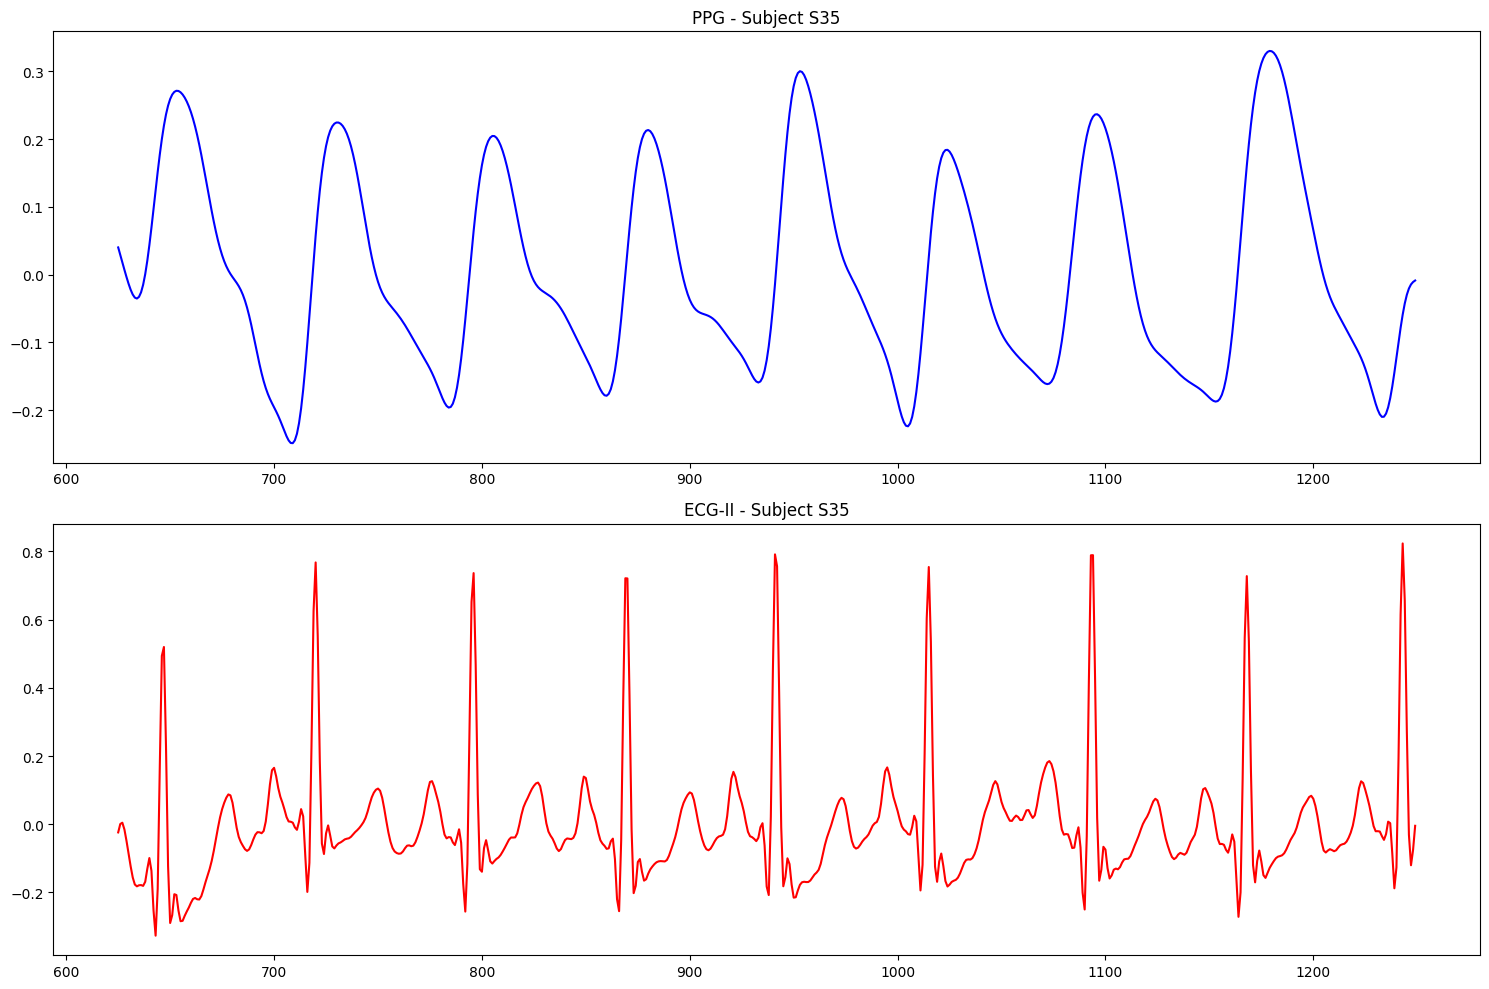

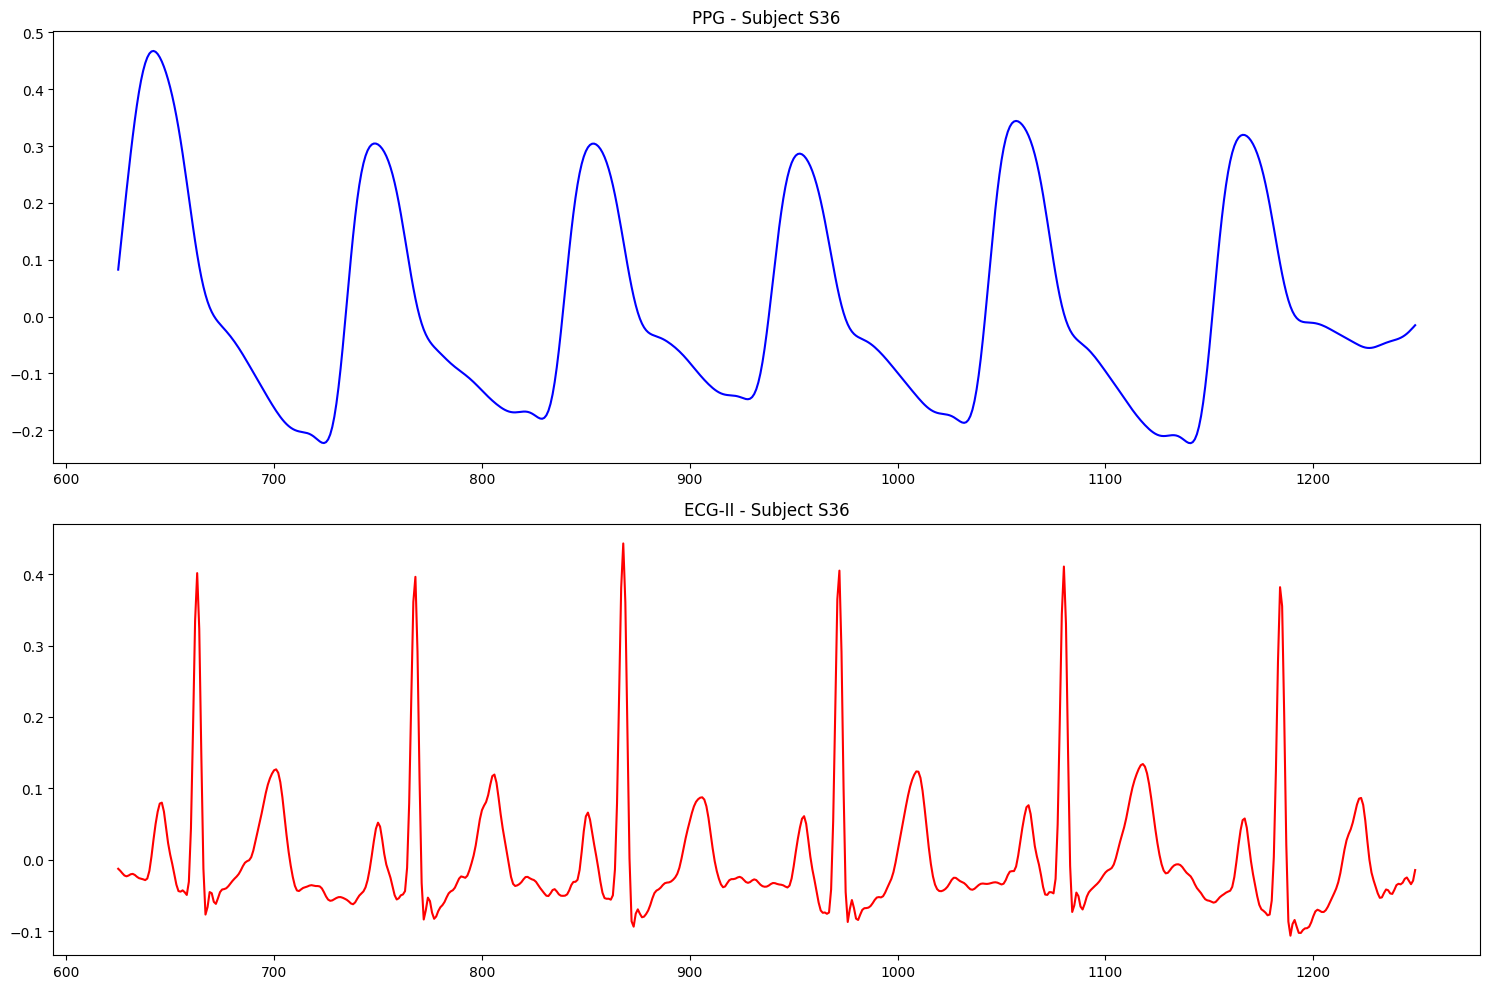

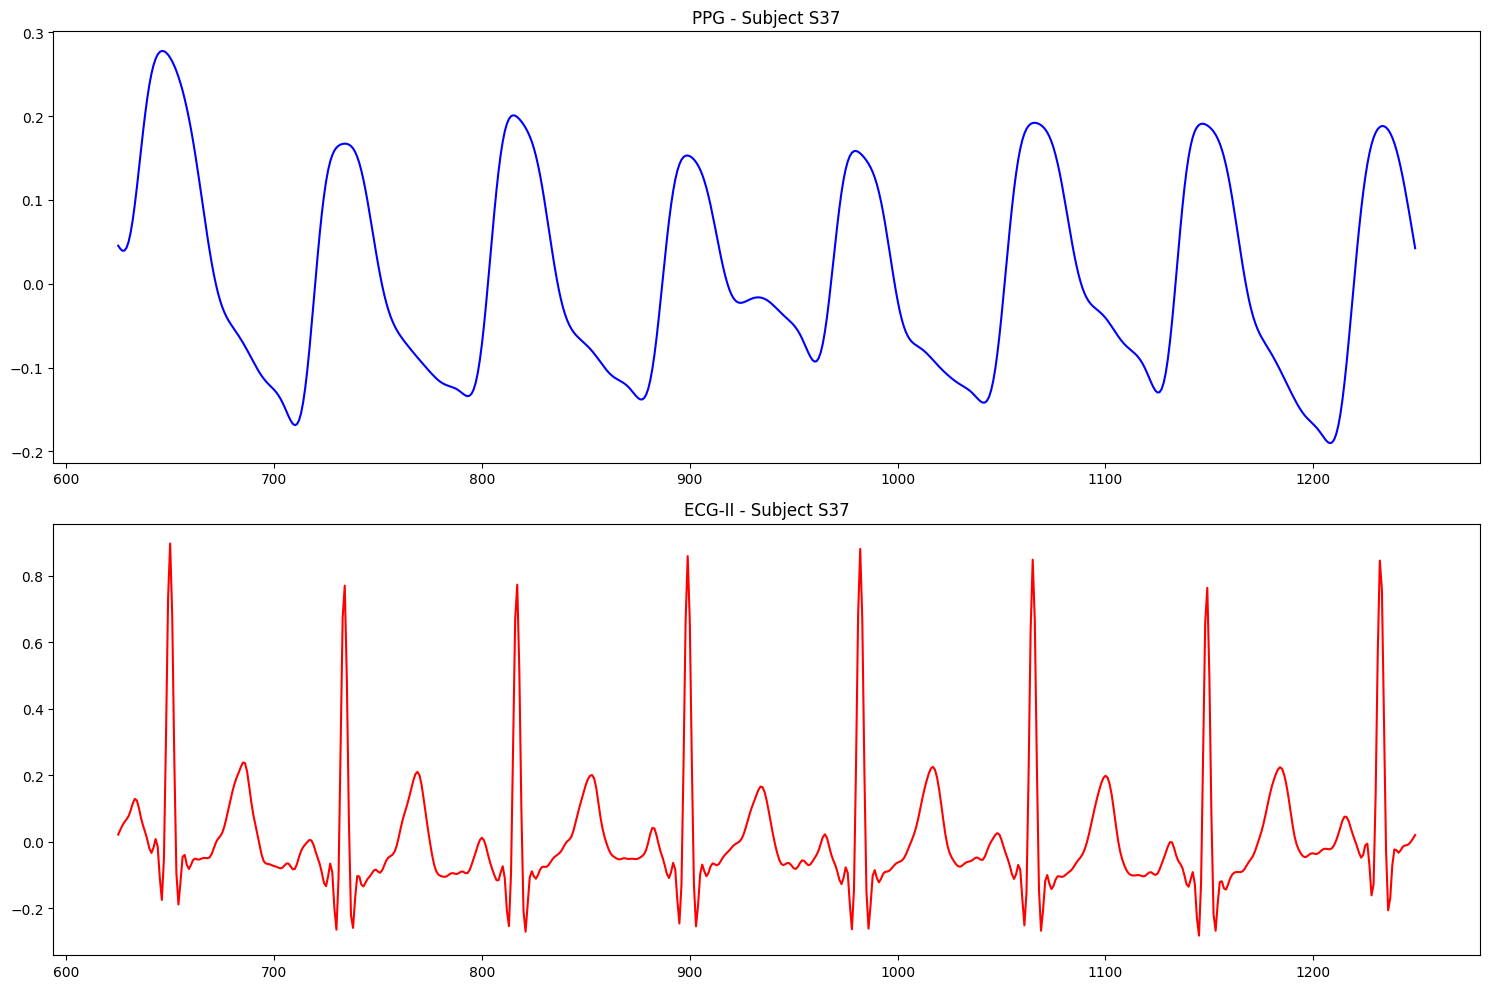

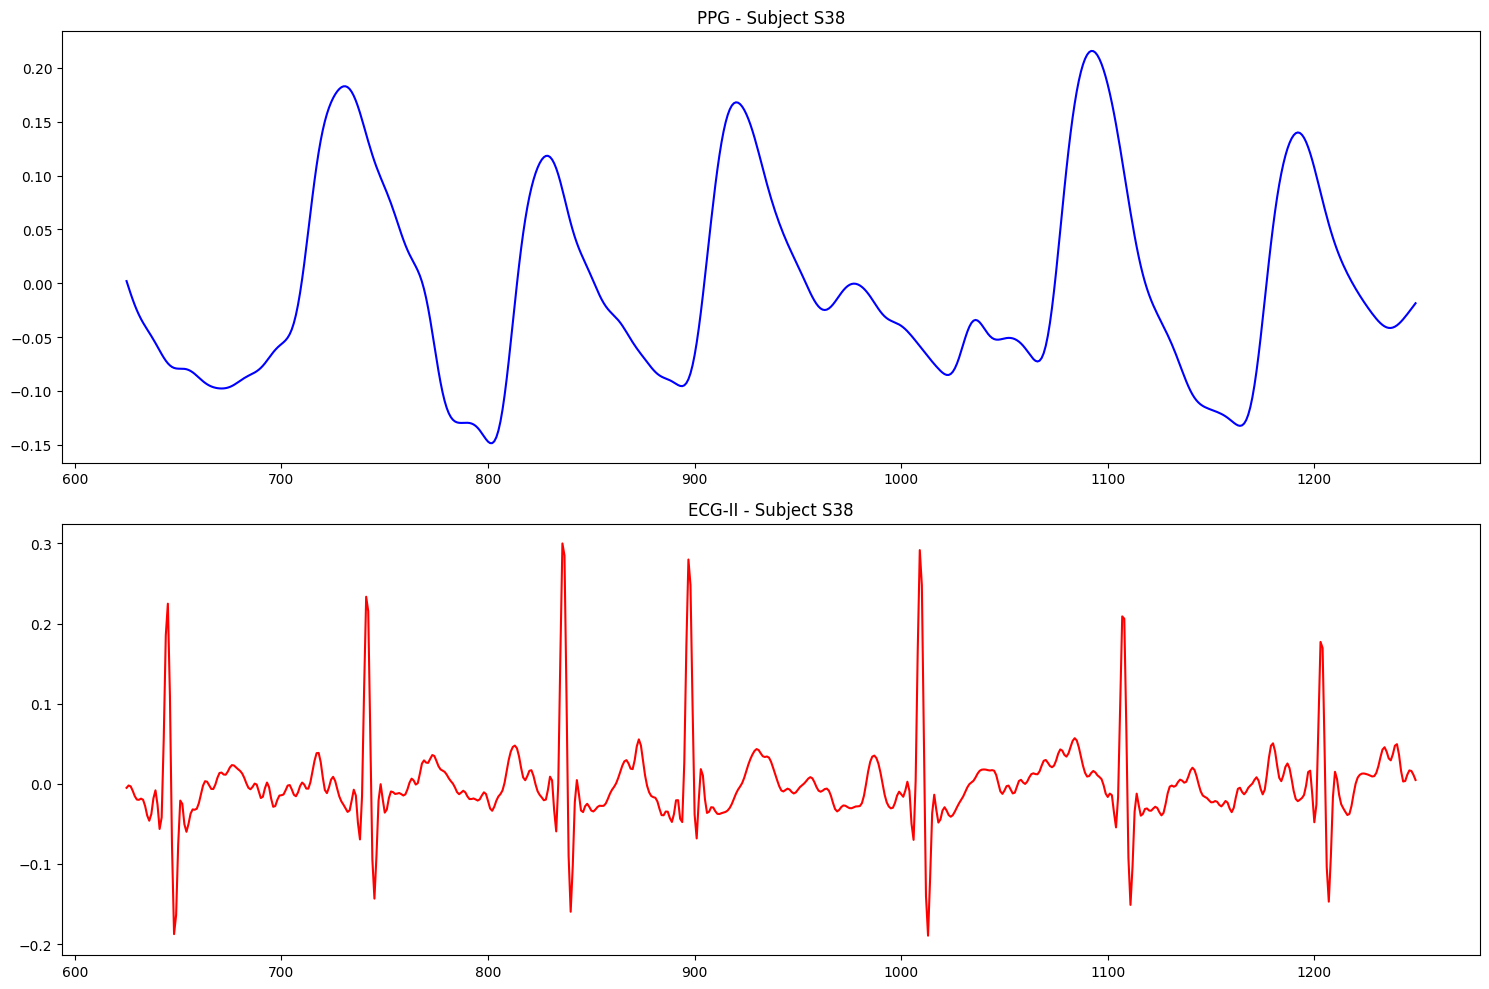

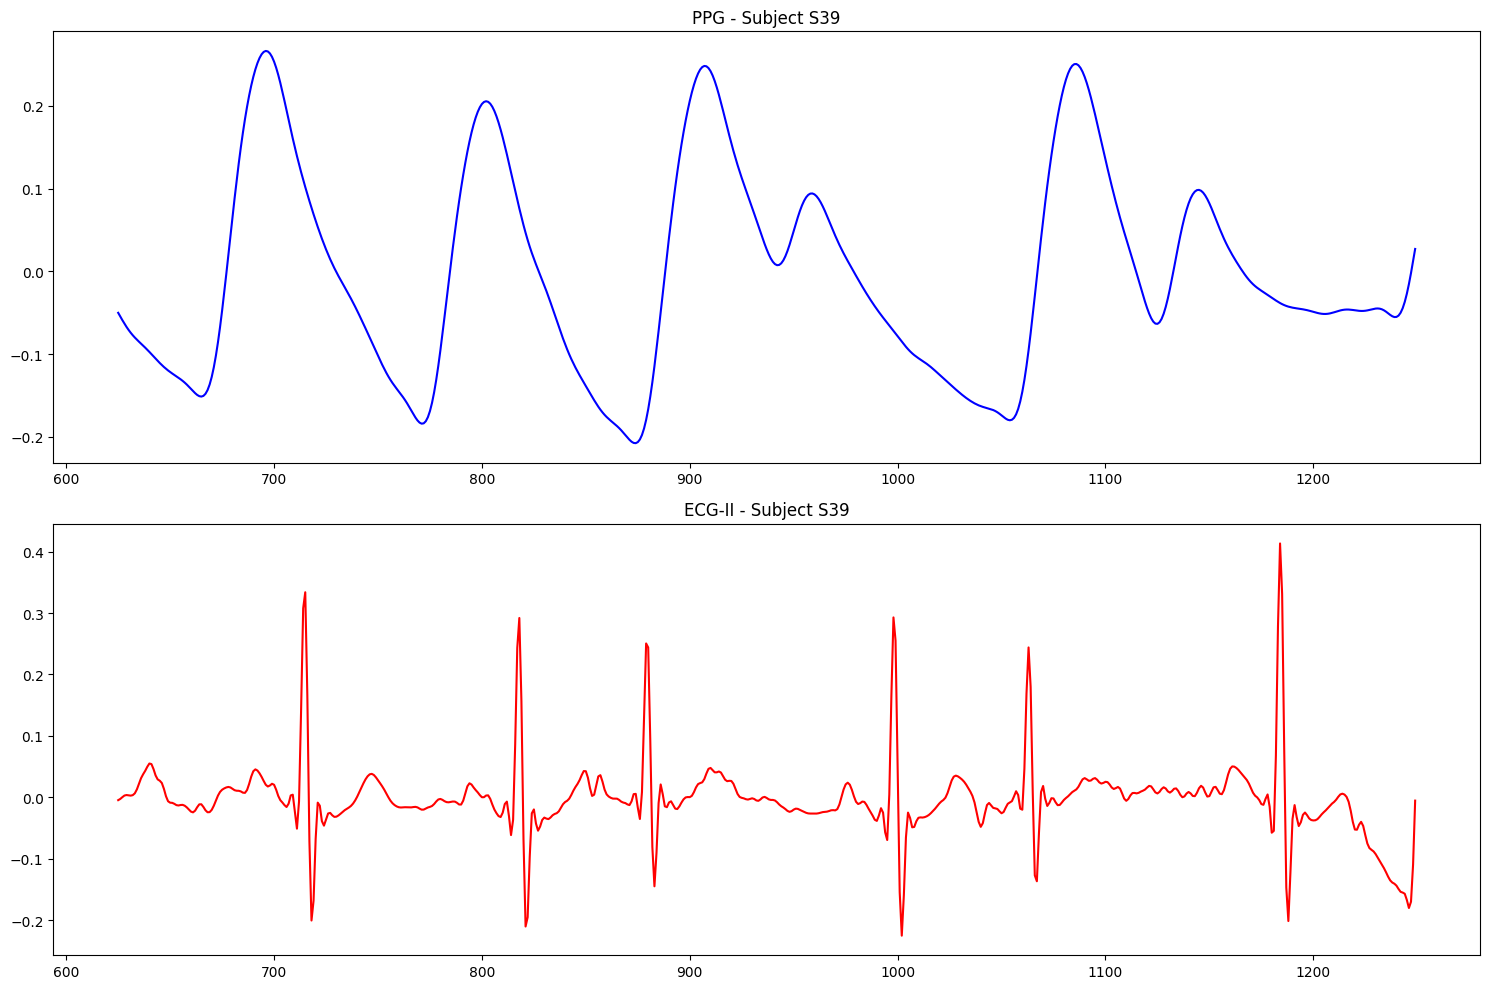

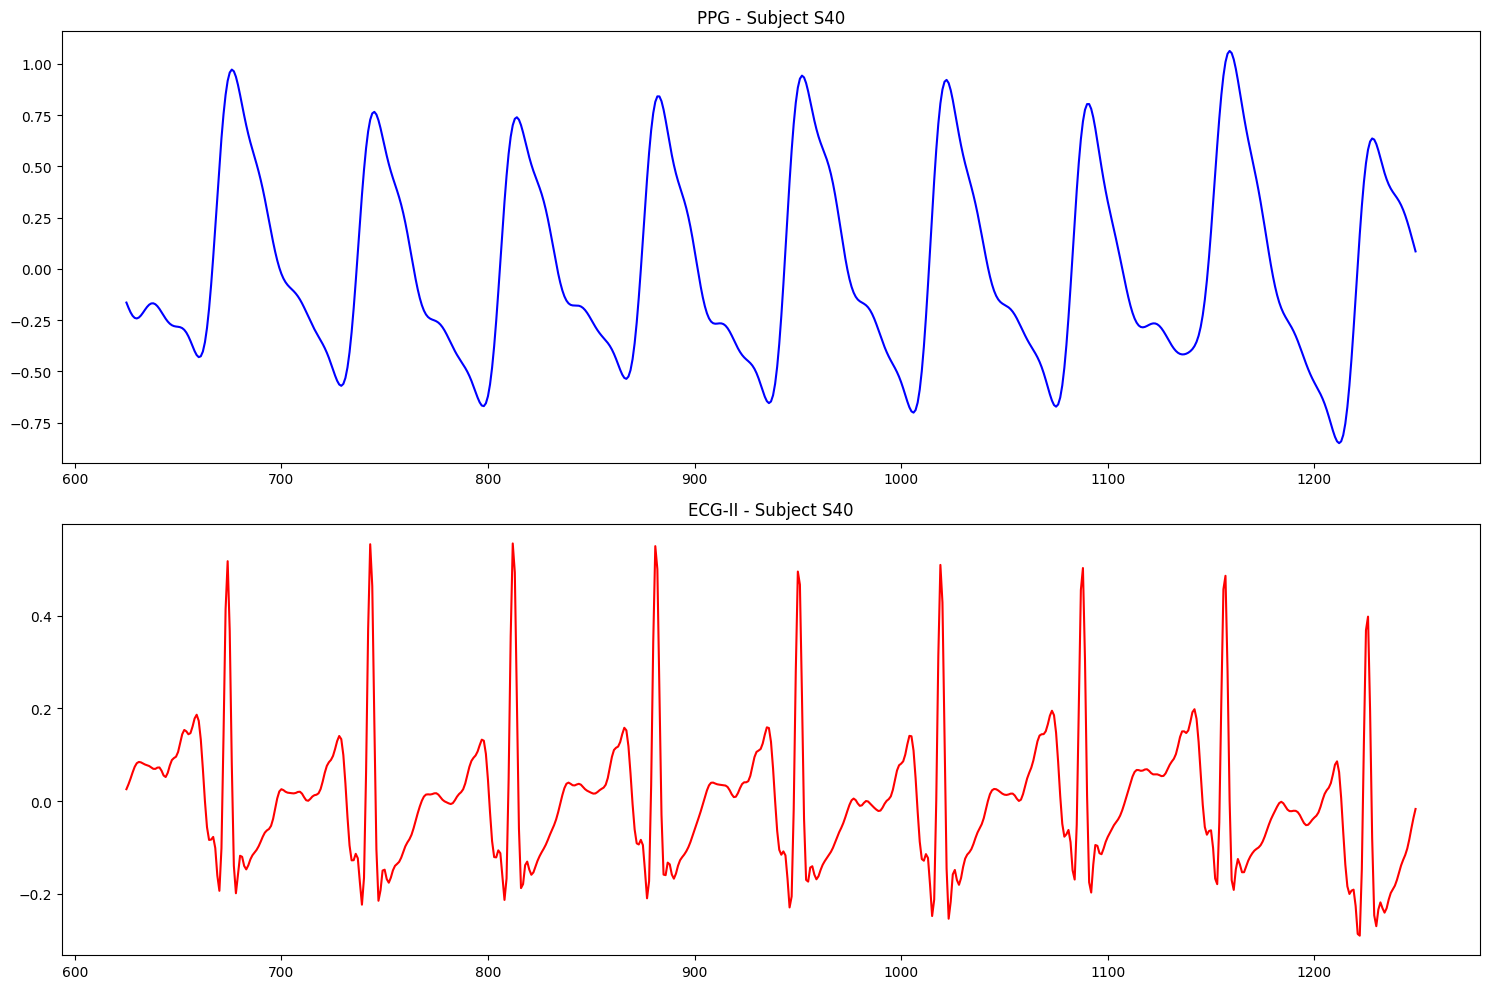

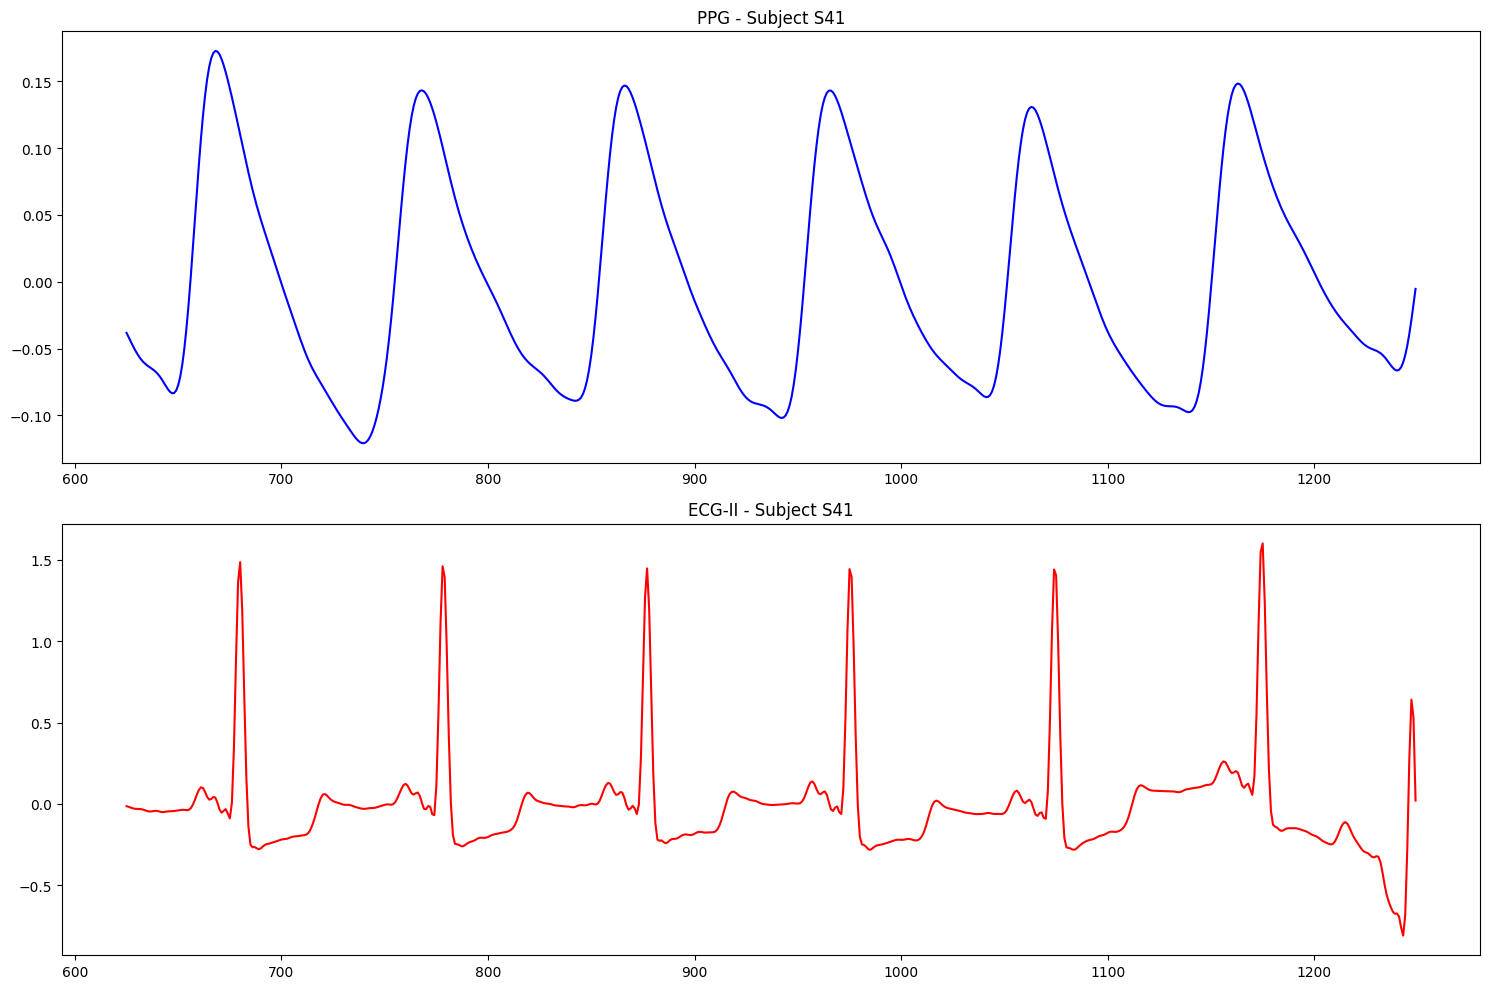

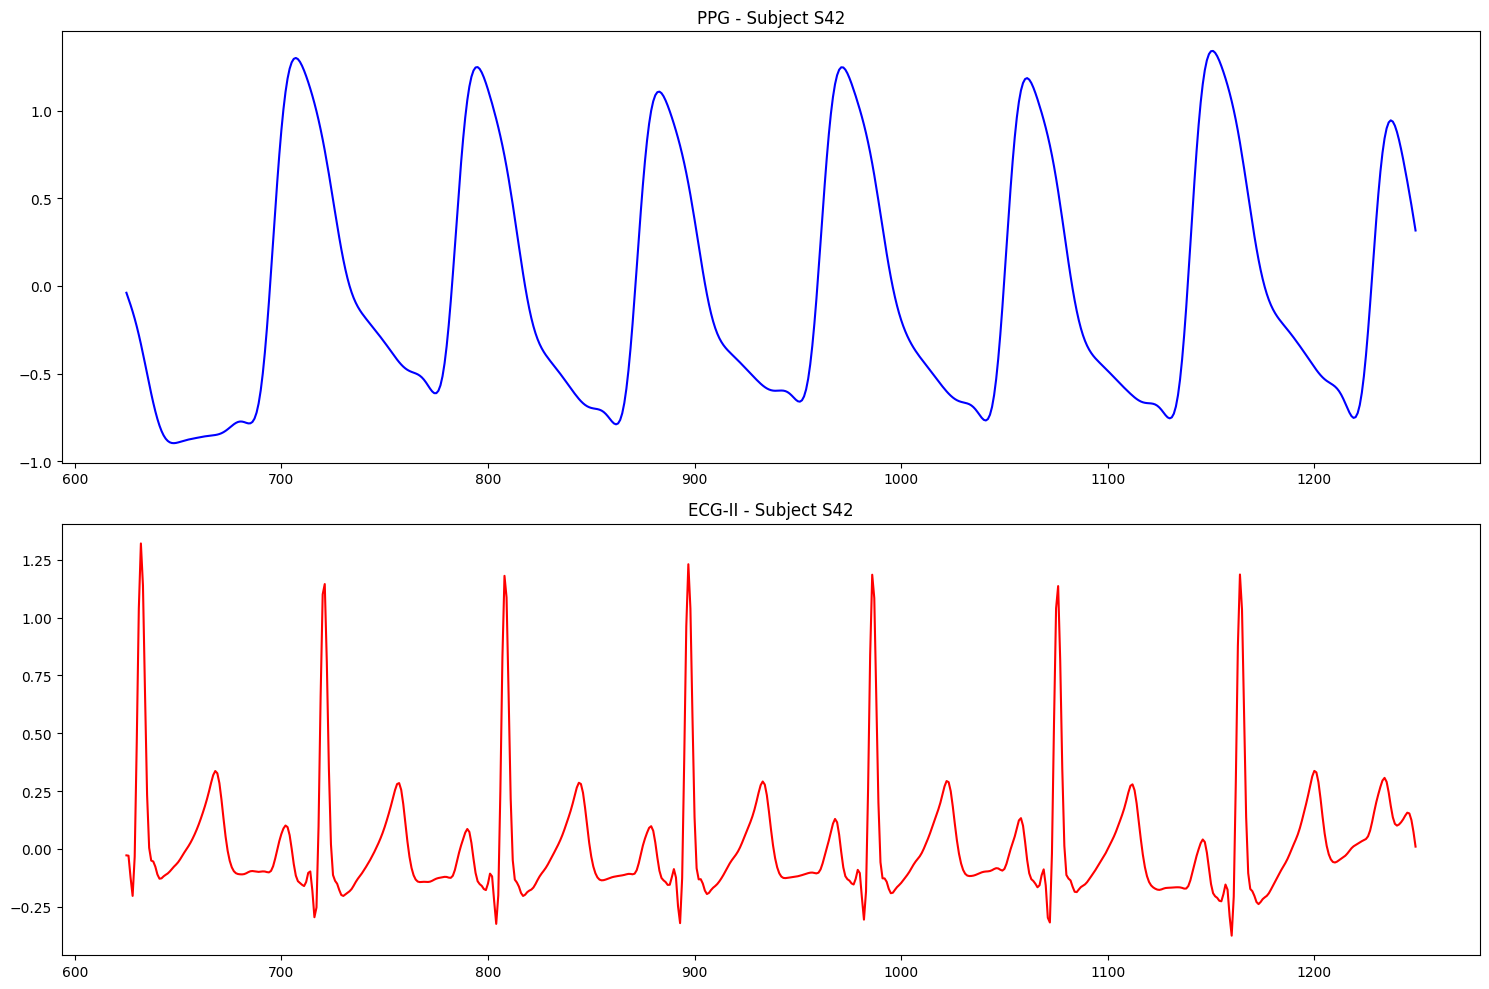

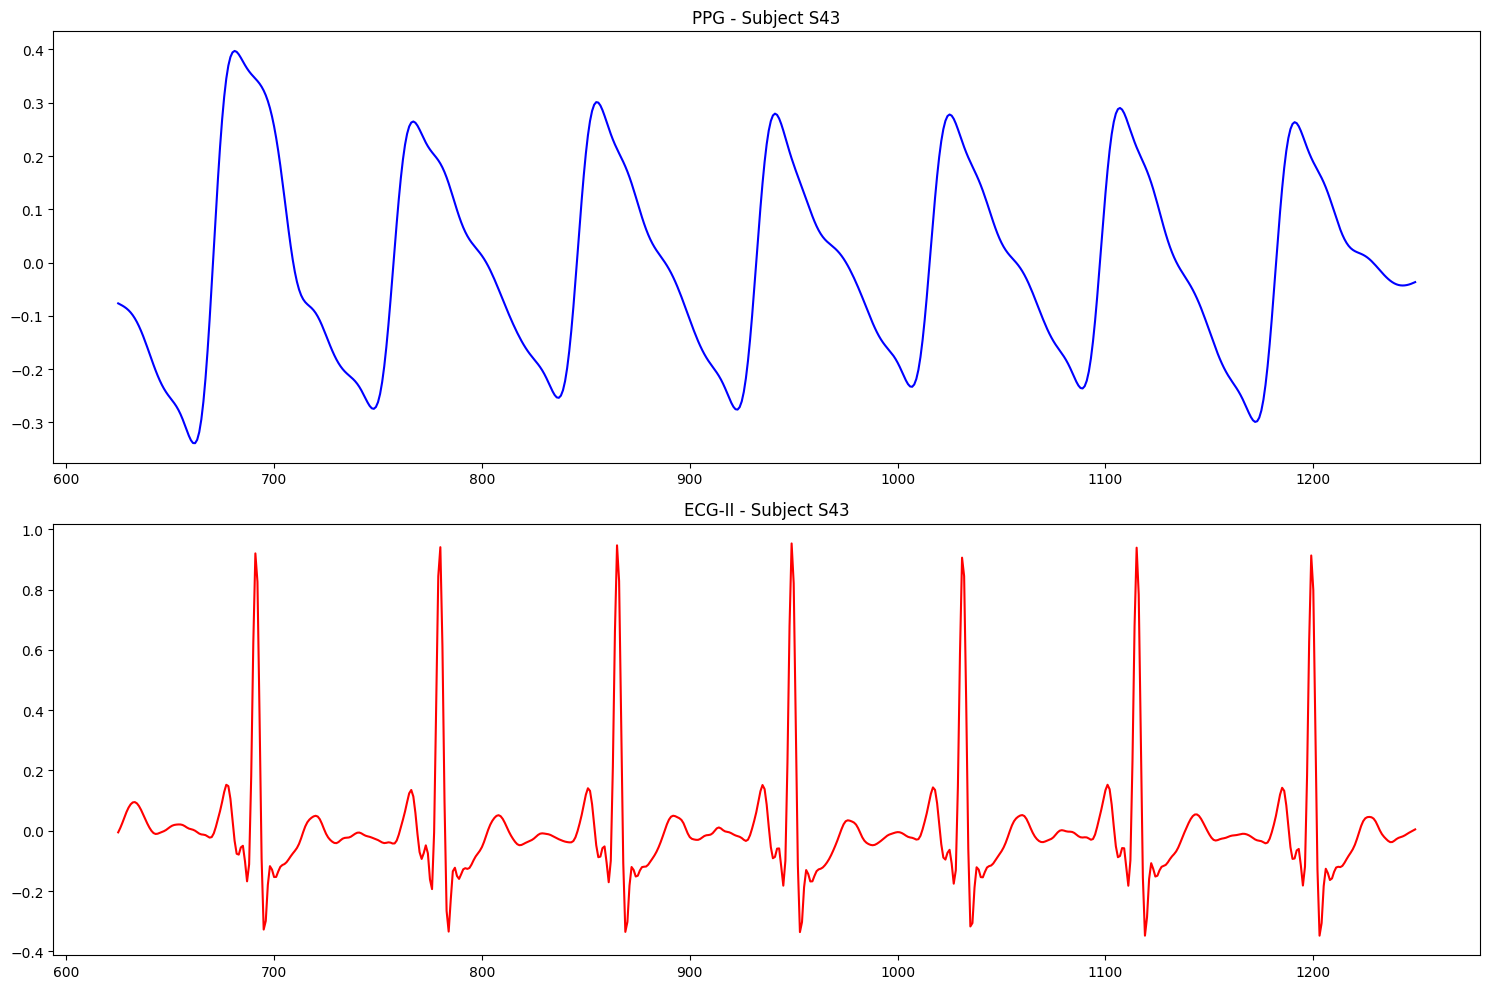

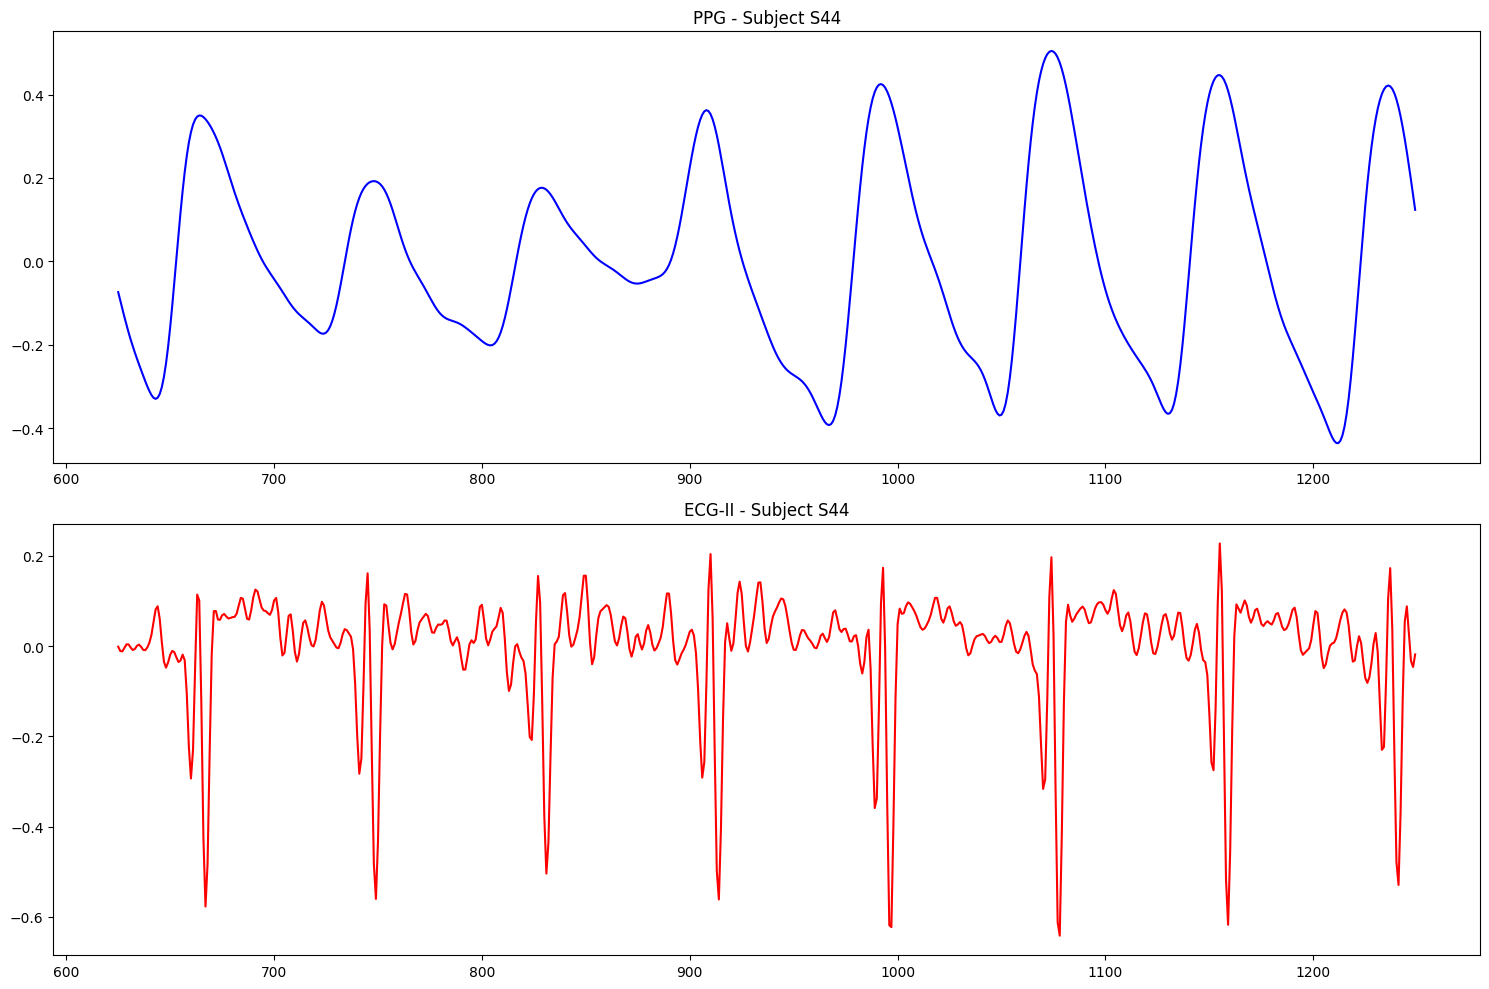

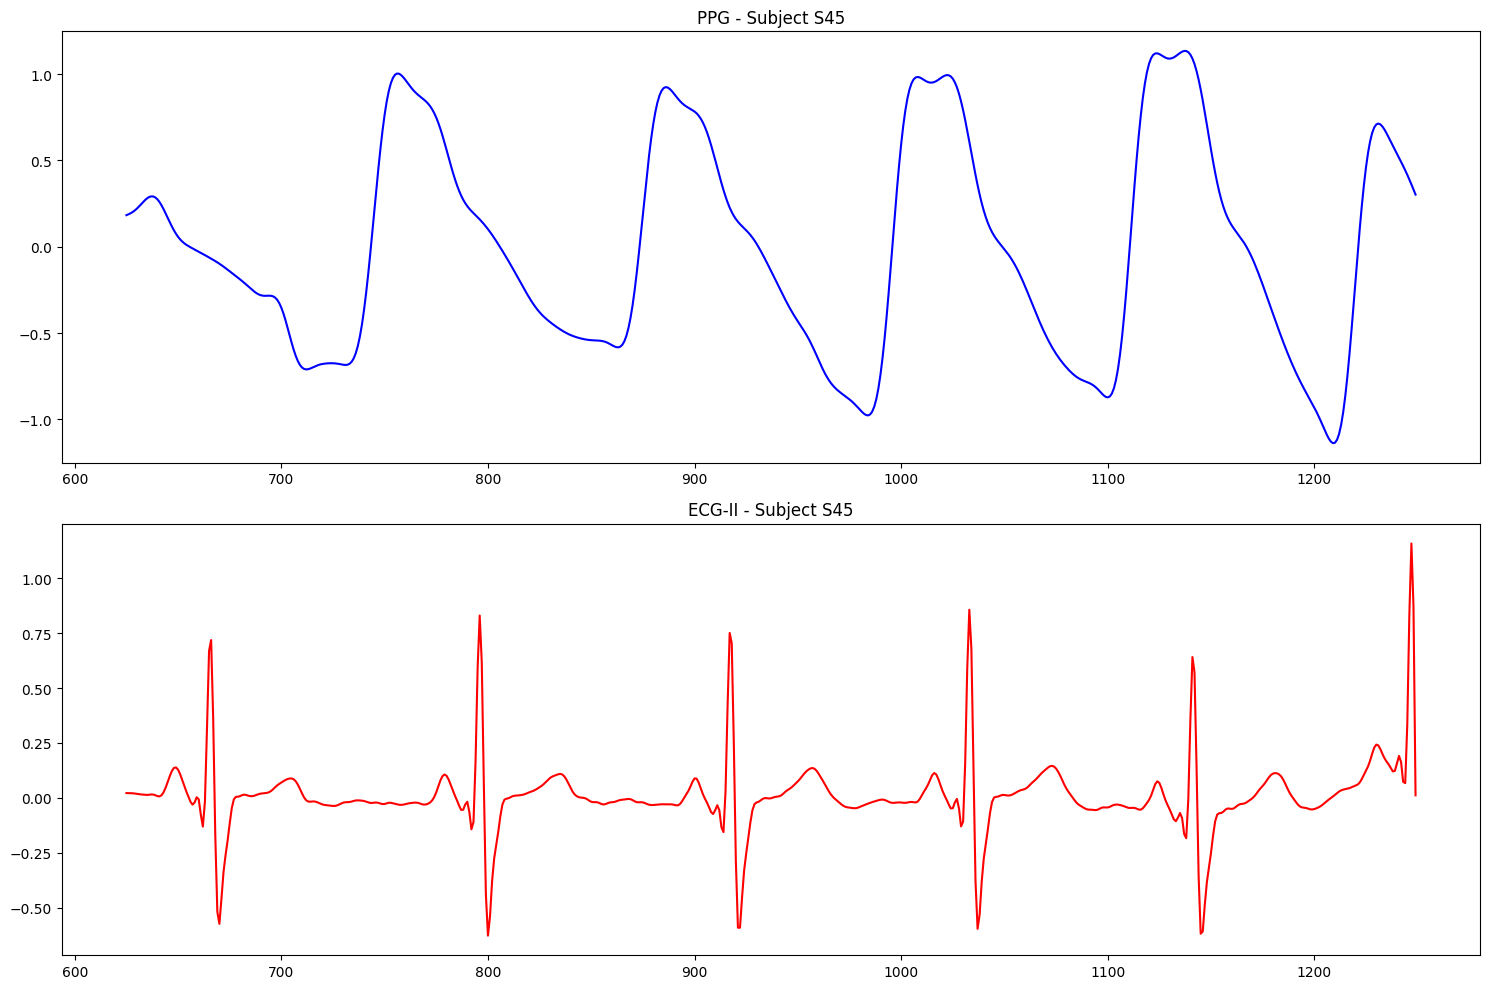

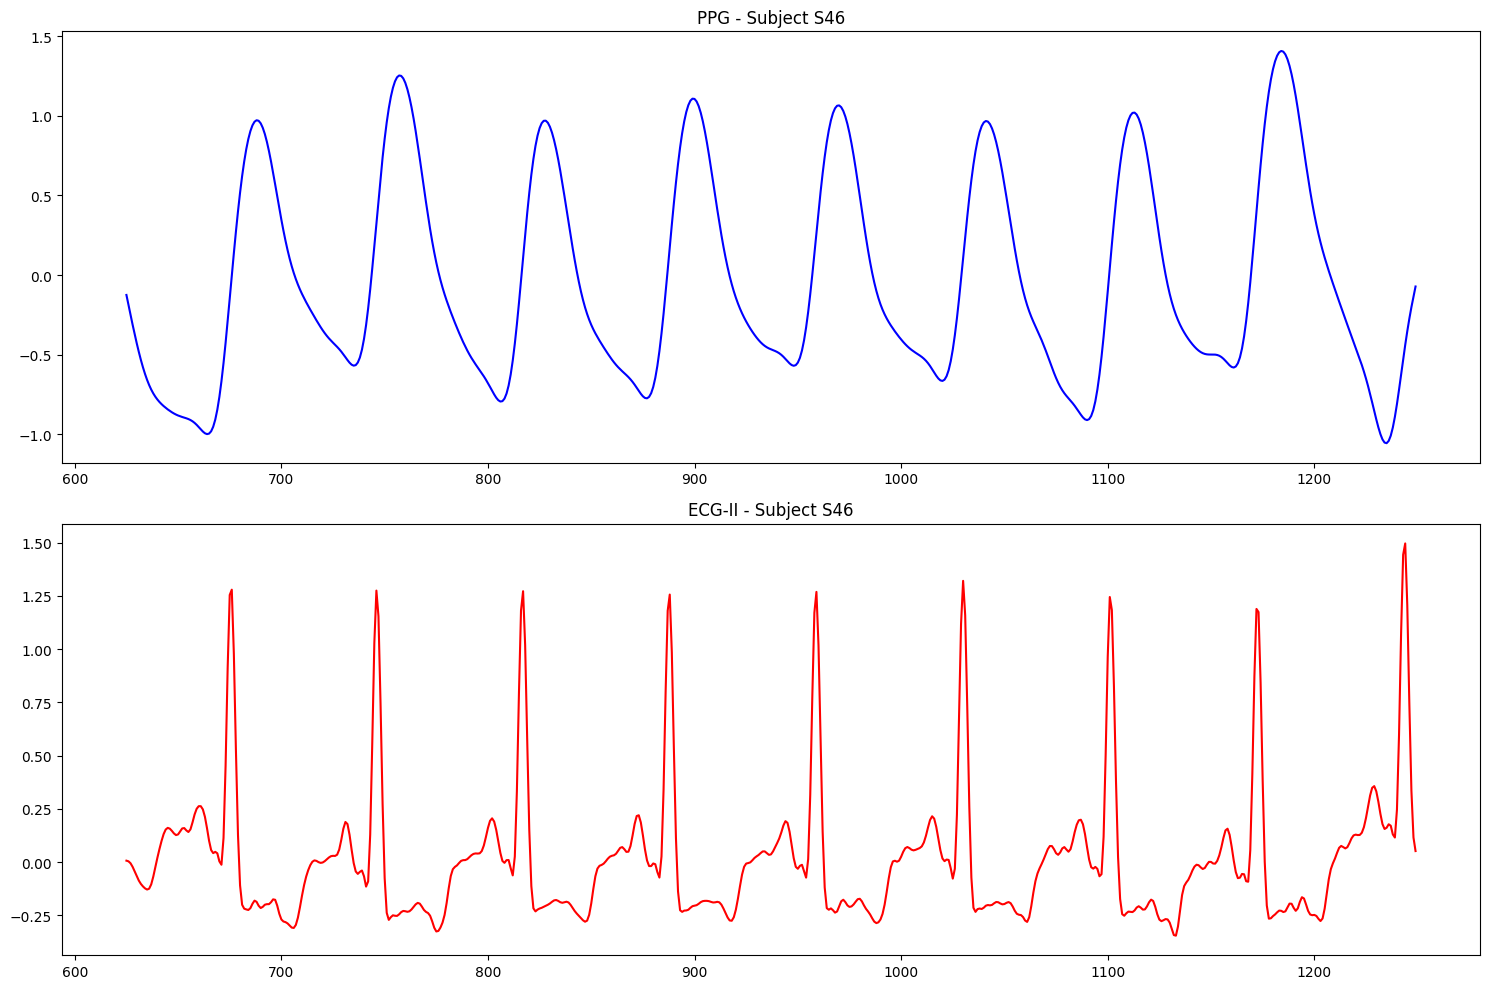

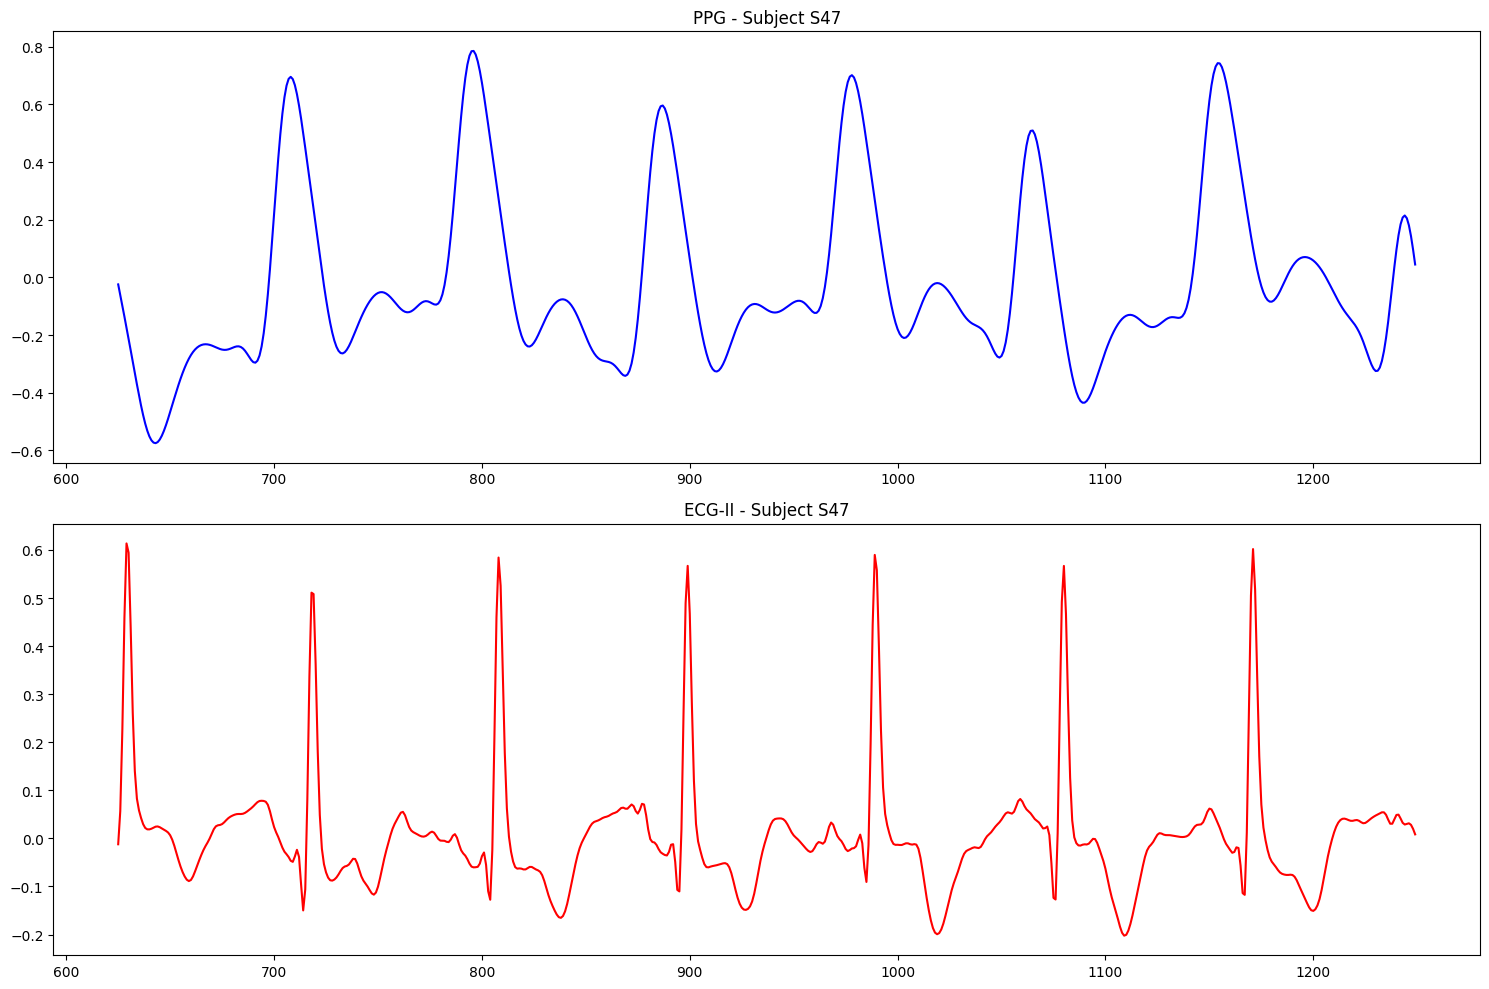

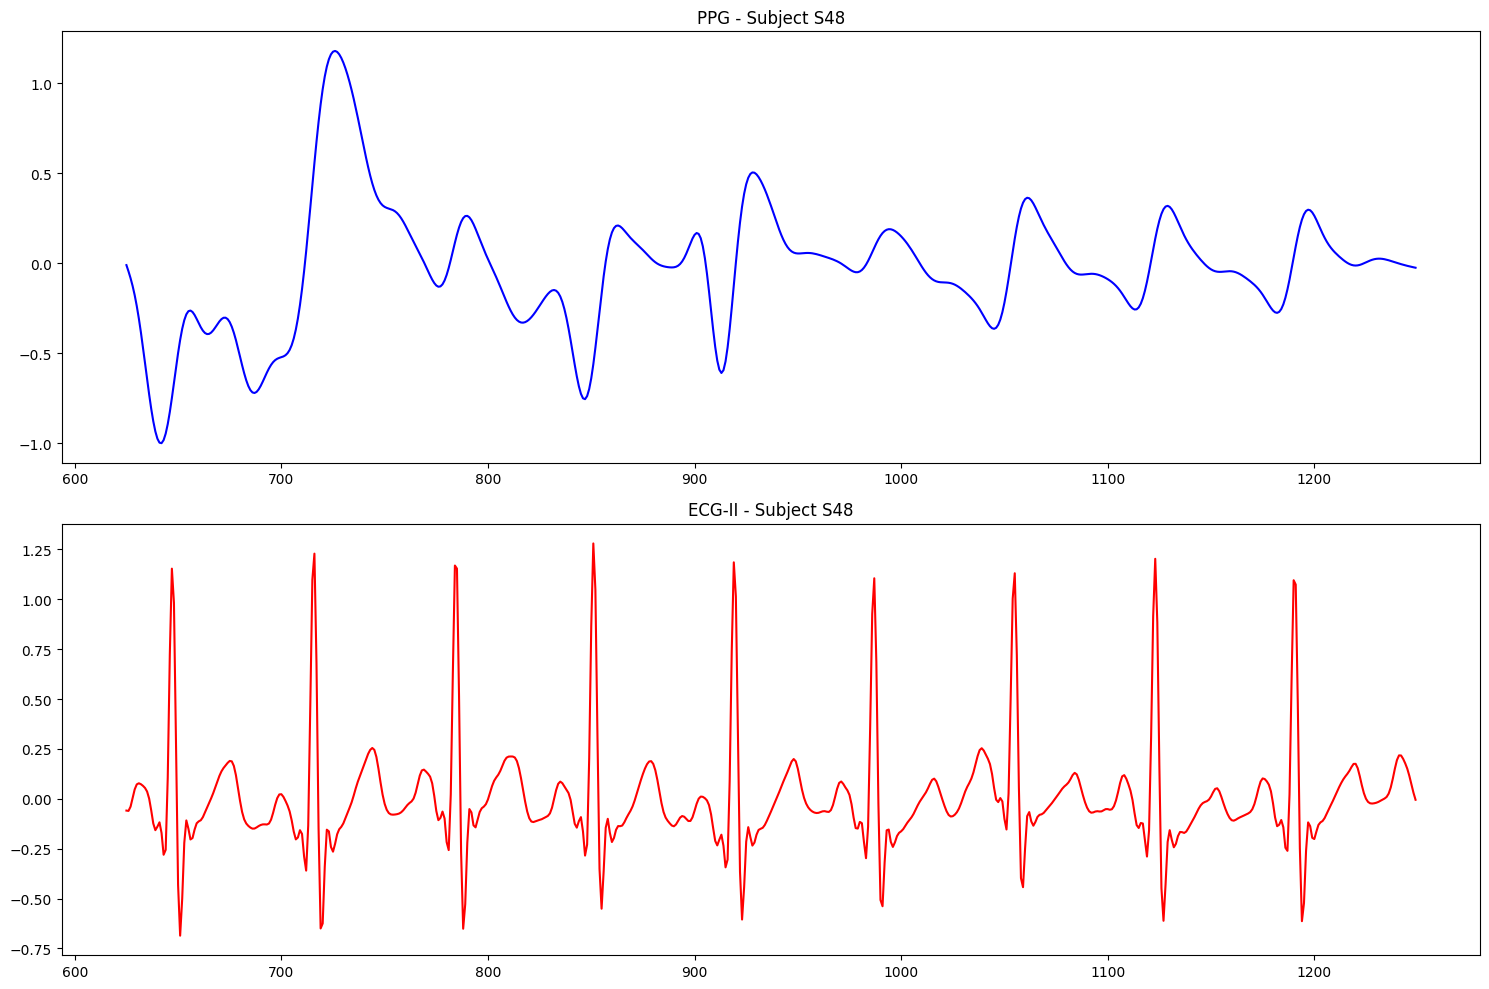

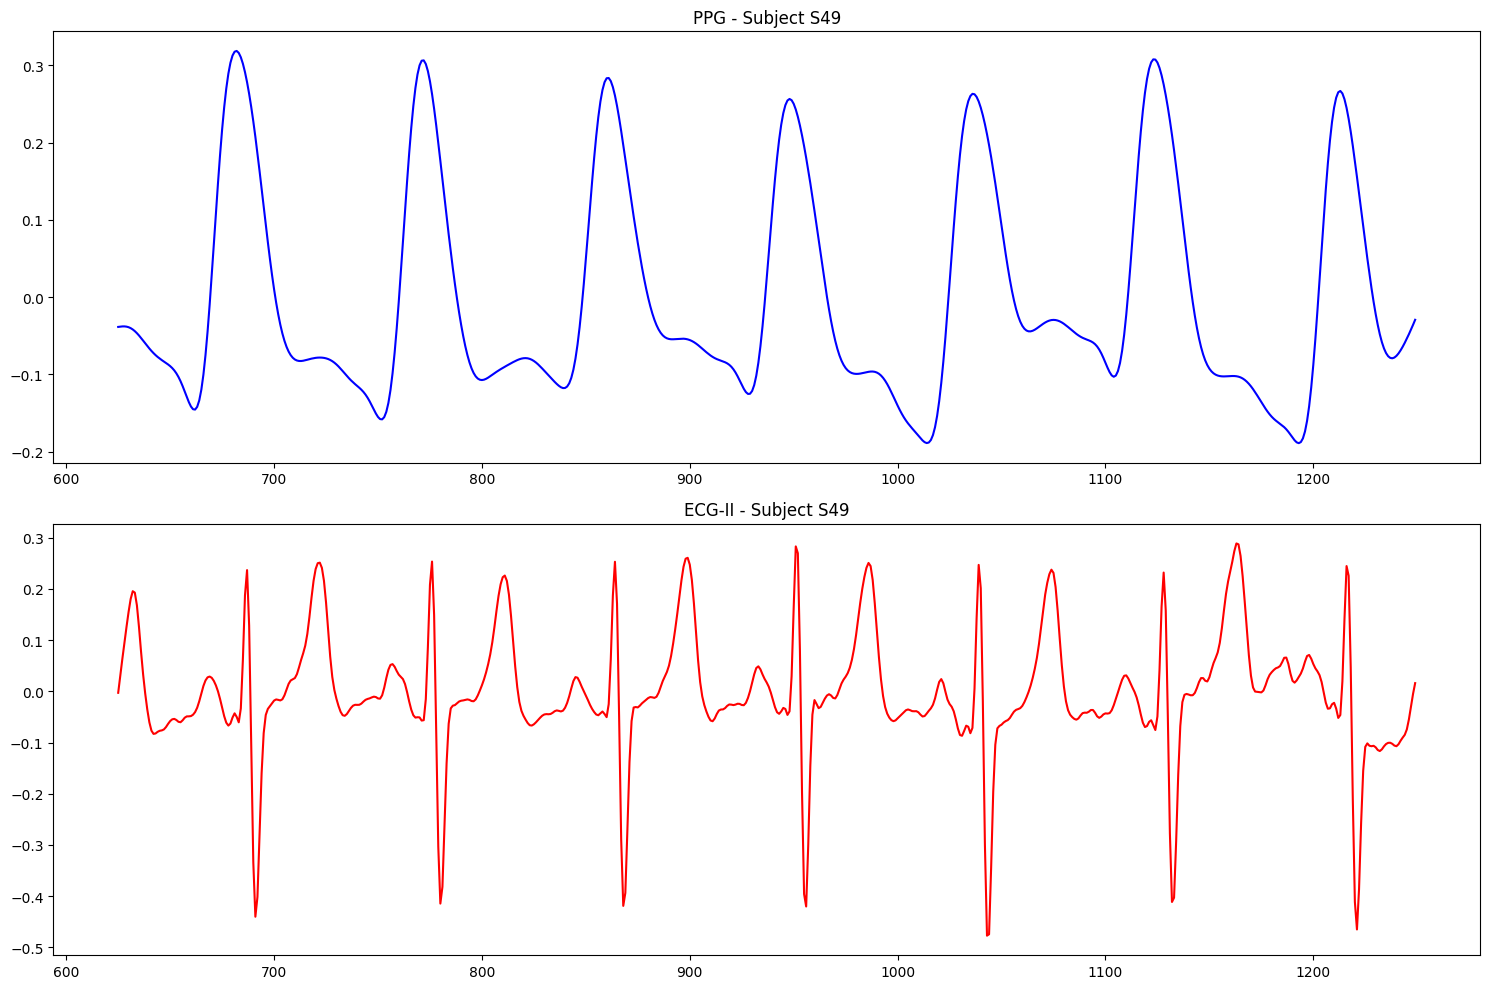

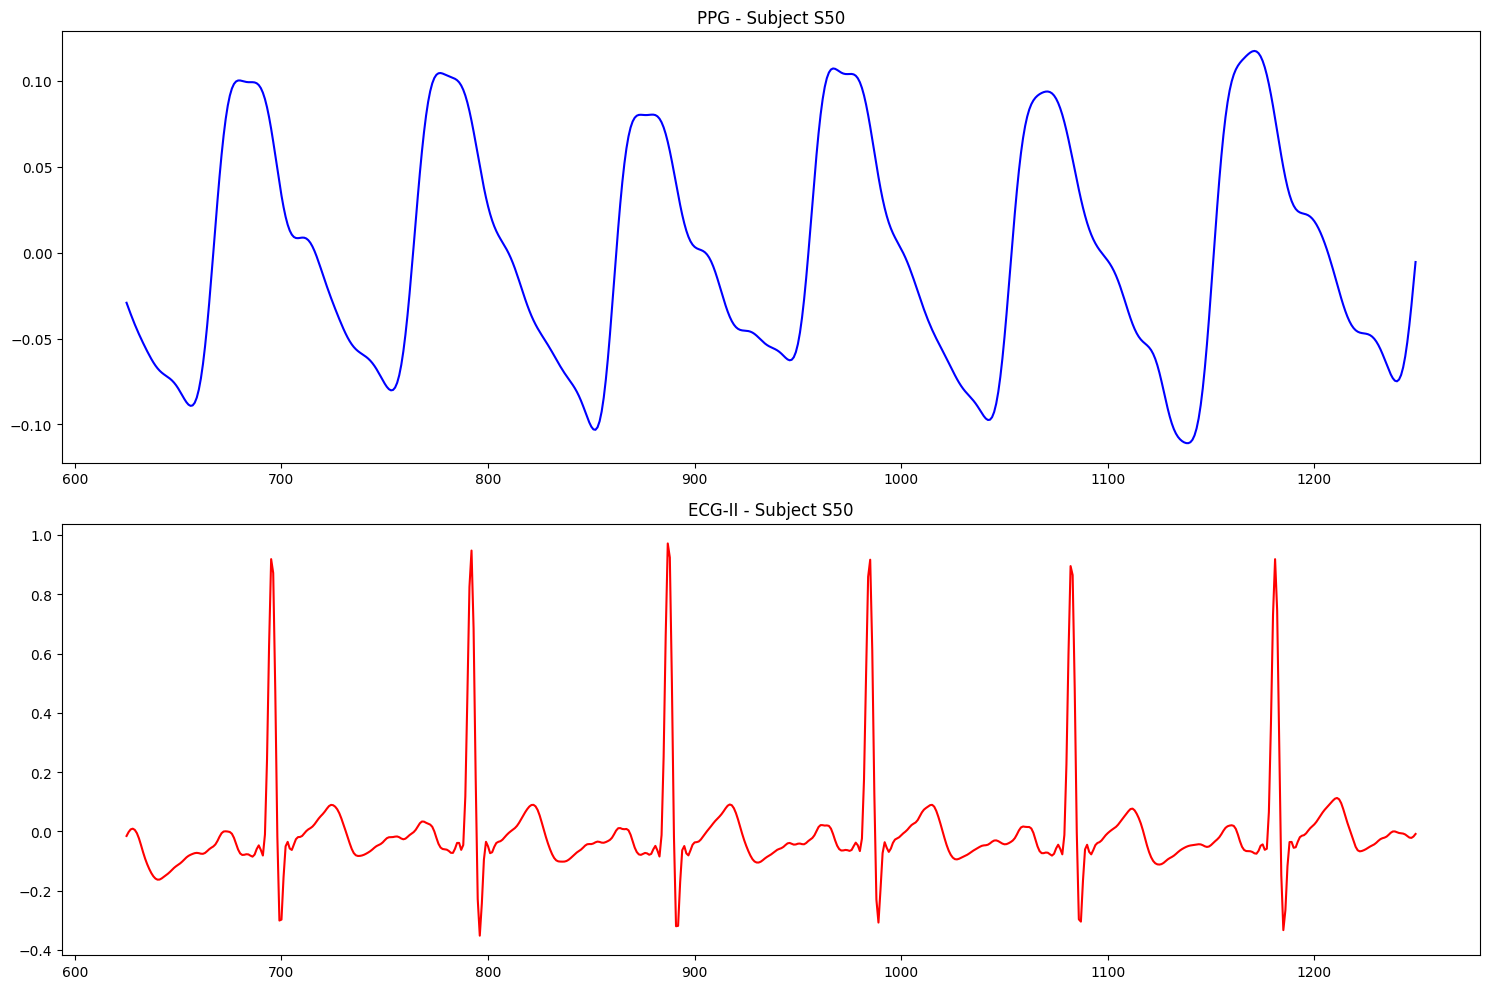

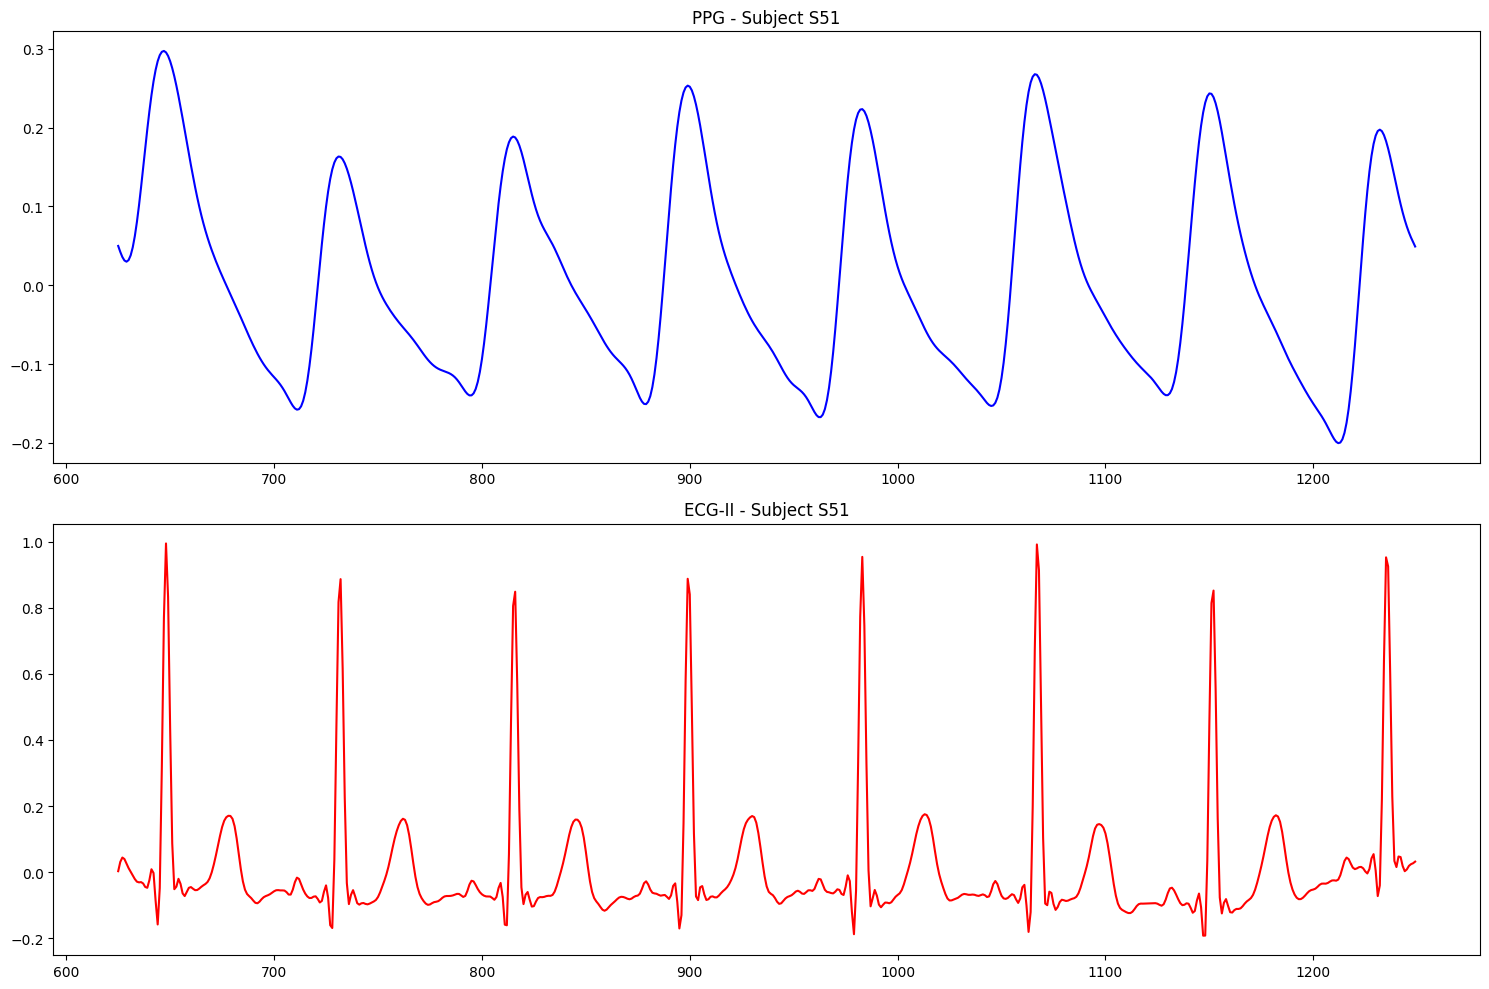

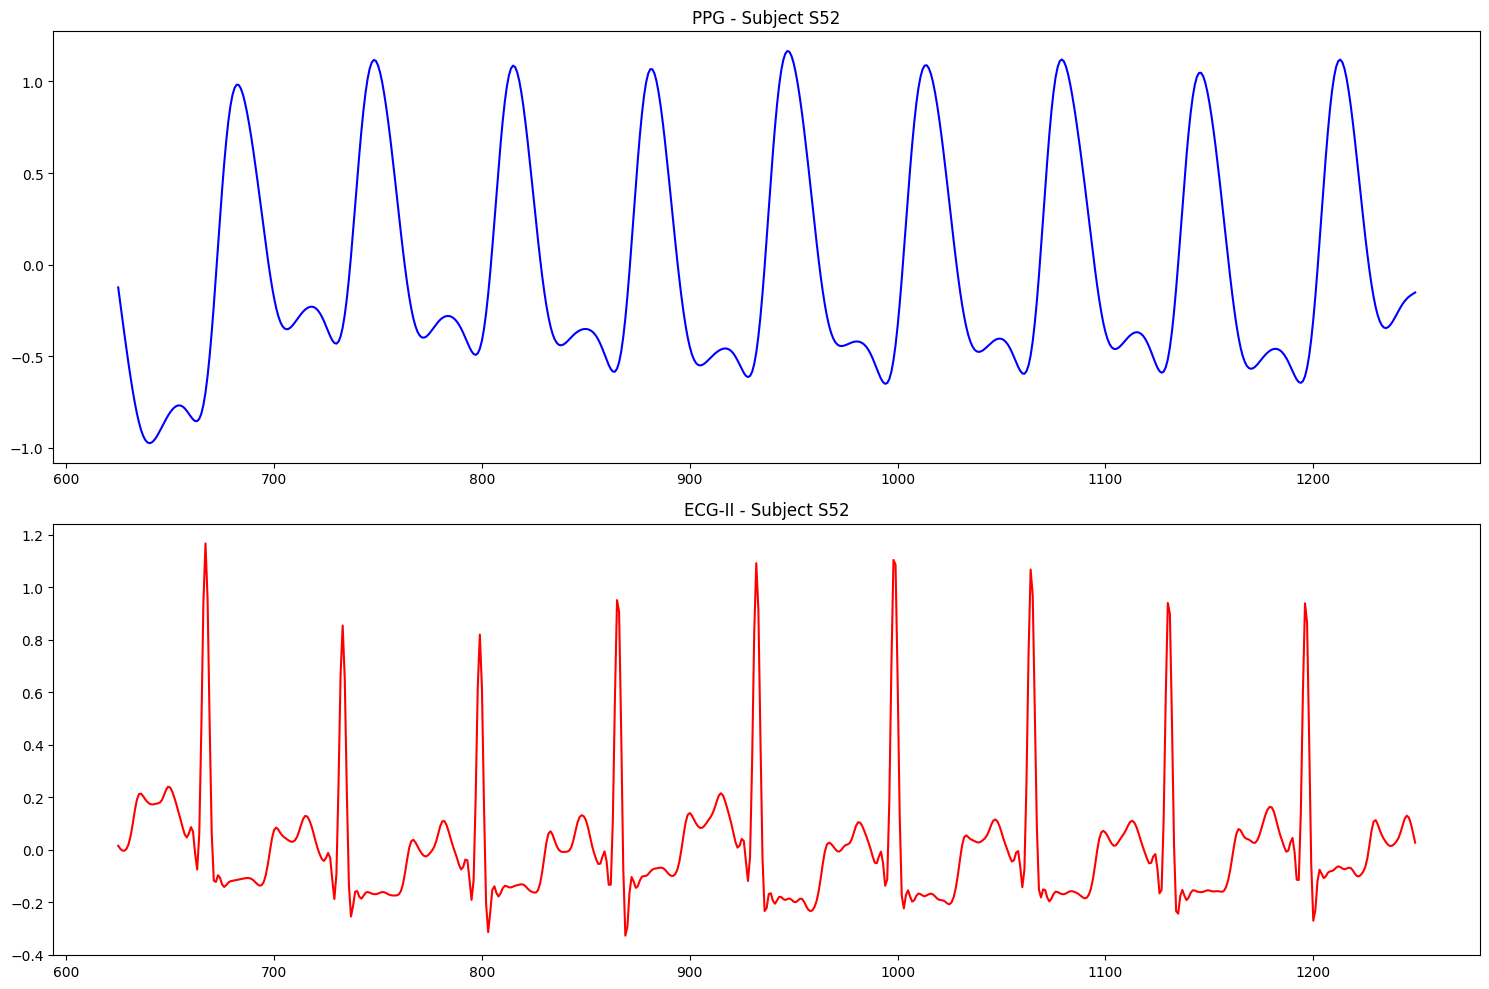

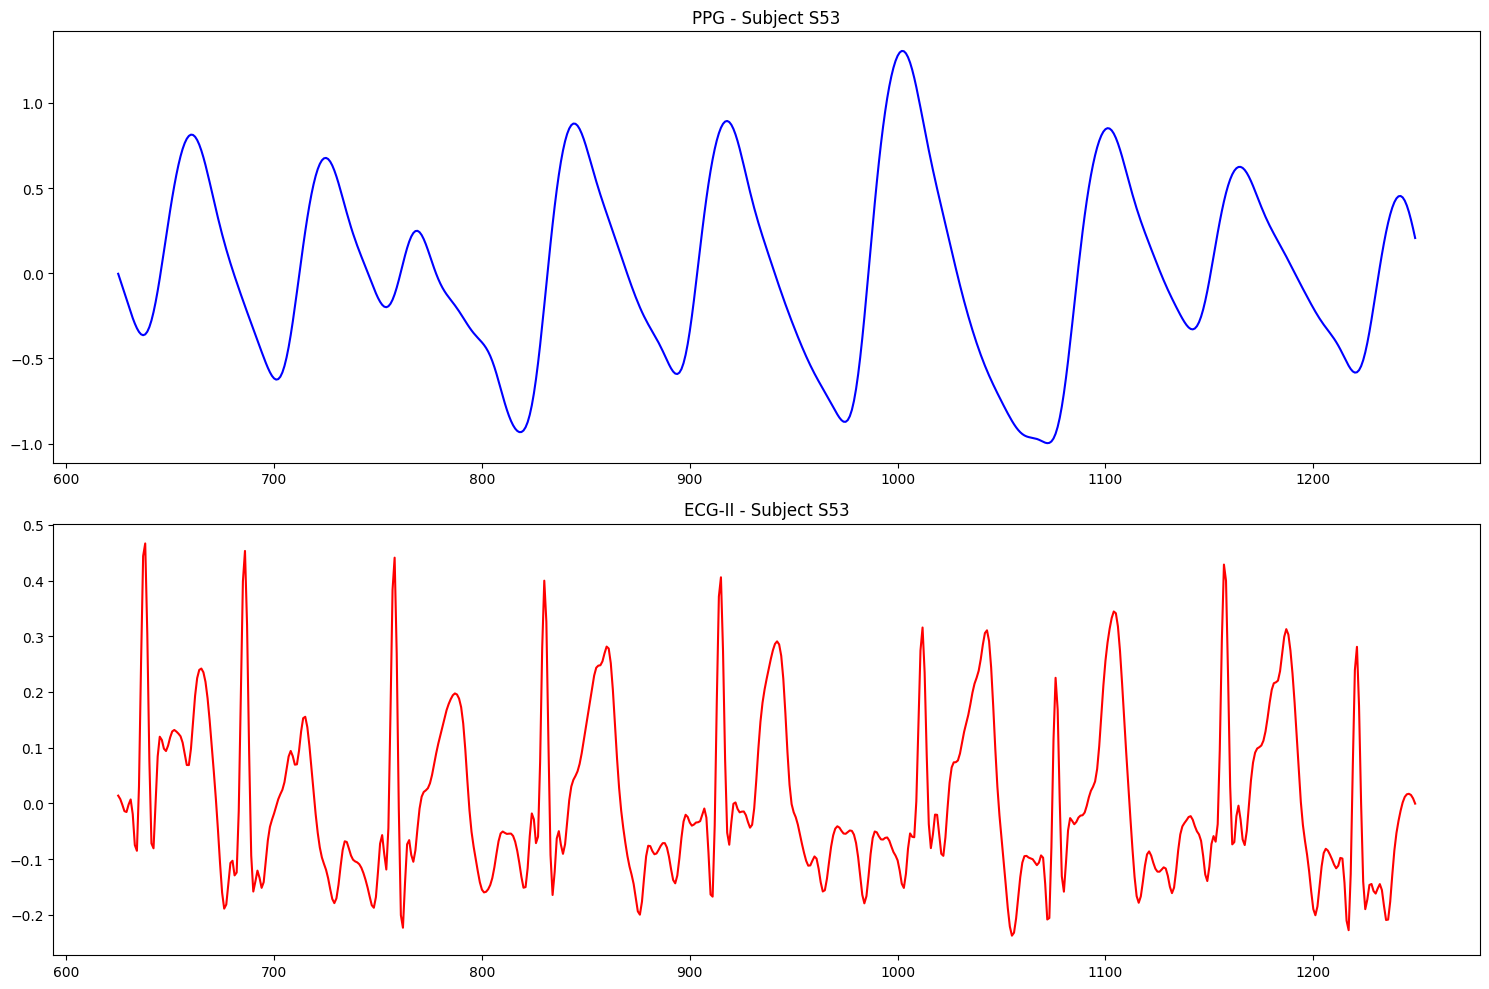

In [16]:
#plotto i primi 10 secondi del soggetto 4
soggetti = [
    "S01", "S02", "S03", "S04", "S05", "S06", "S07", "S08", "S09", "S10",
    "S11", "S12", "S13", "S14", "S15", "S16", "S17", "S18", "S19", "S20",
    "S21", "S22", "S23", "S24", "S25", "S26", "S27", "S28", "S29", "S30",
    "S31", "S32", "S33", "S34", "S35", "S36", "S37", "S38", "S39", "S40",
    "S41", "S42", "S43", "S44", "S45", "S46", "S47", "S48", "S49", "S50",
    "S51", "S52", "S53"
]
for sub_num in soggetti:
    sub = subjects_dict[sub_num]
    start_idx = 5 * 125
    end_idx = 10 * 125  # 10 secondi a 125 Hz
    plot_per_controllo_filtro_pb(sub, start_idx, end_idx, sub_num)